In [1]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpmath import nsum, exp, inf

In [5]:
lambda_n = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) + theta / (sig **2)
lambda_p = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) - theta / (sig **2)

def g1(x):
    return integrate.quad(lambda z: np.exp(-z)/(z**alpha),x,np.inf)[0]
def g2(x):
    return integrate.quad(lambda z: np.exp(-z)/(z**alpha+1),x,np.inf)[0]
def sigma(e):
    pos = 1/nu*lambda_p**(Y-2)*(-(e*lambda_p)**(1-Y)*np.exp(-e*lambda_p) + (1-Y)*(g1(0)-g1(lambda_p*e)))
    neg = 1/nu*lambda_n**(Y-2)*(-(e*lambda_n)**(1-Y)*np.exp(-e*lambda_p) + (1-Y)*(g1(0)-g1(lambda_n*e)))
    return pos + neg
def omeg(e):
    pos = (lambda_p**Y*g2(lambda_p*e)-(lambda_p-1)**Y*g2((lambda_p-1)*e))/nu
    neg = (lambda_n**Y*g2(lambda_n*e)-(lambda_n-1)**Y*g2((lambda_n+1)*e))/nu
    return pos + neg

In [6]:
def tri_put(LL, DD, UU, B, N):
    L = np.empty(N+1)
    D = np.empty(N+1)
    U = np.empty(N+1)
    
    L[1:N+1] = np.copy(LL[1:N+1])
    D[1:N+1] = np.copy(DD[1:N+1])
    U[1:N+1] = np.copy(UU[1:N+1])
    
    for i in np.arange(1, N)[::-1]:
        Xmult = U[i]/D[i+1]
        D[i] = D[i] - Xmult*L[i+1]
        B[i] = B[i] - Xmult*B[i+1]
        
    Ic = 1
    B[Ic] = B[Ic]/D[Ic]
    
    for i in np.arange(Ic+1, N+1):
        B[i] = (B[i] - L[i]*B[i-1])/D[i]
    return 

def tridiag(LL, DD, UU, B, NN):
    L = np.empty(NN+1)
    D = np.empty(NN+1)
    U = np.empty(NN+1)
    for i in range(1,NN+1):
        L[i] = LL[i]
        D[i] = DD[i]
        U[i] = UU[i]
    for i in range(NN-1, 0, -1):
        Xmult = U[i] / D[i+1]
        D[i] = D[i] - Xmult * L[i+1]
        B[i] = B[i] - Xmult * B[i+1]
    B[1] = B[1] / D[1]
    Ic = 1
    for i in range(Ic+1, NN+1):
        B[i] = np.absolute((B[i] - L[i] * B[i-1]) / D[i])
    return 

In [91]:
0.5*(sig**2)*Dt/(np.exp(Dx)**2)

0.00015585155862023276

In [23]:
import math
import scipy.special as sc

S = 1900
K = 2000
Bound = 2200
rate = 0.0025
div = 0.015
T = 1/2
sig = 0.25
nu = 0.31
theta = -0.25
Y = 0.4
alpha = 0.4 

N= 300
M = 300
Rebate = 0

xmin = 1500# 10 avant
xmax = Bound

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))

Dx = (np.log(xmax)-np.log(xmin))/N
Dt = T/M

exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu # sans doute pb de formule?

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx) # sur de la formule 

# Precaculated Vectors
for k in range(1, N):
    ei_n[k] = sc.expi(k*Dx*lambda_n)
    ei_p[k] = sc.expi(k*Dx*lambda_p)
    exp_n[k] = np.exp(-k*Dx*lambda_n)
    exp_p[k] = np.exp(-k*Dx*lambda_p)
g1_neg_diff = [0]
g1_pos_diff = [0]
g2_neg_diff = [0]
g2_pos_diff = [0]

for k in range(1,N+1):
    g1_neg_diff.append(g1(k*Dx*lambda_n)-g1((k+1)*Dx*lambda_n))
    g1_pos_diff.append(g1(k*Dx*lambda_p)-g1((k+1)*Dx*lambda_p))
    g2_neg_diff.append(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
    g2_pos_diff.append(g2(k*Dx*lambda_p)-g2((k+1)*Dx*lambda_p))

x = np.empty(N+1)
W = np.empty(N+1)

Wmatrix=[]

for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = Rebate
    else:
        if np.exp(x[i]) > K:
            print(np.exp(x[i]))
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0
            
Wmatrix.append(W.tolist())

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/(2*Dx)
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            #print('if')
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
            
                #B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_pos_diff[k])
                #B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*(g1_pos_diff[k])
        
        elif i == N-1:
            #print('elif')
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n**Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                
                #B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_neg_diff[k])
                #B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*(g1_neg_diff[k])
        else:
            #print('else')
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
                
                #B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_pos_diff[k])
                #B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*(g1_pos_diff[k])
                
            for k in range(1, i):
                B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                #B[i] += lambda_n**Y*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
                #ligne above just added
                #B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_neg_diff[k])
                #B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*(g1_neg_diff[k])
                
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) - np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))
        
        # B stand for the Rij
        print(B[i],W[i])
    #for i in range(1, N):  
        #W[i] = B[i]
    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

print(W)

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]

  

2001.6782188733182
2004.23527491157
2006.7955974766417
2009.3591907413756
2011.9260588839456
2014.4962060878677
2017.069636541997
2019.6463544405399
2022.2263639830655
2024.8096693745013
2027.396274825153
2029.9861845506994
2032.579402772205
2035.1759337161316
2037.775781614335
2040.3789507040767
2042.9854452280367
2045.5952694343096
2048.2084275764164
2050.824923913317
2053.4447627094073
2056.0679482345304
2058.6944847639893
2061.324376578543
2063.957627964419
2066.5942432133256
2069.234226622449
2071.8775824944632
2074.524315137546
2077.174428865372
2079.8279279971266
2082.4848168575186
2085.145099776775
2087.8087810906563
2090.475865140465
2093.1463562730455
2095.820258840795
2098.4975772016746
2101.1783157192094
2103.862478762497
2106.550070706223
2109.241095930652
2111.935558821655
2114.6334637706964
2117.3348151748537
2120.039617436825
2122.747874964928
2125.459592173112
2128.1747734809696
2130.8934233137343
2133.6155461022922
2136.341146283196
2139.07022829866
2141.802796596573


207.86573338512403 1.246294603300299e-146
206.24659452361948 9.489424201571794e-146
204.6369893711837 7.225125511766492e-145
203.03691020308557 5.50094738940761e-144
201.4463490136836 4.188093013493707e-143
199.86529745996828 3.1884678716570442e-142
198.29374681079935 2.4273636178722437e-141
196.7316879017266 1.847884667515452e-140
195.1791110946317 1.406702562773281e-139
193.636006242036 1.0708219102061857e-138
192.1023626555494 8.151169624183196e-138
190.57816907819853 6.204552755188294e-137
189.06341366037185 4.722685832849741e-136
187.55808393894753 3.594643348225687e-135
186.06216681954083 2.735967201438147e-134
184.57564856142025 2.0823534393447348e-133
183.09851476507697 1.5848443966458693e-132
181.63075036209742 1.2061673989514963e-131
180.17233960717869 9.179466923644896e-131
178.72326607218363 6.985804030939417e-130
177.28351264196834 5.3162395193047946e-129
175.8530615119439 4.045591473452628e-128
174.43189418710438 3.0785697315738264e-127
173.01999148255416 2.34264017480026

127.19236465361887 9.667141552204809e-92
126.10983987138586 7.282626114835223e-91
125.03542309651209 5.485721781587659e-90
123.96907424741988 4.1317567393060844e-89
122.91075299370712 3.1116466022827044e-88
121.86041876671695 2.343147773022911e-87
120.8180307699208 1.764258780231306e-86
119.78354798914134 1.328242518729312e-85
118.75692920258658 9.998715508992661e-85
117.73813299072349 7.525962005872994e-84
116.72711774594549 5.664088302941998e-83
115.72384168206409 4.262332964841226e-82
114.72826284360416 3.207105485964024e-81
113.74033911490494 2.412830150032817e-80
112.76002822902372 1.8150432612811334e-79
111.78728777643524 1.3651896595525774e-78
110.82207521352889 1.0267005642047502e-77
109.8643478709013 7.720375051770438e-77
108.91406296142495 5.804645915509055e-76
107.97117758812863 4.363698266907265e-75
107.03564875183112 3.2800027571711297e-74
106.10743335857944 2.465091512548307e-73
105.186488226856 1.8523796794183123e-72
104.27277009455817 1.3917583307715755e-71
103.36623562

71.88959515926638 1.4421273498017372e-33
71.24448856663851 1.0456677658859337e-32
70.60469075981537 7.57337147841239e-32
69.97015607507916 5.478551627006713e-31
69.3408385719024 3.9581920977997715e-30
68.71669199329001 2.855973435611418e-29
68.09766972102801 2.0578178436892315e-28
67.4837247250771 1.4805459681211074e-27
66.87480950621703 1.0635623645674605e-26
66.27087603087278 7.627651652111015e-26
65.67187565683953 5.460881402552859e-25
65.07775904836416 3.9024004456908276e-24
64.48847607871657 2.7832153232798715e-23
63.90397571796436 1.9808485344993168e-22
63.3242059031553 1.4066402246076769e-21
62.749113387443366 9.964908371457418e-21
62.178643563840836 7.041184761616559e-20
61.612740258169154 4.961525678151251e-19
61.05134548432679 3.48567296239535e-18
60.49439915305221 2.440916830465526e-17
59.941838722750745 1.7033094524487512e-16
59.39359877742006 1.1840536885493989e-15
58.84961051177533 8.196533838283877e-15
58.30980109678568 5.6479484739717346e-14
57.7740928889398 3.872091740

73.55692133870264 27.21202320924219
75.78532185365054 29.771026663315663
78.01879185750683 32.332402447756515
80.25737107171578 34.89611867503389
82.5010847044509 37.4621424816137
84.74994604948583 40.0304398363817
87.00395855747155 42.60097552196404
89.26311736967575 45.17371308730612
91.52741049380913 47.7486148023416
93.79681971405853 50.32564160998042
96.0713213034902 52.904753075946246
98.35088658635283 55.48590733622533
100.63548238462052 58.06906104199623
102.92507137387787 60.65416930184154
105.21961236723966 63.241185621054086
107.51906054140403 65.83006183784886
109.82336761554515 68.42074805621746
112.1324819913432 71.01319257518382
114.44634886060629 73.60734181419026
116.76491028553109 76.2031402342803
119.08810525560891 78.80053025472803
121.41586972441893 81.39945216475829
123.74813662884023 83.9998440298816
126.0848358928019 86.60164159237486
128.42589441731258 89.20477816537816
130.7712360581745 91.80918451995709
133.1207815926367 94.41478876445083
135.47444867607874 9

133.4514923889729 94.71804173636502
135.78742760901252 97.30770807517126
138.12679754686957 99.89782484633781
140.46949214627062 102.48829035397182
142.81539732796372 105.07899887465992
145.16439488600452 107.6698404417363
147.51636237869258 110.26070061132178
149.87117301599835 112.85146020782513
152.22869554585225 115.44199504614772
154.58879414258786 118.0321756274361
156.95132830189888 120.6218668045412
159.31615274841823 123.21092741270043
161.68311736433668 125.79920986003383
164.05206715078998 128.38655967131447
166.42284223852965 130.97281497709517
168.79527797127645 133.55780593851588
171.16920509509654 136.1413540957796
173.54445010197423 138.72327162540844
175.92083579782155 141.3033604875307
178.29818219868375 143.88141143933478
180.67630791083923 146.45720288403473
183.05503223230758 149.03049951537977
185.43417834521028 151.60105070465477
187.81357818598275 154.1685885577031
190.19307994593316 156.732825535211
192.57255976589443 159.29345144191217
194.95194011715824 161.8

103.9516125581521 61.608312428615
106.22290563958447 64.17336720661427
108.49834900919569 66.73952161017195
110.7778657744794 69.30669878210504
113.06137494516018 71.87481918006694
115.34879149424177 74.44380046647342
117.64002639249442 77.01355739222961
119.93498661986396 79.58400167374893
122.23357515659679 82.15504186270347
124.53569095625667 84.72658320781906
126.84122890245969 87.29852750801508
129.1500797507976 89.87077295607341
131.46213005714213 92.4432139718819
133.77726209341142 95.01574102422987
136.0953537517338 97.58824043995757
138.41627843788996 100.16059419908377
140.7399049549736 102.73267971435955
143.066097378299 105.30436959346065
145.39471492276252 107.87553138172193
147.7256118042158 110.44602728301466
150.05863709688705 113.01571385596729
152.3936345895393 115.58444168220456
154.73044264412428 118.15205500276802
157.06889406199306 120.71839131807103
159.4088159647857 123.28328094594055
161.7500296998846 125.84654653116434
164.092350784291 128.40800249858765
166.4

327.134929255488 2.9470260059949076e-184
324.5751735165791 2.1818716273957264e-183
322.06069174611343 1.6150412662345064e-182
319.58505714556077 1.1952136823256481e-181
317.14364167785163 8.843320347684477e-181
314.73293187353124 6.541739702574536e-180
312.3501619818754 4.838151002860885e-179
309.99309671336596 3.577452959233284e-178
307.6598930603089 2.644702600948402e-177
305.3490075457904 1.9547361744265116e-176
303.0591312813754 1.444467635294955e-175
300.7891429228427 1.067175296874358e-174
298.5380736243081 7.882643531052116e-174
296.30508031279606 5.821247309598574e-173
294.0894248987603 4.2980165967284847e-172
291.89045782604467 3.1726912537057087e-171
289.7076048615898 2.3415045470633964e-170
287.54035634876584 1.7277043753120686e-169
285.3882583647981 1.2745322654226062e-168
283.25090537102983 9.40023970086405e-168
281.12793404882734 6.931598708367989e-167
279.0190180879879 5.1101537203191023e-166
276.9238637484652 3.766519700027477e-165
274.84220605579526 2.7755680991044013e

216.81751407059227 4.0663715789813475e-136
215.0962200884582 2.956886049088601e-135
213.38583855368668 2.1494687171367185e-134
211.68633699512128 1.562052059731433e-133
209.99768334116655 1.1348187619232472e-132
208.31984583167474 8.241815849283483e-132
206.65279294070467 5.9838877968587e-131
204.99649330483595 4.343169949675632e-130
203.35091565834426 3.1513144192176186e-129
201.7160287744056 2.2857926618262991e-128
200.09180141185828 1.6574511627284813e-127
198.47820226707034 1.2014398979196906e-126
196.87519993052445 8.706013281099136e-126
195.28276284775126 6.306539172118222e-125
193.70085928427795 4.566840730412076e-124
192.12945729426423 3.3059181390742036e-123
190.56852469256233 2.3923142014778885e-122
189.01802902991665 1.7305837916943134e-121
187.47793757107965 1.2514505619323252e-120
185.94821727560986 9.046482369872634e-120
184.42883478113896 6.537159038336374e-119
182.91975638892984 4.722151069995138e-118
181.42094805154323 3.4098119678265685e-117
179.93237536245084 2.46126

210.52716496409187 2.0996105168321078e-131
208.83970355468432 1.516129939861475e-130
207.16320424410634 1.0944192128838197e-129
205.49763237585728 7.897309092928385e-129
203.84295345246971 5.696672050111895e-128
202.19913307556985 4.107791904186659e-127
200.56613689151294 2.961005618112343e-126
198.94393054214808 2.133595180354531e-125
197.33247962031987 1.5368277151620268e-124
195.73174962974048 1.1065653374520597e-123
194.14170594889464 7.964636571110954e-123
192.56231379865173 5.730468897937628e-122
190.99353821332275 4.121429583972532e-121
189.43534401487398 2.9630387575375415e-120
187.88769579007698 2.1293971087452825e-119
186.35055787035617 1.5296919584863336e-118
184.82389431412554 1.0984426263384763e-117
183.30766889143354 7.884513035945528e-117
181.80184507073233 5.657107954347711e-116
180.30638600761125 4.057271740619523e-115
178.8212545353288 2.908651334915155e-114
177.34641315703377 2.0843230261461653e-113
175.88182403950447 1.4929731152079356e-112
174.4274490083179 1.06893

126.49538902010933 2.4253109283846055e-78
125.40308504387502 1.682767391271979e-77
124.31928299482595 1.166558949067706e-76
123.24393353097233 8.079945969549315e-76
122.17698724424669 5.591423929527061e-75
121.11839466764613 3.865818068904556e-74
120.06810628226005 2.670287660464195e-73
119.02607252416293 1.842742845839499e-72
117.99224379117366 1.2704384843148812e-71
116.96657044948226 8.750174405194414e-71
115.9490028401276 6.020681211643673e-70
114.93949128532898 4.138394126056756e-69
113.93798609466918 2.841623477455927e-68
112.94443757111611 1.9491289819299065e-67
111.95879601688647 1.335502171996801e-66
110.98101173914445 9.140477837431095e-66
110.01103505552925 6.248898627681913e-65
109.04881629951309 4.267150959645913e-64
108.09430582557762 2.910461195688341e-63
107.14745401420936 1.982731344800701e-62
106.20821127671017 1.3490647288345487e-61
105.276528059815 9.167623635228743e-61
104.35235485011039 6.221908872176682e-60
103.43564217825842 4.217166864572693e-59
102.52634062300

104.47141021471296 5.0344681912466655e-59
103.5526110176946 3.375650734265338e-58
102.64126080190077 2.2600982885555133e-57
101.73730949374837 1.5109441459642368e-56
100.84070708773203 1.0085689155281185e-55
99.95140364951364 6.721761575677938e-55
99.06934931878423 4.4726475851325943e-54
98.19449431188809 2.971210339801568e-53
97.32678892419938 1.9704785512448175e-52
96.46618353224117 1.3045520459758194e-51
95.61262859554073 8.621514822284118e-51
94.76607465820378 5.687462779264944e-50
93.92647235019938 3.744949344392896e-49
93.09377238834232 2.4611862176714006e-48
92.26792557695504 1.614328971824574e-47
91.4488828081951 1.0567338800581888e-46
90.63659506203035 6.903054012647312e-46
89.83101340583978 4.4998078899637574e-45
89.03208899362023 2.926831207069207e-44
88.23977306477454 1.8994383080362276e-43
87.45401694245221 1.2298386268527552e-42
86.67477203141434 7.943955922911757e-42
85.90198981539163 5.118707034588333e-41
85.13562185389166 3.289925279321874e-40
84.3756197784234 2.109017

67.34672032111402 3.4369778221408136e-19
66.73449198576297 1.9195776689983693e-18
66.12731592027315 1.0633752046045535e-17
65.52513777995635 5.840160951314173e-17
64.92790217268525 3.178407525938708e-16
64.33555249491398 1.7132130794515911e-15
63.748030739306316 9.140713058845834e-15
63.165277267644285 4.824388122994974e-14
62.58723054090479 2.517086674547936e-13
62.01382679599491 1.2972342149370467e-12
61.44499965536403 6.598414113154559e-12
60.88067965115579 3.3094791130934256e-11
60.32079363917085 1.6350541798730874e-10
59.76526406877141 7.94802716681784e-10
59.21400806176108 3.796505477016641e-09
58.66693623518375 1.7794248050392207e-08
58.123951181982555 8.170302867032228e-08
57.584945519250084 3.668219383984248e-07
57.04979952333413 1.606986398695832e-06
56.51837899822288 6.8525539893995625e-06
55.9905367033992 2.8363073875884762e-05
55.46613080588223 0.00011357654452024678
54.9451089925429 0.00043831044173546437
54.427818923313986 0.0016227202023207411
53.91602866213962 0.005731

80.80069935574554 5.5068275055755555e-34
80.07561248062865 3.363766461729291e-33
79.35659401791641 2.0470113934678933e-32
78.64359512517026 1.240874284207887e-31
77.93656696894764 7.491838173060955e-31
77.23546071049316 4.5044188083174024e-30
76.5402274897856 2.6965723256466865e-29
75.85081840775622 1.607080688044854e-28
75.16718450646157 9.53324739589135e-28
74.48927674696262 5.627849495087145e-27
73.81704598462768 3.30566320204419e-26
73.15044294152453 1.9315242927660774e-25
72.48941817551781 1.1224642494106132e-24
71.83392204562706 6.485969247027592e-24
71.18390467311286 3.7256317105775486e-23
70.53931589768071 2.1268314256469537e-22
69.90010522806678 1.2062904975717403e-21
69.26622178614124 6.79556253491428e-21
68.63761424349849 3.801133622215989e-20
68.01423074929052 2.1103975040713576e-19
67.39601884781162 1.162563209540758e-18
66.78292538402371 6.351777139412358e-18
66.17489639480452 3.440420595481629e-17
65.57187698319852 1.8465505936501497e-16
64.97381117230051 9.8157351174481

137.49201554658822 5.424207514056214e-82
136.30716246767872 3.671021509304151e-81
135.1315042422034 2.4820153862154036e-80
133.96498778234837 1.6764159789045243e-79
132.80755995203847 1.1311275609194225e-78
131.65916757325047 7.624060664589015e-78
130.51975743230506 5.1333203087940575e-77
129.3892762861179 3.452548090281681e-76
128.26767086840476 2.3195425084788833e-75
127.15488789583351 1.556602832343933e-74
126.05087407411206 1.0434162652430086e-73
124.95557610400236 6.986069162929978e-73
123.86894068725893 4.671911334580018e-72
122.79091453248087 3.1205663435752634e-71
121.72144436086919 2.0818037415554737e-70
120.66047691188948 1.3870874095459712e-69
119.60795894882715 9.230291428579738e-69
118.56383726423103 6.1342870805352435e-68
117.52805868524624 4.0713565124383133e-67
116.50057007882032 2.698543702997702e-66
115.48131835678481 1.7861735889283293e-65
114.47025048080867 1.1806196548264489e-64
113.46731346721029 7.79249235663411e-64
112.47245439163106 5.135826077692806e-63
111.48

213.56228044191155 1.3937978257048782e-124
211.81966114281317 9.729500478189807e-124
210.0890210647829 6.788080169036559e-123
208.37030667984786 4.733328297684335e-122
206.66346497056642 3.2987323374981555e-121
204.96844336351103 2.2976602138862143e-120
203.28518966846482 1.5994852763131854e-119
201.61365202285972 1.1128273596976261e-118
199.95377884107756 7.737947601392429e-118
198.30551876823455 5.377389557324862e-117
196.66882063810337 3.734755432111339e-116
195.04363343486895 2.592357906883066e-115
193.4299062584255 1.7983200833051797e-114
191.82758829295173 1.2467383645355796e-113
190.23662877851285 8.638074490382708e-113
188.65697698547098 5.981206436921155e-112
187.08858219149084 4.138926712672072e-111
185.53139366094481 2.862269909369047e-110
183.98536062654588 1.9781265766121556e-109
182.45043227303483 1.3662019094313624e-108
180.92655772276953 9.429520707442205e-108
179.4136860230836 6.503914173498448e-107
177.91176613526676 4.482980977859802e-106
176.420746925054 3.087893305

309.24991228138697 1.7267483039519492e-162
306.8202979419405 1.2247624091429237e-161
304.4116639119533 8.683655817652666e-161
302.0232928523004 6.154324577666764e-160
299.65454401213856 4.359978017537639e-159
297.3048424585867 3.087545313287224e-158
294.97367021091304 2.1855790378112947e-157
292.6605588680297 1.5464746137691712e-156
290.36508342200705 1.093808036838006e-155
288.0868570245952 7.733219977246345e-155
285.82552652737076 5.4651165678570103e-154
283.5807686560495 3.8606208137704077e-153
281.3522867090394 2.72604066047386e-152
279.1398076928037 1.9240827877342667e-151
276.9430798238783 1.3574697900133814e-150
274.76187034065856 9.573049508187818e-150
272.5959635785355 6.748120641057129e-149
270.44515927020075 4.754736250048096e-148
268.30927103947175 3.348726749179898e-147
266.1881250622736 2.3574434003228694e-146
264.08155887265764 1.6588598132732327e-145
261.9894202952061 1.166765233413059e-144
259.91156648800404 8.20278175700893e-144
257.8478630826915 5.764228483700115e-14

98.61593337718537 54.31534710302598
100.7503838645579 56.76626760426872
102.88574058430265 59.21500818903418
105.02181230145848 61.661378222239094
107.1583999696372 64.10518110709707
109.29529672276465 66.5462140427428
111.43228785786238 68.98426779998847
113.56915077465021 71.41912647898282
115.70565488524156 73.85056725580262
117.84156149534601 76.27836011522324
119.9766236600099 78.70226756888742
122.11058601587926 81.12204435753644
124.24318459162758 83.53743713589003
126.37414659781703 85.94818413855381
128.5031901972581 88.35401482514656
130.63002425677865 90.75464950260248
132.7543480811897 93.14979892228384
134.87585113030926 95.53916384926492
136.99421271997346 97.92243460072929
139.10910170816686 100.29929054996012
141.22017616780772 102.6693995918982
143.32708304823967 105.0324175655703
145.4294578282793 107.38798762793093
147.52692416481358 109.73573957274384
149.61909354254067 112.07528908701086
151.7055649326699 114.4062369360857
153.78592447157234 116.72816806696515
155.

70.74446358534529 2.5261631254062133e-20
70.10168356955104 1.3282602432307576e-19
69.46428590161567 6.926667395237163e-19
68.8322174384802 3.5811245327980844e-18
68.20542445706535 1.8348101457007013e-17
67.58385255959453 9.312131949063805e-17
66.96744656460079 4.679384128567655e-16
66.35615038086614 2.326962209174759e-15
65.74990686088611 1.1444925038901601e-14
65.14865762959728 5.564191121146257e-14
64.55234288298001 2.672251963438679e-13
63.96090114967585 1.2668805991121356e-12
63.37426900677705 5.924428106841843e-12
62.79238073825509 2.7305414060896558e-11
62.2151679208046 1.2392173145774753e-10
61.642558916747376 5.532335039551125e-10
61.07447824648522 2.426909051071819e-09
60.510845803329644 1.0448497377463636e-08
59.951575862115746 4.408825300074295e-08
59.396575826930004 1.8205698704976793e-07
58.84574469541681 7.34474302975224e-07
58.298971414355165 2.8894152009286186e-06
57.75613411097921 1.1060661292744794e-05
57.217104075510996 4.109974844471339e-05
56.681767835495656 0.0001

137.04568087218283 1.1358600371366879e-77
135.8568628375822 7.44311238883592e-77
134.67742733915895 4.8712088765005044e-76
133.50731678873618 3.1839213408880367e-75
132.34647363851388 2.0783661383194624e-74
131.1948403858087 1.3548975075007085e-73
130.05235957777884 8.820754680859031e-73
128.91897381613236 5.734690123474031e-72
127.7946257618087 3.723135210022851e-71
126.67925813962097 2.413747038628826e-70
125.57281374285124 1.5626004898187195e-69
124.47523543779485 1.0101044412686195e-68
123.38646616824371 6.5198151726488605e-68
122.30644895989644 4.201875723287227e-67
121.23512692469889 2.7038210309129153e-66
120.17244326509989 1.737108952483193e-65
119.11834127821697 1.1142374586985015e-64
118.07276435991307 7.135375933514073e-64
117.03565600876776 4.5617430129969096e-63
116.00695982994418 2.911425391109647e-62
114.98661953894762 1.8549278978536087e-61
113.97457896526186 1.179723171097813e-60
112.97078205586672 7.489444973706279e-60
111.97517287862738 4.745914138888745e-59
110.9876

233.95470191348363 6.065053066783106e-129
232.04736587836533 4.167752665512942e-128
230.15336393404783 2.862259113383871e-127
228.27261779924473 1.9645050570774657e-126
226.4050510812392 1.3475100802581548e-125
224.55058911076364 9.237256112204359e-125
222.70915879149945 6.328246862326156e-124
220.88068846151532 4.332620287677887e-123
219.065107765892 2.9644348305426294e-122
217.26234753929393 2.0270033575679637e-121
215.47233969953342 1.3851138703339651e-120
213.6950171466869 9.458713053666281e-120
211.93031367332173 6.454925618585149e-119
210.17816388051043 4.402101513520498e-118
208.43850310094297 3.000097894730654e-117
206.71126732828213 2.043215826971092e-116
204.99639315230522 1.3905715161363051e-115
203.293817699367 9.45734957878031e-115
201.60347857779868 6.427458497586306e-114
199.92531382785822 4.365153072399647e-113
198.25926187589786 2.9624197796737315e-112
196.60526149242872 2.008987077238376e-111
194.96325175380224 1.361405624063726e-110
193.33317200723036 9.2187948181747

217.7398627511969 1.8003244636067573e-120
215.94117808667065 1.2236007325252086e-119
214.1553387000342 8.310582357924234e-119
212.3822754155348 5.640568650414732e-118
210.62191992120947 3.825699746988638e-117
208.8742046909637 2.592938613548222e-116
207.13906291291374 1.7561584000291825e-115
205.4164284235336 1.1885621796500994e-114
203.70623564714253 8.038287017869331e-114
202.008419540346 5.432316142474033e-113
200.32291554104563 3.668453049617677e-112
198.64965952168532 2.47544740208173e-111
196.98858774641002 1.669143159928332e-110
195.33963683186016 1.1246020807653793e-109
193.7027437113189 7.571218526232086e-109
192.07784560197462 5.093196110316124e-108
190.4648799750741 3.423487713897668e-107
188.86378452874627 2.2993064913776125e-106
187.27449716330648 1.5430164372036555e-105
185.69695595886193 1.0346313414602274e-104
184.13109915505206 6.931668876887572e-104
182.57686513275738 4.640050535295275e-103
181.03419239765822 3.103386523245123e-102
179.5030195654793 2.0738279731505576

270.04470245800894 3.209654605658432e-141
267.86761886715027 2.2055601084498204e-140
265.70626678900715 1.5147300478958306e-139
263.5604791467242 1.0396935679293495e-138
261.4300977889746 7.132261180738565e-138
259.3149727071325 4.889887140187435e-137
257.2149613282314 3.3505650933020448e-136
255.12992787517476 2.2944720991937515e-135
253.0597427867363 1.5703296438236187e-134
251.0042821909206 1.0740883139762951e-133
248.96342742603724 7.342230480123058e-133
246.93706460454342 5.0159430476045256e-132
244.92508421532168 3.424612205564997e-131
242.92738076057546 2.336695045248051e-130
240.94385242395083 1.5933899661016193e-129
238.97440076689043 1.0858480206842558e-128
237.0189304505733 7.395038033026383e-128
235.07734898105025 5.03307741272476e-127
233.1495664754663 3.423308347483704e-126
231.23549544775477 2.32688526402828e-125
229.33505061049755 1.5805845823370058e-124
227.44814869539672 1.07293043475292e-123
225.57470828571488 7.278361402756948e-123
223.71464966338158 4.9340213067161

345.75582313402174 2.060958216054989e-165
342.85189401092396 1.43202053891228e-164
339.99403281596665 9.945310493981135e-164
337.1774770612388 6.903604626764129e-163
334.39858133699613 4.789842041006625e-162
331.6544504158084 3.3216460069324582e-161
328.94272194894194 2.3023506088207177e-160
326.2614282417574 1.5950508932547694e-159
323.608903458285 1.1044894078671742e-158
320.98371863537045 7.64418855912771e-158
318.3846345956755 5.2878959476529443e-157
315.8105668598817 3.65607321582787e-156
313.26055888010865 2.5265395254234406e-155
310.73376121005896 1.7450796329741554e-154
308.22941501535627 1.2047058326649395e-153
305.74683882437796 8.31231542730903e-153
303.28541774344677 5.732404718579191e-152
300.84459457681305 3.951154865805779e-151
298.4238624401852 2.72196256803828e-150
296.02275856059043 1.8741726984451232e-149
293.640859029422 1.2897480007653335e-148
291.27777432944356 8.870872050490811e-148
288.9331454961558 6.098068847239348e-147
286.60664080365586 4.189683443267632e-14

246.10718378889834 2.529113087726627e-129
244.08792603344585 1.7086674147987128e-128
242.0832414320126 1.1535984039087858e-127
240.09302415413953 7.783176600214569e-127
238.11717160687755 5.247609503849734e-126
236.15558417734502 3.535621200155576e-125
234.2081649964255 2.3804918458382887e-124
232.274819721983 1.601627506957355e-123
230.35545633828855 1.0768302330715262e-122
228.44998497410484 7.234705482250566e-122
226.55831773278393 4.857125268478909e-121
224.68036853707548 3.2585130604641265e-120
222.8160529859599 2.1844301594805766e-119
220.9652882227545 1.46329592082518e-118
219.1279928132504 9.79485842087448e-118
217.30408663492713 6.551380267673579e-117
215.49349077179707 4.37857382529231e-116
213.69612742044495 2.9241138761621743e-115
211.91191980192883 1.9512551938135053e-114
210.14079208085724 1.301033349132346e-113
208.38266929078569 8.667895459682704e-113
206.63747726547342 5.770135640878596e-112
204.90514257553528 3.837970856597002e-111
203.18559247009642 2.550684324468425

153.37126130920575 1.223106501326479e-82
152.04194662385044 7.795130292585365e-82
150.7231360751556 4.961368949748242e-81
149.4147640091739 3.1534809892881746e-80
148.11676490668194 2.0016160081259776e-79
146.8290733841894 1.2687155858292424e-78
145.5516241951861 8.030297619483009e-78
144.28435223158644 5.075438209705842e-77
143.02719252536056 3.2031733538552883e-76
141.78008025033228 2.0185641880982336e-75
140.5429507241204 1.2701350450351997e-74
139.31573941020665 7.97980345913497e-74
138.09838192011978 5.005632319296614e-73
136.89081401571087 3.135013291212454e-72
135.69297161151124 1.9602997333611703e-71
134.50479077715937 1.2237618667560766e-70
133.32620773987904 7.626953382068812e-70
132.1571588870044 4.745403109316379e-69
130.9975807685309 2.9474793247390546e-68
129.84741009968803 1.8275595636622877e-67
128.70658376352281 1.1311561952389361e-66
127.57503881348097 6.988608154488282e-66
126.45271247597837 4.309851770928725e-65
125.3395421529564 2.6529166154902586e-64
124.235465424

150.9220012584446 2.7817173109240516e-80
149.61007144496494 1.7560102297116907e-79
148.3085797841866 1.1069355838315568e-78
147.01745968683213 6.9677046462446505e-78
145.73664472294934 4.379452279945238e-77
144.4660686229363 2.748545470850456e-76
143.2056652787603 1.722381168781089e-75
141.9553687453518 1.0776773174941964e-74
140.71511324214865 6.732417177271671e-74
139.484833154774 4.199189963597837e-73
138.26446303683798 2.6149380890660085e-72
137.05393761183694 1.625726859725122e-71
135.85319177514256 1.0090499124299575e-70
134.66216059606634 6.252373969310445e-70
133.48077931998196 3.8675194705059844e-69
132.30898337050053 2.388158059564159e-68
131.14670835167846 1.472054997894304e-67
129.99389005025316 9.057378238044924e-67
128.85046443789466 5.562694667172289e-66
127.71636767346193 3.4100330759458e-65
126.59153610525425 2.0864532144465855e-64
125.47590627325249 1.2741514852038936e-63
124.36941491133807 7.765708956527598e-63
123.27199894947863 4.72360594648369e-62
122.183595515882

131.29750761269617 7.121005630856672e-67
130.14201266261784 4.348121173246551e-66
128.99595928562718 2.6499675235191873e-65
127.85928273628156 1.611922175636479e-64
126.73191847522757 9.785833552148244e-64
125.61380217112463 5.929076598333107e-63
124.50486970255156 3.585061642670784e-62
123.40505715988564 2.163271152706157e-61
122.31430084715547 1.302608966576406e-60
121.23253728385043 7.826894949696557e-60
120.15970320668126 4.692674036767231e-59
119.09573557129181 2.8073033309045295e-58
118.04057155390383 1.6756314212294077e-57
116.99414855289513 9.978596707978834e-57
115.95640419030579 5.928479887128582e-56
114.92727631325828 3.5138293503252305e-55
113.90670299529164 2.0775972891237508e-54
112.89462253760182 1.2253631517728583e-53
111.89097347017625 7.208912196103051e-53
110.89569455282671 4.230134827389181e-52
109.90872477610019 2.4756864765591803e-51
108.93000336207103 1.4450096304085036e-50
107.95946976500483 8.411151791190181e-50
106.99706367188351 4.882306458105345e-49
106.0427

85.47022207661925 5.891858653468141e-30
84.69760966628037 3.054625148153923e-29
83.93159982770858 1.5748669042038706e-28
83.17213764130986 8.073055566400826e-28
82.41916831412055 4.114003627178167e-27
81.67263716642229 2.083747025840568e-26
80.93248961700596 1.0488082455445175e-25
80.19867116692842 5.244826667271647e-25
79.47112738159001 2.6053077019124448e-24
78.74980387093153 1.2852394946508608e-23
78.03464626752125 6.295144360765456e-23
77.32560020226356 3.060681413205881e-22
76.62261127742447 1.4767601672081905e-21
75.92562503661465 7.06909514273766e-21
75.23458693131217 3.3562619399581147e-20
74.54944228343992 1.579993288131787e-19
73.87013624341999 7.372652093591387e-19
73.19661374302765 3.4089058649406534e-18
72.52881944224345 1.561255549221524e-17
71.86669766913741 7.080048218781971e-17
71.21019235164151 3.1778029148247455e-16
70.55924693981626 1.4111085025651838e-15
69.91380431692835 6.1963888464001704e-15
69.27380669728339 2.689370582341562e-14
68.63919550827652 1.15311044441

56.00769428821288 0.09118197743553408
55.59434295211173 0.20932844648116267
55.31559570937625 0.45349670961935923
55.27530458634238 0.9218495483138651
55.61475187567188 1.747289571678943
56.481422343654614 3.067898855872048
57.95650733581107 4.959015693561367
59.96221912974842 7.347013712369972
62.22729179457606 9.977955352130317
64.40997474569747 12.532878026891723
66.35775094278777 14.86909348033369
68.24117653407876 17.143415325374978
70.28590902466581 19.563692444757177
72.38907299848967 22.035365296908523
74.3397505730397 24.364890610194774
76.32005197442136 26.71866036761694
78.42531037474208 29.183406806811227
80.35194650855037 31.48296421675354
82.42423500214316 33.91154829077116
84.41137318678464 36.26010698141174
86.43552269024147 38.63892143332683
88.4481048697763 41.004231663269934
90.46063448083821 43.36625933695054
92.47421546890041 45.726040668385984
94.48480513514201 48.079859906759026
96.49506320468367 50.43009808797229
98.50305107487459 52.77497459915284
100.509298738

104.97705925014455 60.20694696610092
106.96363162310978 62.51847209071833
108.94663461314939 64.82330379363954
110.92571357232933 67.12109884525364
112.90051497578779 69.41151503663161
114.87067022326798 71.69419645909198
116.83580064028374 73.96877781746564
118.79551563027456 76.23488260665168
120.74941291628805 78.49212316255006
122.69707812822274 80.7401001256948
124.63808455282202 82.97840204623746
126.57199281228327 85.2066049175775
128.4983505383691 87.42427169506414
130.41669202500668 89.63095178081483
132.32653786522374 91.82618047563157
134.22739457245225 94.00947839311615
136.118754188148 96.1803508319126
138.0000938778161 98.33828710095983
139.87087551840636 100.48275979190021
141.73054528114363 102.61322399181395
143.57853321540804 104.729116428255
145.4142528414589 106.82985453714257
147.23710076284323 108.91483544234327
149.04645631357528 110.98343483362682
150.84168126116992 113.03500572705583
152.62211959510216 115.06887708856982
154.38709744232779 117.08435229727358
15

170.7355294548878 135.7478837999084
172.24675657589228 137.46989830270493
173.72944867146376 139.15751568935198
175.17663680827826 140.80291666701828
176.57090861625633 142.38785165235288
177.86940851899163 143.8691627246988
178.97138388135022 145.1476991073242
179.65421505378333 146.00740800101113
179.46179047613555 146.0096048220394
177.54180443003 144.33974542420142
172.47767848248924 139.65071147798974
162.26782498645872 130.04749412517648
144.7494269454346 113.493094369071
118.80297504980497 88.9492203061792
86.29409254640596 58.20413498875575
53.636869390412244 27.33143603263438
30.593692493202322 5.542917928655243
25.031445363758802 0.16853605833248883
24.878700859909245 0.02863877913259417
24.74706480476586 0.0031424945089432357
24.60620096095475 0.0003726638935857485
366.45317405571814 2.288462384225484e-159
363.1406085254657 1.5051618856611482e-158
359.9117969585308 1.0103781791070502e-157
356.74935429742754 6.775208054941735e-157
353.6433601970004 4.54036298202148e-156
350.5

178.29920008162455 144.46366928911496
178.7464108173262 145.09316798261221
178.12473551531923 144.68014382998666
175.45835516837911 142.29359608569433
169.20494332686417 136.46884990340908
157.33054454971295 125.28285814989266
137.89809571364768 106.91514524324008
110.42781099790396 80.93370961424435
77.77130705522637 50.056221781785524
47.12361960284882 21.08749815634237
27.830782937774213 2.837902591441151
25.133523715377773 0.17524245583790388
24.90838417895146 0.006966701701659255
24.788191001787972 0.0022432988006815236
24.640871842612846 9.127003051470972e-05
367.6867893747479 1.7522322367753715e-158
364.3515426706878 1.1478066123182234e-157
361.10047044454075 7.674914813088143e-157
357.9161798090372 5.12632955450391e-156
354.7887427354376 3.4218578668979766e-155
351.7115168117588 2.282626542231192e-154
348.67966241356714 1.521682725209758e-153
345.6894584348038 1.0137442374943335e-152
342.7379353649855 6.7491070609615515e-152
339.8226579591509 4.490310470417582e-151
336.94158698

359.0426840009869 3.7754818537036785e-155
355.8945448490775 2.5102778673860815e-154
352.7970005738224 1.6679452494767674e-153
349.7452044071488 1.1075190836147838e-152
346.73542823273283 7.349007944314289e-152
343.76469566070244 4.873184151142239e-151
340.83056469513684 3.229252362641232e-150
337.93098948111304 2.1384277287835926e-149
335.06422748147384 1.415105759650379e-148
332.22877446367835 9.358003155851735e-148
329.42331738601746 6.18408741854014e-147
326.64669928353885 4.0837986058854515e-146
323.89789247567455 2.6949290809828857e-145
321.1759777110871 1.7771443474929945e-144
318.4801276531717 1.171084862050234e-143
315.8095936065216 7.7115599245022415e-143
313.1636947082136 5.074370523918392e-142
310.54180902432597 3.336614180397498e-141
307.9433661404505 2.1923578606784763e-140
305.3678409389501 1.4394489029414492e-139
302.8147483298527 9.444045650526275e-139
300.2836387560933 6.191480889684394e-138
297.7740943335374 4.056049057576296e-137
295.28572551589616 2.6551042945525596

274.40507310165833 3.5512387458689246e-128
272.10035053099614 2.295943056732839e-127
269.81397192872254 1.4831075635551967e-126
267.54573269816746 9.572190024613434e-126
265.29543669617203 6.172681543492457e-125
263.0628955742754 3.977013334499219e-124
260.8479281800447 2.560103342773313e-123
258.6503600121165 1.646538236988972e-122
256.4700227232947 1.0580265345397049e-121
254.3067536667514 6.79247726751199e-121
252.16039548099707 4.356755027132003e-120
250.03079570978676 2.7918864910991995e-119
247.91780645357568 1.7874270848060465e-118
245.82128404951385 1.1432760333261968e-117
243.74108877733948 7.305706366062168e-117
241.67708458876032 4.663991695496087e-116
239.62913885822374 2.9746357364456625e-115
237.59712215344294 1.895336106266256e-114
235.58090802237382 1.206454609672587e-113
233.58037279908325 7.671916297237428e-113
231.5953954218588 4.8737200555343045e-112
229.6258572662521 3.092977929984381e-111
227.6716419903676 1.9608671221868623e-110
225.73263539164066 1.2418527907900

228.08440132757158 1.0831649314547268e-109
226.13789586487707 6.825966216850176e-109
224.20662513723312 4.29703508354103e-108
222.29047626819747 2.7021168309823748e-107
220.38933819789162 1.6973247945177134e-106
218.50310157764335 1.0649922878844237e-105
216.63165867070234 6.674882436986754e-105
214.7749032603445 4.178797395810871e-104
212.93273056449908 2.6131499954948863e-103
211.10503715643685 1.6322150968580984e-102
209.29172089104964 1.0183218709704832e-101
207.49268083632847 6.345734314748885e-101
205.7078172096581 3.949682931576256e-100
203.93703131857995 2.4553896165460143e-99
202.18022550570464 1.5245814225268063e-98
200.43730309748534 9.45468238459752e-98
198.70816835657155 5.856030786501177e-97
196.99272643749822 3.6225443149420415e-96
195.29088334547896 2.2380601635125386e-95
193.60254589808432 1.3809282974156565e-94
191.92762168960672 8.509525211538204e-94
190.2660190579336 5.236821124602422e-93
188.61764705375225 3.2184859350815095e-92
186.98241541192263 1.975377401878443

142.4933386851 9.687228643992424e-67
141.23137770357917 5.596521173359891e-66
139.97990615070051 3.226289726313355e-65
138.73884803230231 1.855840926441654e-64
137.50812772407696 1.065161610861274e-63
136.28766996989046 6.099756312608334e-63
135.0773998802264 3.4851073522330786e-62
133.8772429307489 1.986600869944361e-61
132.68712496096077 1.1297427462197248e-60
131.5069721729522 6.409236008510272e-60
130.33671113022683 3.6272174142364857e-59
129.17626875659175 2.0476887948052648e-58
128.0255723350998 1.1530797071570462e-57
126.8845495070387 6.476512559081e-57
125.75312827095331 3.6281949549498436e-56
124.63123698168842 2.0271600941406415e-55
123.51880434945201 1.1295709140559409e-54
122.41575943888151 6.27691753899161e-54
121.32203166810515 3.478289346019458e-53
120.23755080779766 1.9219835339561658e-52
119.16224698021084 1.0589513367736274e-51
118.0960506581779 5.817304745935072e-51
117.0388926640848 3.186130363710805e-50
115.99070416879276 1.739710365422369e-49
114.95141669051122 9.

234.8740909377607 1.2604314563675714e-110
232.8655919622107 7.89120632737032e-110
230.8729660087454 4.9350989630699185e-109
228.89608868598384 3.0829885639658897e-108
226.93483789180817 1.92383020110985e-107
224.98909367758245 1.1991553530499857e-106
223.0587381237109 7.466087499473442e-106
221.14365522107906 4.643169620690525e-105
219.24373076394232 2.884262068120267e-104
217.35885224891945 1.789568543028508e-103
215.48890878140753 1.1090472915385432e-102
213.6337909885507 6.864903991580697e-102
211.79339093830097 4.244201651538354e-101
209.9676020641018 2.620770900019223e-100
208.1563190947988 1.616321964398381e-99
206.35943798939675 9.956039680208691e-99
204.57685587631374 6.124904785687079e-98
202.8084709968129 3.7632232680629247e-97
201.05418265232274 2.3092044150164402e-96
199.31389115536513 1.4151427099207938e-95
197.5874977838447 8.66098249844124e-95
195.87490473846913 5.293667076222245e-94
194.17601510307983 3.2311861919076287e-93
192.49073280769431 1.9695928955654454e-92
190.

260.77786115140833 1.7748127751202336e-119
258.55872741222754 1.119749373712748e-118
256.3573783567128 7.057631861646356e-118
254.17364331797663 4.4438883823323186e-117
252.00735678236506 2.795305387492964e-116
249.8583580362782 1.7565208141348816e-115
247.72649084161708 1.102633365434958e-114
245.6116031372154 6.914464487073345e-114
243.51354676384116 4.3314298903712135e-113
241.43217721066952 2.71047246646103e-112
239.36735338159244 1.6943193128365614e-111
237.31893737805808 1.0579802842506695e-110
235.28679430087828 6.599140329328943e-110
233.27079206435394 4.111686294114547e-109
231.27080122540792 2.559002222019105e-108
229.28669482503764 1.5908697194522516e-107
227.31834824132744 9.87886214622583e-107
225.36563905277464 6.127489850846248e-106
223.42844691297017 3.796265365349029e-105
221.50665343117993 2.3492197457729642e-104
219.60014206438845 1.4520399965897035e-103
217.70879801546425 8.964292487371022e-103
215.8325081387619 5.527522378841024e-102
213.97116085229203 3.4042112696

272.7099954325775 9.696340547549739e-123
270.38888573385344 6.119931274833172e-122
268.08669611856357 3.8589139837210018e-121
265.80322009084347 2.4308594042003002e-120
263.5382586891723 1.5297731428802337e-119
261.29161993509126 9.61751485899232e-119
259.0631183300963 6.040369021186142e-118
256.8525743957518 3.7898752213331984e-117
254.65981425268325 2.3754351602868882e-116
252.48466923462396 1.4873535178051096e-115
250.32697553411498 9.303231784548629e-115
248.18657387685522 5.812967228813479e-114
246.0633092220553 3.628290215188032e-113
243.95703048638177 2.2622568360821086e-112
241.8675902893928 1.4090068787560675e-111
239.79484471882984 8.766194798461453e-111
237.73865311245748 5.447927630345064e-110
235.69887785889128 3.381964784896913e-109
233.67538421076054 2.0971023152266894e-108
231.66804011289753 1.2989071621599043e-107
229.6767160428637 8.035994635499437e-107
227.70128486305262 4.965914013477807e-106
225.74162168312478 3.0651497058748023e-105
223.79760373381205 1.8896959971

261.80096921605656 5.103361827111794e-118
259.563180614083 3.190786187376916e-117
257.3435211723577 1.9929247434855563e-116
255.14181382687462 1.2434601219607317e-115
252.95788678608898 7.750262905047694e-115
250.79157317550786 4.825478564974987e-114
248.64271071095254 3.001231041510603e-113
246.5111413978435 1.8646150190118154e-112
244.39671125409723 1.1571913732018453e-111
242.29927005453297 7.17369540656517e-111
240.21867109515537 4.442196967398227e-110
238.15477097400412 2.7476736004718095e-109
236.10742939100976 1.6976187335099425e-108
234.07650896020283 1.0476543485986468e-107
232.06187503696725 6.457936857266266e-107
230.06339555764845 3.976147320385971e-106
228.0809408907548 2.4452256091726243e-105
226.11438369850845 1.5019587593540738e-104
224.1635988097817 9.214555741988876e-104
222.22846309896832 5.646284282359865e-103
220.3088553763484 3.455552965052949e-102
218.40465628460709 2.1121914225568656e-101
216.51574820281965 1.2894491965405296e-100
214.6420151570352 7.86184849209

242.72910939964908 3.579286718523912e-110
240.64069105166172 2.2060598228894766e-109
238.5691157846855 1.3581284887035883e-108
236.5142406217288 8.351459061032373e-108
234.47592554976654 5.1295213164193967e-107
232.45403334606175 3.1468734829482494e-106
230.44842941685943 1.928255495202154e-105
228.45898164769082 1.1801236773796607e-104
226.48556026404407 7.213778968113264e-104
224.52803770343593 4.4041805759183393e-103
222.58628849343594 2.6855231744008798e-102
220.6601891411991 1.635492735662657e-101
218.74961802916826 9.947606337499265e-101
216.85445531825792 6.042727981305759e-100
214.97458285765163 3.665946366443692e-99
213.10988410075348 2.2211188464648617e-98
211.26024402681693 1.343952836344266e-97
209.42554906786143 8.121132626571653e-97
207.60568704048782 4.90075749585019e-96
205.8005470822479 2.953367111623258e-95
204.0100195922456 1.7773490524672128e-94
202.23399617567827 1.0681258625641712e-93
200.47236959203818 6.4100255859967214e-93
198.72503370672618 3.841296370054679e-

352.5716956083562 8.850324725234443e-144
349.4758766390999 5.660746826337941e-143
346.4176088965659 3.617677239377746e-142
343.3950940971356 2.3100707940069963e-141
340.40677330235457 1.473865667686868e-140
337.4512797856869 9.39561785633244e-140
334.52740389934456 5.984463732838667e-139
331.63406626317055 3.808510425413828e-138
328.77029689109855 2.42165668942327e-137
325.9352186586061 1.5384910010882615e-136
323.12803401148045 9.76561709315734e-136
320.3480141397202 6.193328242594662e-135
317.59449005700594 3.924329381576006e-134
314.8668451744856 2.484396855571822e-133
312.16450906160867 1.5714038625018714e-132
309.48695216091573 9.93031658281727e-132
306.8336812774684 6.269658053592899e-131
304.20423570336084 3.9548233875288575e-130
301.59818386741637 2.492354125828727e-129
299.0151204226145 1.5692375927803514e-128
296.45466370105214 9.870991623062515e-128
293.9164534795784 6.203299608055229e-127
291.4001490096248 3.8946760220536056e-126
288.90542727305797 2.442885856265009e-125
28

279.68338527648075 1.9304796725201583e-121
277.282265205615 1.1997363049850039e-120
274.901270473674 7.4483495322e-120
272.5401633872286 4.6193846900134606e-119
270.1987153234186 2.8618979005304763e-118
267.8767060596066 1.7711938193193082e-117
265.57392316339025 1.0950045964546664e-116
263.29016143653865 6.762380219752277e-116
261.02522240719225 4.171697756848288e-115
258.77891386537 2.5707002493634888e-114
256.55104943744516 1.5823810445461842e-113
254.3414481957557 9.729428569813252e-113
252.14993429995354 5.9755206725832295e-112
249.97633666708506 3.665825440314521e-111
247.8204886677539 2.2463156923533075e-110
245.68222784595363 1.37489039917234e-109
243.56139566046858 8.405409203145637e-109
241.45783724620625 5.1326100570521286e-108
239.37140119215184 3.130410981218169e-107
237.30193933838314 1.9069666178294907e-106
235.24930658549167 1.1602680868282838e-105
233.21336071910125 7.050857209108977e-105
231.19396224679053 4.279455453349494e-104
229.19097424666148 2.59413592758277e-10

227.56225105332564 7.126753691554434e-102
225.58518547270296 4.2885377554297276e-101
223.62425339795792 2.5772553349477095e-100
221.6793246563045 1.5467869644934558e-99
219.75027107461736 9.270911366406045e-99
217.8369663802913 5.549158656786157e-98
215.93928610875926 3.316946390873492e-97
214.05710751720534 1.979931025380504e-96
212.19030950399892 1.1801998535285462e-95
210.33877253345526 7.02503370798169e-95
208.50237856553676 4.175629778423478e-94
206.68101099014774 2.478389237981907e-93
204.8745545656988 1.4688725426494241e-92
203.08289536164992 8.692781637155802e-92
201.3059207047507 5.136725390335776e-91
199.54351912872977 3.0308160572156846e-90
197.79558032720115 1.7855460638250737e-89
196.0619951095641 1.0502997116585698e-88
194.34265535969888 6.168484269777024e-88
192.6374539972748 3.6170863804218043e-87
190.94628494149464 2.1176126919725628e-86
189.26904307710902 1.2377510182379024e-85
187.60562422257013 7.222888108918956e-85
185.9559251001597 4.207953012411884e-84
184.319843

238.07675278418526 4.043537420233997e-105
236.0100381769488 2.4373259230662656e-104
233.96027011225164 1.4672859361240942e-103
231.92730428009423 8.821845092571619e-103
229.91099903072444 5.297147308604281e-102
227.9112152319248 3.1765591914909634e-101
225.9278161377681 1.902384784590115e-100
223.96066726338506 1.1377855533398381e-99
222.00963627130272 6.795745944126021e-99
220.07459286401158 4.0534278381495134e-98
218.1554086840716 2.4144052451631287e-97
216.2519572208921 1.4361308220700522e-96
214.36411372371896 8.530363820891582e-96
212.49175512035748 5.059694586954998e-95
210.63475994123476 2.9967990041979234e-94
208.79300824841542 1.7723959196541026e-93
206.96638156922427 1.0467110459376792e-92
205.15476283415052 6.172325432973408e-92
203.35803631874347 3.6342905400794596e-91
201.57608758921685 2.1366433556787796e-90
199.80880345151533 1.2542341125126254e-89
198.05607190360797 7.351091642917057e-89
196.31778209078817 4.301739038477414e-88
194.59382426377962 2.513318200784278e-87
1

234.32979921529036 6.518514867997328e-103
232.29012163599072 3.900820294919675e-102
230.26722836364794 2.3312640367321457e-101
228.26097797089136 1.3913918613618977e-100
226.27123145937972 8.293236764597438e-100
224.29785213377056 4.936388320884449e-99
222.34070548727493 2.9342637337806015e-98
220.3996590934555 1.7417562581619945e-97
218.4745825055781 1.0324469244953398e-96
216.56534716265097 6.111303035061126e-96
214.67182630168554 3.612261039935822e-95
212.79389487570626 2.132048294352842e-94
210.93142947711257 1.2565530061973511e-93
209.0843082660088 7.394751686619494e-93
207.2524109031525 4.345286347668497e-92
205.43561848719733 2.549518243317013e-91
203.6338134959399 1.4936042053592568e-90
201.8468797312872 8.736615944518765e-90
200.07470226769817 5.102391438716235e-89
198.31716740386383 2.975222659687326e-88
196.57416261740536 1.732098412480499e-87
194.8455765223893 1.0067580718996273e-86
193.1312988294776 5.8421011317572625e-86
191.43122030853579 3.38451303685353e-85
189.7452327

142.76243268848856 5.597476603542457e-60
141.48371936307637 3.0027271688849156e-59
140.21591733510357 1.6065106240345785e-58
138.95894176807758 8.571915342541869e-58
137.71270836345252 4.5612163250067894e-57
136.47713335584137 2.4203241999997437e-56
135.25213350840352 1.2806710666168508e-55
134.0376261083828 6.756993158482571e-55
132.83352896278936 3.5546869259384064e-54
131.6397603942108 1.864493654798231e-53
130.45623923673807 9.750150270528806e-53
129.2828848319938 5.0831298275821526e-52
128.11961702525525 2.6417924410836536e-51
126.966356161657 1.3686466103228409e-50
125.82302308245995 7.06782949946914e-50
124.68953912138468 3.637971314158845e-49
123.5658261009903 1.8663224705365784e-48
122.45180632908986 9.542087733152852e-48
121.34740259519995 4.861875805675923e-47
120.25253816700301 2.4685492132519993e-46
119.16713678682048 1.2489073275525725e-45
118.09112266808796 6.295662101194176e-45
117.02442049181485 3.161890950725532e-44
115.96695540302677 1.5820396041702201e-43
114.918653

122.54534476142945 2.707514056816124e-47
121.43929183310914 1.369790830837921e-46
120.34280817527774 6.905465211021744e-46
119.25581697271075 3.4686419280151534e-45
118.17824189131466 1.7359042865733995e-44
117.11000707438012 8.654919215248531e-44
116.05103713882028 4.298743657326435e-43
115.00125717138118 2.1268206795133218e-42
113.96059272481054 1.0480925551300086e-41
112.92896981398376 5.144173002614353e-41
111.9063149119639 2.514464189662652e-40
110.89255494599414 1.2239258732376555e-39
109.88761729340948 5.932112003371548e-39
108.89142977745203 2.862673839302565e-38
107.90392066297639 1.3753249688936073e-37
106.92501865204186 6.577656648374445e-37
105.9546528793638 3.131336714495396e-36
104.99275290761524 1.4836794281381618e-35
104.039248722567 6.996161864312442e-35
103.09407072803923 3.2828078769163435e-34
102.15714974065254 1.5326813954829188e-33
101.22841698435704 7.119222729434262e-33
100.30780408471597 3.2895726067640194e-32
99.39524306291864 1.5118993503974285e-31
98.4906663

119.34608960903641 9.500802798044378e-45
118.26692619265208 4.72065267871057e-44
117.19713185892215 2.336639248943059e-43
116.1366306874789 1.1521238289697831e-42
115.08534723735693 5.658400382064475e-42
114.04320654295866 2.7678559469093717e-41
113.01013410997922 1.348391300345914e-40
111.98605591126683 6.54150163186175e-40
110.97089838261724 3.160046231024015e-39
109.96458841848869 1.5199464120362875e-38
108.96705336762157 7.278557085438352e-38
107.97822102854886 3.4698179406589645e-37
106.99801964499396 1.6465446316403395e-36
106.02637790112783 7.776883344996903e-36
105.0632249166763 3.6556237830887463e-35
104.10849024186534 1.7100093934422746e-34
103.16210385217698 7.959256089974013e-34
102.2239961429033 3.685852037036497e-33
101.29409792347674 1.6980392017821478e-32
100.37234041155256 7.781320808137405e-32
99.45865522681765 3.546536911483439e-31
98.55297438450427 1.6074936063822253e-30
97.65523028857248 7.24492496231088e-30
96.76535572453163 3.2464056243976667e-29
95.8832838518670

74.81697506764513 4.4905522110628276e-12
74.12671543961933 1.5421357296215162e-11
73.44242346066629 5.22433390296866e-11
72.76403329739675 1.745043262211732e-10
72.09147818939104 5.744032653909991e-10
71.42469026395338 1.8621619526198858e-09
70.76360031696959 5.94219626915097e-09
70.10813755245549 1.86521145743564e-08
69.45822927288349 5.755262720090741e-08
68.81380051488193 1.7443874281917304e-07
68.17477363682177 5.189488997292614e-07
67.54106790314403 1.5140826762136601e-06
66.91259921792778 4.328440778622214e-06
66.28928044023853 1.2113099435257507e-05
65.67102340259284 3.314931775438536e-05
65.05774536550797 8.861522684509042e-05
64.44938622774747 0.00023111983211804494
63.8459503742242 0.0005873534277059941
63.24760203826691 0.0014524017768881316
62.65487067798008 0.00348930412138287
62.069069192068 0.008130896633999345
61.49309585286124 0.018344494032477267
60.93287060945645 0.039993783757622296
60.399706247992484 0.0840769341398761
59.91383678532149 0.17004323098273408
59.50895

66.94110935725809 6.337707394275209e-06
66.31719845329155 1.7497537137399238e-05
65.69835067176207 4.7230366080093004e-05
65.08448876479163 0.00012450316652921122
64.47556837453271 0.0003201332205680022
63.87163277196609 0.000801874518432828
63.27293450480291 0.0019538648985490824
62.68019124555968 0.00462413441105073
62.09509438856665 0.010611885616596504
61.52125957206682 0.023572025503358646
60.96588116605976 0.05058151723848672
60.442373678226865 0.10462932764738743
59.97413866452585 0.20815278169531706
59.599112439005815 0.3972862140734219
59.373761943828555 0.7255604942878594
59.37374485962858 1.264437939887055
59.68712139992785 2.096840283426465
60.39622241135217 3.3000599375815347
61.54804047320419 4.917994023432055
63.121384468584054 6.930473678294846
65.00933051043836 9.237025856098686
67.03909594416452 11.675649715344532
69.03691978536297 14.083511623435
70.91070702495645 16.374003112055316
72.69034611118744 18.57420318781429
74.47767012667659 20.778279144919082
76.335034491

72.15746955595655 1.4943810645685286e-09
71.4894596859471 4.729899316856258e-09
70.82715921850709 1.473088135301459e-08
70.17049591871458 4.5113817486278195e-08
69.51939548534303 1.357668599773911e-07
68.87378116835531 4.011997028132706e-07
68.23357336890504 1.1632349164167645e-06
67.59868933155678 3.3063408064134194e-06
66.96904324526186 9.204669452584229e-06
66.34454757930992 2.507421082553339e-05
65.72511767551383 6.676534758135167e-05
65.11068428660353 0.000173576496002517
64.50122441022705 0.00044006740284801166
63.89683209411491 0.0010865902809536825
63.29787206097265 0.0026092372503735365
62.7052953581933 0.006084059811933037
62.121251874848696 0.013752438842514755
61.55020561226317 0.030080465067543197
61.000819599033875 0.06354089493239913
60.48886099275078 0.12934825051999352
60.04115658256122 0.25316740758703915
59.70003251800934 0.47525366507970773
59.52657839702684 0.8534575053541469
59.599643184427926 1.4621933462286199
60.0064658794865 2.3835509051216928
60.8218219839935

159.9237330829568 1.0388913290559925e-65
158.49056190059582 5.5417836406387495e-65
157.06966992821648 2.9489473365451236e-64
155.66095975637862 1.5653373783055677e-63
154.26433469542235 8.288149069615169e-63
152.8796987652187 4.377243028928036e-62
151.50695668536997 2.3058008397832128e-61
150.14601386584368 1.2114489902577099e-60
148.79677639799758 6.347964747455344e-60
147.45915104598018 3.3173659549925925e-59
146.1330452384825 1.7288800401439375e-58
144.8183670608145 8.985280765061157e-58
143.51502524728454 4.656676613466261e-57
142.22292917386943 2.4064678032552214e-56
140.9419888511446 1.2400096849614233e-55
139.67211491746315 6.37077413205035e-55
138.4132186323658 3.263338062596599e-54
137.1652118702008 1.6665364304225933e-53
135.9280071139457 8.484575699546894e-53
134.7015174492064 4.3061307560249235e-52
133.48565655838527 2.1785360685511662e-51
132.28033871500455 1.0986033565850742e-50
131.085478778168 5.5219610971746985e-50
129.90099218714928 2.7662988057243565e-49
128.72679495

176.71187671856904 2.9883646088854284e-73
175.1336792417046 1.6255413242146638e-72
173.56894416320574 8.823262007074145e-72
172.01756419248937 4.778761274086996e-71
170.4794329323255 2.582524956797071e-70
168.95444486075985 1.3925299451471244e-69
167.44249531395215 7.491744014290766e-69
165.94348046986988 4.021304678731703e-68
164.45729733279245 2.1534942895114333e-67
162.98384371857435 1.1505352542002055e-66
161.52301824062005 6.132281580157233e-66
160.07472029652484 3.2605916067517044e-65
158.63885005535488 1.729453154032528e-64
157.21530844550827 9.150501533290826e-64
155.80399714313629 4.829364734093748e-63
154.40481856108664 2.5423136316404802e-62
153.01767583833504 1.3348944626710507e-61
151.64247282987225 6.990814257795746e-61
150.2791140970306 3.651368112803658e-60
148.92750489820682 1.9020158907084799e-59
147.5875511799658 9.880674904248246e-59
146.259159568501 5.118655853521679e-58
144.94223736142442 2.644262844735373e-57
143.6366925198651 1.3621182295380086e-56
142.342433660

113.47463280867026 3.351442674198726e-38
112.44240975358967 1.5557079538655663e-37
111.41925451360686 7.1884167319176956e-37
110.40509121677857 3.306049839857819e-36
109.39984449307032 1.513273656588987e-35
108.40343946873045 6.893142352469136e-35
107.41580176055243 3.1244046404946533e-34
106.43685746999537 1.4090448890546581e-33
105.46653317715167 6.321874353128036e-33
104.50475593454702 2.8215316751231466e-32
103.55145326074283 1.2525502469047534e-31
102.60655313372618 5.530038430025494e-31
101.66998398406167 2.4279175866754196e-30
100.74167468777813 1.0598903029997148e-29
99.8215545589604 4.599977939097737e-29
98.90955334202029 1.9845557185830824e-28
98.00560120360556 8.509940887891498e-28
97.10962872411253 3.626490101545906e-27
96.22156688876143 1.5356141142828226e-26
95.34134707818545 6.460261691277243e-26
94.46890105848111 2.6997592544186154e-25
93.60416097066638 1.1205699854216087e-24
92.74705931947739 4.618719088692141e-24
91.89752896143273 1.8901648718627193e-23
91.05550309208

138.74860325805244 7.307901179739185e-53
137.49464691689434 3.662997380737353e-52
136.25160110986553 1.83016978029966e-51
135.0193769117549 9.114555599514638e-51
133.79788603096284 4.5242538119508605e-50
132.58704080311 2.2382223515062423e-49
131.38675418479662 1.1035225383701121e-48
130.1969397474991 5.421971530324762e-48
129.01751167159478 2.6546486332844024e-47
127.84838474049941 1.29510738151806e-46
126.68947433490223 6.295466639928859e-46
125.54069642709598 3.048929158188566e-45
124.40196757538182 1.4710829553236833e-44
123.27320491853854 7.070821595199116e-44
122.15432617035317 3.3854563465835386e-43
121.04524961418981 1.6145450324206014e-42
119.94589409759341 7.669003156935585e-42
118.85617902691897 3.627879671915342e-41
117.77602436196645 1.709072913063533e-40
116.70535061061857 8.01732987410835e-40
115.64407882346694 3.7447871875355386e-39
114.59213058841118 1.7414804492442377e-38
113.54942802522888 8.062486616196636e-38
112.51589378009072 3.7157134236818107e-37
111.4914510200

257.9027017026818 4.584542333444964e-103
255.62438748242016 2.6438643042278127e-102
253.3657550537486 1.5225254309276512e-101
251.12660609695098 8.755206336032675e-101
248.90674687525458 5.02734596434445e-100
246.7059879836776 2.8825426457289228e-99
244.52414411473285 1.6503316018691508e-98
242.36103384342005 9.434502896148696e-98
240.21647942485066 5.385336957787264e-97
238.0903066071888 3.069349996791606e-96
235.98234445721394 1.746679118733889e-95
233.8924251977408 9.924449559391416e-95
231.82038405564464 5.630145349209641e-94
229.7660591215265 3.1889362790594717e-93
227.72929121556078 1.803342406873141e-92
225.7099237650795 1.018144958599105e-91
223.707802688549 5.738956402648528e-91
221.72277628724734 3.22954119977076e-90
219.75469514377104 1.814370197661152e-89
217.80341202690516 1.0176082001693886e-88
215.86878180237943 5.697669196235988e-88
213.95066134911335 3.1846960321013977e-87
212.04890948056098 1.7769897167082607e-86
210.16338687080437 9.897828465809304e-86
208.2939559850

192.37706970206466 8.527768935866128e-78
190.65763690485934 4.629782643673804e-77
188.9529530141076 2.5084392144097374e-76
187.26289656977104 1.35629457249117e-75
185.58734731548506 7.318151528341663e-75
183.9261861672863 3.940351564167783e-74
182.27929518398662 2.1171118922245554e-73
180.6465575390963 1.135054651003577e-72
179.0278574941874 6.072150066672926e-72
177.42308037362724 3.2412266711582404e-71
175.83211254059322 1.7262579521129653e-70
174.25484137428256 9.173167547140333e-70
172.69115524826614 4.863378079790901e-69
171.14094350989797 2.5724639532747814e-68
169.60409646072955 1.3575016165605514e-67
168.08050533786772 7.14657875532381e-67
166.57006229621473 3.7532673328200045e-66
165.07266039154598 1.9663496494163494e-65
163.5881935643723 1.0276331135067128e-64
162.11655662453978 5.3570711730019176e-64
160.65764523652112 2.7855715181171635e-63
159.21135590536983 1.4447212777489196e-62
157.77758596328027 7.473459113414233e-62
156.35623355673124 3.8557756411479716e-61
154.947197

132.88090944149437 4.101615337270969e-48
131.67542386631396 1.9842672150800002e-47
130.48050513061222 9.56510774643386e-47
129.29606565760133 4.594085540251381e-46
128.1220185054371 2.198377050889968e-45
126.95827736081853 1.0480280903008447e-44
125.80475653269225 4.977191763699432e-44
124.66137094603948 2.354555386224637e-43
123.52803613573663 1.1094767161179902e-42
122.40466824048417 5.2069466970028896e-42
121.29118399678181 2.4337382681726603e-41
120.1875007329455 1.1328169853665134e-40
119.09353636315602 5.250604287900953e-40
118.00920938151975 2.4232048821891435e-39
116.93443885613739 1.113445729931111e-38
115.86914442316613 5.093448068831115e-38
114.81324628085925 2.3194418969307083e-37
113.76666518358007 1.0513511130208132e-36
112.72932243576426 4.743157748829824e-36
111.70113988582666 2.1296323391464238e-35
110.68203991999701 9.515237158919247e-35
109.67194545606566 4.230308120154668e-34
108.67077993702273 1.871199322262708e-33
107.67846732458412 8.234187897810072e-33
106.69493

75.15477820489774 6.005240573822906e-10
74.45837883826799 1.8473241912479854e-09
73.76801878628667 5.598074453067054e-09
73.08362681529816 1.6702430308466746e-08
72.40513027729959 4.903595612418063e-08
71.7324548308879 1.415718510312496e-07
71.06552412597298 4.0168279623784295e-07
70.4042594785573 1.1192637303261434e-06
69.74857962307217 3.060580372298211e-06
69.09840078292413 8.20644941543617e-06
68.4536376632764 2.1558657664010035e-05
67.81420679305717 5.543862280877e-05
67.18003542423112 0.0001394148670434932
66.55108287056761 0.0003425018908349583
65.92738835581576 0.0008210926610974979
65.30917266273043 0.0019185735805086
64.69704343717851 0.004363791574422753
64.09238890823255 0.009648234410256931
63.49809154570781 0.020705343222764794
62.919741163621026 0.04305962264798137
62.367544825365485 0.08662851602728137
61.85905497096006 0.16828664305044222
61.42256984921469 0.3150488766586931
61.10050006999846 0.5672020447465587
60.95112672775899 0.9799030102168015
61.046232043503835 1.

78.37838472751409 23.863054064503487
80.18455871561486 26.086904694115734
81.96451542844213 28.28310222769801
83.70607970498907 30.44023007648887
85.44826442754953 32.59418073761928
87.2146661340796 34.76669066475167
88.9753130143626 36.9301536751092
90.70491636051385 39.06125143899776
92.43149418121169 41.1856618612005
94.17410177922378 43.32084012874422
95.89834166913678 45.435230791383105
97.59861804861058 47.52368352391867
99.31303350170884 49.621008889287396
101.01854976364197 51.706111875360506
102.69175594405614 53.7576257763479
104.38171575882659 55.820246487591724
106.05490337816974 57.86337284201198
107.69651851520166 59.87357481166103
109.36901725715634 61.907526959252564
110.98023840128225 63.88154917161698
112.62451389411797 65.88117581212354
114.22106522553598 67.8331522441419
115.82740486320327 69.78953609654623
117.4058348062392 71.71617464926595
118.97672910813185 73.63145159060356
120.52884064235823 75.5251696166222
122.06615879800415 77.40088418693342
123.58629152686

154.16362579810223 117.47973307100766
154.76377029196493 118.32530348407383
155.19543579904513 118.99956467184582
155.34429343168915 119.39206584495605
155.01477166934973 119.31503898932066
153.8925148994361 118.46808801038003
151.50889312998228 116.4050880622183
147.2286439579635 112.52328783209693
140.29572528496794 106.1077083682467
129.9801436970899 96.47095816466587
115.85398559395902 83.21456445740861
98.169559177848 66.5855258713716
78.21146287236647 47.80661768583903
58.38248159261664 29.154247487145202
41.75320987795393 13.53065805017464
30.970104614579245 3.4385466810374035
27.651158105822184 0.36866603452847485
27.180035376650395 0.036379880818796104
26.97374037097057 0.0011098032272890423
26.799772849284476 0.01567320428121715
26.58092447225375 8.55032415231928e-05
26.3713930936657 4.93093758357249e-05
26.15673587646963 0.000276277771417239
25.938290778580594 0.0003739400239633612
25.716853590429498 1.934813318561713e-05
25.494111425819742 3.142083529574335e-07
25.270343973

25.731210098068356 2.0707751590990728e-05
25.507380368116007 2.1837871879734115e-06
25.28268070083115 2.304144827010585e-07
399.90445340050377 6.920217810376071e-135
395.9771122872944 4.00791901266234e-134
392.1449205466905 2.3821776619203638e-133
388.39028097697303 1.413335621892935e-132
384.7030650495211 8.376196957408304e-132
381.07643359568334 4.95870491429371e-131
377.5053539075431 2.93229115875752e-130
373.985915400035 1.732050785031891e-129
370.5149626207171 1.0219414130162897e-128
367.0898778535602 6.022825124763312e-128
363.7084428034717 3.5455230876183163e-127
360.36874571171586 2.0847934440801e-126
357.0691162825632 1.2244615543889807e-125
353.8080785104355 7.183289260151823e-125
350.58431550786497 4.209148357656635e-124
347.39664265624015 2.4635098839833198e-123
344.2439866948385 1.4401244681811873e-122
341.1253691515575 8.408678899327298e-122
338.0398930156389 4.903812200769359e-121
334.98673187621466 2.856369885398933e-120
331.9651209670737 1.6617503464548118e-119
328.974

272.77040820574047 2.8891286511832348e-102
270.33271737090814 1.6231072596084342e-101
267.9168460114802 9.104930219472009e-101
265.52254854388116 5.099754175960575e-100
263.1495859338498 2.852063199208235e-99
260.7977253171709 1.5925764787751376e-98
258.4667396495227 8.87905139784983e-98
256.1564073827859 4.942557553081564e-97
253.86651216539397 2.7469418378409756e-96
251.59684256461526 1.524239899178774e-95
249.3471918091249 8.44416644021745e-95
247.11735754854882 4.670390563793766e-94
244.9071416324132 2.578907834888866e-93
242.71634990183742 1.4216666934694359e-92
240.54479199665565 7.824059232784906e-92
238.392281175268 4.298646736974302e-91
236.25863414645664 2.3577049989871978e-90
234.1436709119107 1.2909158411990552e-89
232.04721462049451 7.055855992364106e-89
229.969091428799 3.849791677909766e-88
227.90913037352857 2.0967796677621265e-87
225.8671632503779 1.1399573013898753e-86
223.84302450070382 6.18638060063716e-86
221.83655110512044 3.3511113309276946e-85
219.84758248354984

190.4627189753162 2.2127054043206685e-72
188.74549089210487 1.1499487496287995e-71
187.04326890729752 5.962703913877717e-71
185.3559247000347 3.084652513612656e-70
183.6833312637382 1.5920461441497275e-69
182.02536287482255 8.197461517346304e-69
180.38189506290607 4.2108052544370315e-68
178.75280458245 2.15774653270006e-67
177.13796938573648 1.102992162195822e-66
175.537268597097 5.624295520677848e-66
173.95058248834005 2.86071286851346e-65
172.3777924552883 1.451367200734865e-64
170.81878099537334 7.344520278967753e-64
169.2734316862256 3.706965839011248e-63
167.74162916519742 1.8660719984304523e-62
166.223259109773 9.368676116058843e-62
164.7182082188121 4.690867105088739e-61
163.22636419457876 2.342274885059592e-60
161.74761572550796 1.1663176909463803e-59
160.28185246968144 5.7912758648836025e-59
158.82896503895404 2.867436570822462e-58
157.3888449837072 1.4156601714160246e-57
155.9613847781909 6.968718709997154e-57
154.5464778064183 3.420253724471427e-56
153.14401834857944 1.67362

136.0895631496497 2.796784785975787e-46
134.84912486179968 1.2980908226776132e-45
133.61967731683245 6.002221190294635e-45
132.40112706663263 2.7647399487898773e-44
131.19338139439486 1.2685448398866672e-43
129.99634830633988 5.797487543057949e-43
128.80993652357665 2.6389359400961033e-42
127.63405547409425 1.1963128351185772e-41
126.46861528487996 5.400807807669714e-41
125.31352677414102 2.4279578778991183e-40
124.16870144361928 1.0868301887025125e-39
123.03405147099275 4.843833696376438e-39
121.90948970234085 2.149274013752993e-38
120.79492964466712 9.493723610136448e-38
119.6902854584685 4.174360320808304e-37
118.5954719503297 1.826910393524143e-36
117.5104045655376 7.957616176967855e-36
116.43499938069922 3.4494562558421986e-35
115.36917309634529 1.4879305998301279e-34
114.31284302951512 6.386170332962441e-34
113.26592710629428 2.7269955013251684e-33
112.22834385429958 1.1584401910015385e-32
111.20001239509287 4.8951507093783123e-32
110.18085243650278 2.0573989943899626e-31
109.170

67.37116891707133 0.0013934993297621315
66.73915950667345 0.0031061309179111567
66.11400572826909 0.0067455884949435
65.49757242539381 0.014254872558249346
64.8934907676218 0.02927304405360239
64.30842484112289 0.058332473450391664
63.75394424921512 0.11262263207705636
63.24901978717336 0.21033252450284234
62.82287929160097 0.3793198213073079
62.51746488024235 0.659389556343515
62.388065821336454 1.102842621623701
62.50010803120562 1.7714052066530706
62.92008258077553 2.727662633428937
63.69990244457421 4.020356630168688
64.85707926063613 5.665814380375535
66.35751518895275 7.631886856666958
68.11118226274831 9.833994933380655
69.9897499951405 12.151707485668624
71.86622015220162 14.465839781969155
73.66146201155301 16.701920266736778
75.3705739952297 18.854777469870136
77.0469572715917 20.973701614472084
78.74949927171383 23.113284654148487
80.49203672663019 25.28640287128868
82.23989914563961 27.46093399916231
83.95646326232634 29.60287142218839
85.64650073561742 31.71647959878581
87

130.84304772408433 87.6800860701085
132.12615840043128 89.28853880170712
133.38447744278727 90.8692794407858
134.617085688217 92.42140486892973
135.82313990314088 93.94407528227822
137.0017236111225 95.43637807299275
138.15193710525955 96.89740825685858
139.27284886546096 98.3262232125332
140.3635206513033 99.72186371358741
141.42299584656166 101.08334130352742
142.45030438779514 102.40964001804699
143.4444578465077 103.69970829841013
144.40444241367857 104.95244760091248
145.32919706649602 106.16668537094809
146.2175611823535 107.34111665010245
147.06815280314498 108.47417653435316
147.87909973912167 109.5637682728091
148.64746990788856 110.60669957844551
149.3681144050355 111.59755357620772
150.03141921875186 112.5265151325014
150.6191410753192 113.37537176847873
151.0971013133687 114.11053285951967
151.4031529502737 114.67158044223105
151.42884021289177 114.95388373201409
150.99414968995725 114.7847562612303
149.8176198719491 113.89536569244684
147.4897699066304 111.89599473116932
1

397.5370626430474 4.3361799711260796e-129
393.68341982162303 2.511015572754316e-128
389.8990348069183 1.4523975155764895e-127
386.1770342959116 8.39080085477359e-127
382.5123520834562 4.841730213928402e-126
378.9010447124814 2.790448569715858e-125
375.3399244720686 1.6062776077716594e-124
371.8263419897672 9.23500431604117e-124
368.3580479048566 5.302982336746573e-123
364.93309997271876 3.04135004799616e-122
361.5497979806453 1.7420967393843492e-121
358.2066365643408 9.966304545935758e-121
354.9022700254454 5.69440538170713e-120
351.635485472034 3.249459914996185e-119
348.40518189759723 1.8519050659914582e-118
345.2103536019081 1.054064215292438e-117
342.0500768540654 5.991730062659959e-117
338.9234990215431 3.401497535310081e-116
335.82982960563476 1.9284868876255273e-115
332.76833277204486 1.09191193202447e-114
329.73832106933685 6.174170730061187e-114
326.7391501021262 3.4864656749515047e-113
323.77021397969884 1.9660902555806516e-112
320.83094140047046 1.1072056458088003e-111
317.9

355.4954268803875 2.1210657279042496e-119
352.2177763898909 1.2060542360796323e-118
348.976807954101 6.848864692584221e-118
345.771512133511 3.884234229393324e-117
342.6009615276993 2.2000030243867966e-116
339.46429990307445 1.2444231350871987e-115
336.3607332270399 7.029681075892357e-115
333.2895221973287 3.965716425857559e-114
330.2499759592202 2.2341989553846578e-113
327.2414467775225 1.2569898735691375e-112
324.26332548400524 7.062313249977542e-112
321.3150375606933 3.962441649063015e-111
318.39603974912035 2.2201118459600584e-110
315.5058170980708 1.2421618578217799e-109
312.64388037959696 6.940137886796995e-109
309.8097638164388 3.872038957227623e-108
307.0030230743572 2.1571885358539478e-107
304.2232334811871 1.2000745701068816e-106
301.4699884409426 6.666455796520962e-106
298.74289801656096 3.697798414593783e-105
296.0415876591479 2.0480834646388157e-104
293.36569706505713 1.1326687333909592e-103
290.7148791449282 6.25465818559788e-103
288.0887990912113 3.4486104239539907e-102


234.1290885334911 7.646230581888745e-85
232.0132378535741 4.0298072044407205e-84
229.91624402931237 2.1197390283305404e-83
227.83792597646985 1.1128415916943985e-82
225.77810549615563 5.83080561639725e-82
223.7366071639396 3.0490134006246844e-81
221.71325822550733 1.5911708148771253e-80
219.7078884983721 8.286897637178724e-80
217.72033027924545 4.30700808692039e-79
215.75041825667188 2.2338737838527733e-78
213.79798942857596 1.1561956625493355e-77
211.86288302439053 5.971510034566323e-77
209.94494043147083 3.0775656278037715e-76
208.04400512550623 1.582671691512975e-75
206.15992260467576 8.121281354477844e-75
204.29254032731046 4.1581309913357076e-74
202.44170765283235 2.1242281517379828e-73
200.6072757857685 1.082736672256742e-72
198.78909772265027 5.506204600226418e-72
196.9870282016172 2.7936923551015786e-71
195.20092365455352 1.4141330574822497e-70
193.43064216162182 7.141278192628241e-70
191.67604340802447 3.5976915152388977e-69
189.9369886428766 1.808099323126074e-68
188.21334064

350.09770939644574 9.081515140471968e-117
346.8718887524889 5.11372794835145e-116
343.6811930572249 2.875653287823402e-115
340.5247590163635 1.6149193147008831e-114
337.4017856683196 9.056831134937166e-114
334.31152691108576 5.0723417279438944e-113
331.25328521703153 2.8368940293427126e-112
328.2264063025156 1.5844392864169966e-111
325.2302745729911 8.836929735112083e-111
322.26430920401646 4.921708248260406e-110
319.32796074826797 2.7372487826424803e-109
316.4207081810838 1.5201688115561584e-108
313.54205631432313 8.430311614309317e-108
310.69153352166904 4.6683643500097257e-107
307.8686897288843 2.5813692318929657e-106
305.0730946308264 1.4252618712001554e-105
302.3043361035516 7.857658653432765e-105
299.5620187850961 4.3255399070416084e-104
296.8457628027959 2.377556225941241e-103
294.1552026284749 1.3048456098748227e-102
291.48998604562894 7.150226278522075e-102
288.84977321513 3.9120747606430143e-101
286.23423582788297 2.137054008245459e-100
283.6430563344711 1.1655718300598192e-9

331.7461457433968 9.957965456009921e-112
328.7102532717949 5.5414370068088934e-111
325.70527464608114 3.079367892111555e-110
322.7306259441648 1.7087693886401937e-109
319.7857546788404 9.46854545585186e-109
316.8701368422516 5.2390937723851454e-108
313.9832743186906 2.894657882249903e-107
311.1246926088615 1.5969873531498137e-106
308.29393881911574 8.797591519569639e-106
305.49057987746534 4.839260799487642e-105
302.71420094470477 2.65792018109717e-104
299.9644039942282 1.4576296202235933e-103
297.24080653840247 7.981589094506385e-103
294.5430404828276 4.363781323694183e-102
291.87075109260945 2.3821134469984297e-101
289.2235960571698 1.2983209888413165e-100
286.6012446420259 7.065064483574673e-100
284.0033769175751 3.838475256077478e-99
281.4296830563355 2.082111490004389e-98
278.879862691151 1.1275759389976924e-97
276.35362432791726 6.096464820468131e-97
273.85068480715256 3.2907475731939722e-96
271.37076880945176 1.773327577214952e-95
268.91360840046866 9.540142067994058e-95
266.478

274.17894524490316 1.0567772672162014e-95
271.69305457688597 5.6724301486056334e-95
269.23002972357045 3.0396208950345196e-94
266.7896076704917 1.6260267087200448e-93
264.3715320199748 8.683348516983679e-93
261.9755526326344 4.629043934347037e-92
259.60142529549194 2.463388943832855e-91
257.248911414287 1.3085950716822087e-90
254.9177777278711 6.93906668615697e-90
252.60779604303826 3.672933776391335e-89
250.31874298647296 1.9405911341546674e-88
248.05039977624446 1.0234259628986344e-87
245.80255200618558 5.3873187768960165e-87
243.5749894458354 2.8305776096886902e-86
241.3675058532462 1.484416509184559e-85
239.17989879988644 7.769746342699553e-85
237.01196950638226 4.0590104765155457e-84
234.8635226901286 2.1163502732862882e-83
232.73436641930812 1.1012872543742294e-82
230.62431197886696 5.719405267021715e-82
228.53317374310063 2.9643514213600135e-81
226.46076905615217 1.5333040559008959e-80
224.40691811954895 7.914759754820849e-80
222.37144388630733 4.077077531563244e-79
220.35417196

170.74843648251593 1.6655259019368456e-58
169.19024024541673 7.929523022532025e-58
167.64595982945218 3.7640560297677376e-57
166.1154729875838 1.7814027718209306e-56
164.59865864163135 8.405209760735417e-56
163.0953968619164 3.953651623721899e-55
161.6055688476715 1.8539342473338528e-54
160.1290569081542 8.66599952886231e-54
158.6657444444427 4.0378795021220705e-53
157.2155159318722 1.875339865808717e-52
155.77825690307537 8.68119969441744e-52
154.35385393159245 4.0052850560583565e-51
152.9421946160315 1.8417107470292465e-50
151.54316756473364 8.439635438741231e-50
150.1566623809257 3.854071396988345e-49
148.7825696483328 1.75383492354897e-48
147.42078091722183 7.952600897367167e-48
146.07118869085238 3.5930174947633137e-47
144.73368641231906 1.6173976684076479e-46
143.40816845175274 7.253686734570815e-46
142.09453009386704 3.2408723762334384e-45
140.79266752582916 1.442455180493611e-44
139.5024778254316 6.39522100096766e-44
138.22385894955434 2.8242075856962578e-43
136.9567097228898 1

157.32252338081247 4.500976255638185e-52
155.88335802529897 2.0728131889746914e-51
154.45708355718364 9.513830912157245e-51
153.0435869299554 4.351838451016499e-50
151.6427561186975 1.983773102777851e-49
150.25448010501242 9.011405122025577e-49
148.87864886241124 4.0789957834922404e-48
147.51515334213713 1.8397241173666598e-47
146.1638854594004 8.267398150797118e-47
144.8247380800081 3.701512537396237e-46
143.49760500735627 1.6510522755291902e-45
142.18238096977058 7.336520572158738e-45
140.87896160817482 3.2474548621615537e-44
139.58724346406322 1.431842252219813e-43
138.30712396776627 6.2881243228931956e-43
137.0385014269824 2.7503958255342358e-42
135.78127501556506 1.1980944266316423e-41
134.5353447625473 5.197346454048511e-41
133.3006115413861 2.245119268777304e-40
132.07697705940953 9.656861098851238e-40
130.86434384745613 4.135636573198325e-39
129.66261524968758 1.763310719728709e-38
128.47169541355694 7.484537519381941e-38
127.29148927992703 3.1624197480597517e-37
126.1219025733

140.9644914883173 7.255114393032828e-44
139.67125856538905 3.181313114997961e-43
138.3896518620437 1.3894043087629105e-42
137.11956917358364 6.04345104995425e-42
135.86090917074267 2.6178754176126595e-41
134.61357138852446 1.1292584939977653e-40
133.37745621526253 4.850542966176552e-40
132.1524648818865 2.0744904821005076e-39
130.93849945138186 8.833390789540948e-39
129.73546280842623 3.744625890875629e-38
128.54325864918215 1.580242602401022e-37
127.36179147124278 6.63807278950514e-37
126.1909665637056 2.7754342888422215e-36
125.03068999736159 1.1549349947032507e-35
123.88086861499202 4.782862432768104e-35
122.74141002174768 1.9710026995437044e-34
121.61222257560205 8.082018454050463e-34
120.49321537786557 3.297228967365054e-33
119.38429826373682 1.338250468971544e-32
118.28538179288304 5.403138375880588e-32
117.19637724003056 2.1698787473547694e-31
116.11719658554465 8.666918985244534e-31
115.04775250599064 3.4426428261865294e-30
113.98795836464458 1.3597968687032072e-29
112.93772820

187.5697445250466 4.2526343935688275e-64
185.85737988393265 2.0525611698303057e-63
184.16036990670779 9.88018029748064e-63
182.4785766168793 4.742972170289984e-62
180.81186351328122 2.2705925859038253e-61
179.16009553835153 1.0839681178943414e-60
177.52313904774607 5.160216300298154e-60
175.90086178123642 2.4495064038356802e-59
174.29313283480005 1.159400311177592e-58
172.69982263384904 5.4716334808724905e-58
171.12080290753408 2.5746228966421804e-57
169.5559466640591 1.2078340848043328e-56
168.0051281669596 5.64913072840279e-56
166.46822291228904 2.634025640211934e-55
164.94510760666407 1.2243494930402752e-54
163.43566014611923 5.673100922176265e-54
161.93975959574095 2.6202794978782096e-53
160.45728617002072 1.2063370881968404e-52
158.9881212139031 5.535607234143884e-52
157.53214718448746 2.531736917286064e-51
156.08924763334696 1.1540095342422871e-50
154.6593071894296 5.242254833866835e-50
153.24221154252157 2.3731475820648043e-49
151.83784742722798 1.070554546556213e-48
150.4461026

142.4396812020292 8.130135188279032e-44
141.13170272236292 3.5404217139084153e-43
139.83550846622924 1.5355736715734784e-42
138.55099432174586 6.633138715346005e-42
137.27805708235186 2.853474470639578e-41
136.01659443503527 1.2223863825174547e-40
134.7665049488062 5.214288870277583e-40
133.52768806339643 2.2146523266008524e-39
132.30004407816975 9.365070361284702e-39
131.08347414123065 3.942593297969354e-38
129.87788023871292 1.6522968041943972e-37
128.68316518422938 6.892840759509589e-37
127.49923260847773 2.8620729526664886e-36
126.32598694897774 1.1827767888081566e-35
125.1633334399268 4.864419962072424e-35
124.01117810216579 1.990816260921836e-34
122.86942773322949 8.107144726490496e-34
121.7379898974731 3.284771451380686e-33
120.61677291626086 1.3240542232929622e-32
119.50568585819285 5.309231582237262e-32
118.40463852936156 2.117599004814291e-31
117.31354146361832 8.40043427247074e-31
116.23230591282858 3.314090795034929e-30
115.16084383710714 1.3001374120350566e-29
114.09906789

115.21647947526527 2.5012270340046566e-29
114.1537285699994 9.696111811609601e-29
113.10059460038127 3.736779921681606e-28
112.0569912560799 1.4315494314367565e-27
111.0228329005114 5.4510009976569855e-27
109.99803456045015 2.0628042184942512e-26
108.98251191548131 7.757126617790677e-26
107.97618128725209 2.898361976571674e-25
106.97895962849603 1.0758690132471006e-24
105.99076451179953 3.967031997640597e-24
105.01151411806279 1.452828319160684e-23
104.0411272246201 5.2837970537107135e-23
103.07952319297132 1.9080961516156908e-22
102.12662195607248 6.840908131883621e-22
101.18234400512632 2.4345665352806387e-21
100.24661037581494 8.59917472314823e-21
99.3193426338966 3.014044893231772e-20
98.4004628600895 1.04816266846568e-19
97.48989363415428 3.6159249489564337e-19
96.5875580180703 1.2372144632596886e-18
95.69337953819037 4.19783922115311e-18
94.80728216624655 1.412145150764092e-17
93.92919029905289 4.708906536375479e-17
93.05902873673561 1.5561780325279609e-16
92.19672265929404 5.095

72.31423394903311 0.00025001705141749526
71.6355075684607 0.0005575383133118087
70.96275410216874 0.0012169012264709267
70.2962333124541 0.0025973792346643885
69.63655844110396 0.005416455204604047
68.98499464341417 0.01102478136089698
68.34395777791049 0.02188007030709251
67.71780302729634 0.04229340545405234
67.1139926947546 0.07953072193900862
66.54469020851418 0.14531168586802018
66.02870949209567 0.2576367515652843
65.59352368482331 0.44266145599049683
65.27669985959747 0.7360211238136248
65.12573969054303 1.1826487662479355
65.19504414707757 1.8338877719313484
65.53887986712168 2.7408564165125284
66.2001465190412 3.9438901108177733
67.19659481816699 5.459621726546258
68.50858220565053 7.269536045990265
70.07435547744747 9.31559972195736
71.79845583195211 11.508180488712267
73.57465591313401 13.747542257112512
75.31722082431051 15.953088130478394
76.98677060537221 18.08753016130962
78.59561829204344 20.16188924630703
80.18669597698873 22.215866264115782
81.79742929145542 24.284191

82.32283346043356 24.774619451093805
83.95436736036592 26.858528649398302
85.58141997339101 28.93438572116333
87.18371801192116 30.983303988709537
88.76565426547857 33.009238176478654
90.34577273401752 35.02928234565578
91.93085529254324 37.04969442484058
93.50837661996039 39.05889333331421
95.06661284320883 41.046014516839485
96.61157130880798 43.016543918431154
98.15416093830063 44.98050270766338
99.68982242602617 46.93367775728533
101.20721752351282 48.86561168838166
102.70968636337092 50.7793380242146
104.20642489941231 52.68327359045586
105.69093695172323 54.571433248030424
107.15465288354292 56.435931936436674
108.60612211287565 58.28457322268799
110.0482196462702 60.1199569912392
111.46835588324498 61.93053728486012
112.87063368724765 63.72003967052552
114.26352579742901 65.49616432052287
115.63222271414716 67.24535795994565
116.98040272070777 68.97095435565912
118.31871016910635 70.6826045296278
119.62623073846234 72.36122319770611
120.91705628512288 74.01961306407938
122.19248

66.6383345563291 0.20311549241423332
66.15974869037703 0.35217199317950154
65.78058880709642 0.5915512616802293
65.54316285941515 0.9613214897693847
65.49817579548491 1.5093866253068229
65.69979124672258 2.2868156643787363
66.19662848687092 3.339368225131745
67.01935781944911 4.69585185758775
68.16766053271196 6.355913658240898
69.60149688480512 8.281896808040646
71.24248343001838 10.400178779926959
72.98908991932586 12.615436163152408
74.74364922745269 14.83593189620481
76.44156584478861 17.0008261722817
78.06821060318542 19.09596774545628
79.65220879120537 21.147654241623567
81.23670607677701 23.195864296703544
82.84615120025022 25.26330896265685
84.47208015409058 27.34215240008076
86.08805226171103 29.40783058833481
87.678449598949 31.44576501487039
89.25188120853596 33.46382153414351
90.82595117482123 35.47823609475455
92.40333071017133 37.4914705164142
93.97014638384493 39.49069382523093
95.51762019941845 41.4677565231672
97.05394067370992 43.43015890666171
98.58794673763634 45.38

106.44591588047518 55.27592430045292
107.88631504479102 57.11827132040677
109.31621211248924 58.94630849477155
110.73325428845442 60.757850206865136
112.12729852433772 62.54358865682827
113.5061141122803 64.31059914722321
114.87252139683778 66.06141833550251
116.21301562714707 67.78368563296274
117.53601847663698 69.48505792934759
118.84520526461513 71.16883410920477
120.12322894051597 72.81917976906375
121.38695994544962 74.4514212168367
122.62949542256457 76.05921139027383
123.83763690683425 77.63053596229655
125.04049141955707 79.19176540925531
126.19636955335163 80.70501189740743
127.34792702284327 82.2089218870066
128.4548567858991 83.66688155166976
129.547942895904 85.10673543584811
130.60332540184157 86.50679732551433
131.63536232876305 87.87999854876675
132.63379774613176 89.21697816458136
133.60299715391835 90.52160034062643
134.53925885376378 91.79042596836508
135.44296038036907 93.02369330732552
136.3125718562561 94.21990778787178
137.14733147455945 95.37825406504284
137.946

138.5093354941461 101.61169332284403
134.8266848687927 98.33681463699517
129.34524323042837 93.34233937463513
121.64971359608536 86.23710433422033
111.47479911316967 76.77347915898308
98.86905699570987 65.00201289216145
84.35561248405484 51.422525752776714
69.01477615285168 37.06092579002209
54.39822429598455 23.386851141004154
42.214261093661136 12.015715126091187
33.81705636493216 4.226786416855917
29.670565630316215 0.4580830640516298
29.048567925193293 0.015505762474310007
28.854374475167948 0.018890180952935546
28.616959442563967 0.0008333632400253416
28.394815380299697 0.005438321540792294
28.159658669286696 0.0037695690047715447
27.927027182230702 0.00791551242898652
27.681081786322068 0.002183153125677253
27.440997012559187 0.003257321698971517
27.199460149406427 0.0038368994609416745
26.95323448167992 0.00043665190910002316
26.71027172422982 9.93055228721673e-06
26.46822958329014 0.0001485866851967581
26.226474414154357 1.6493657225274152e-05
25.98563339152294 3.49907975762596

39.84930633640296 9.737698384353793
32.53592314433954 2.9753780910979417
29.318659908438413 0.08671013472143088
29.072917945557453 0.006968347971881448
28.877560641233718 0.017646928173296664
28.637245595725865 0.0005525917439263999
28.41309909882241 0.00580935609517666
28.175753111504704 0.00399261544654856
27.94085306589339 0.007513401526773037
27.69350651711122 0.001682242317387245
27.45309185301211 0.0034394721899363256
27.209919557511313 0.003350620038281795
26.96299606206681 2.212653534602077e-05
26.719822992010826 2.598169189862892e-05
26.477163295183264 0.0001425333682748745
26.234878005006642 1.1844085856810473e-06
25.993591404975483 2.0022666428385435e-07
25.75330440975817 1.3002573020280204e-08
25.51414436667489 8.091901163601956e-09
418.07394036955344 1.3726941802442855e-120
413.8129718978134 7.27726902761835e-120
409.6533338287432 3.9784551050814844e-119
405.5773139277923 2.1698199294554285e-118
401.57467078069294 1.1817917160208107e-117
397.6384544401706 6.427606566422529

139.10399932792225 98.26217337837768
139.72118207000347 99.19152965138277
140.29544432591933 100.07438665293444
140.82367811278354 100.90747204621997
141.30069530483286 101.68545078479825
141.717399777195 102.39916641659006
142.05769477224908 103.0326785850081
142.2934109914617 103.55842605319984
142.37651205635643 103.92981914615498
142.22792285373794 104.07065832750763
141.72296881982012 103.86139114047131
140.67486059719567 103.12359536746597
138.82024534284284 101.60652274401512
135.814513857706 98.98299117107334
131.24849298984077 94.8656006423462
124.70028278178131 88.85619805423275
115.83285437648642 80.63846834089438
104.5356230219335 70.11175512966061
91.08453977733558 57.54187184436311
76.26430169060414 43.67558522009689
61.371850454659224 29.742664151312052
48.025453931161714 17.274539782831315
37.76059089417324 7.722496649444074
31.499512851228666 1.9597972518466371
29.432433671751046 0.15134749134800152
29.102137301652377 0.009254224616878465
28.898293189420986 0.016138952

362.11142516898786 1.3248160431393783e-108
358.6893107134477 7.043436871109909e-108
355.3062200871736 3.738919766033235e-107
351.9611635802387 1.981688502091942e-106
348.65322381183046 1.0486909677093253e-105
345.381546742686 5.5408659707191285e-105
342.1453341831022 2.9229456794447967e-104
338.94383748922695 1.5394718224527612e-103
335.77635221451 8.095160790593185e-103
332.6422135369854 4.249880323753252e-102
329.54079232279537 2.227512110443544e-101
326.4714917160408 1.1656017220200613e-100
323.43374416748634 6.089217897173736e-100
320.42700883189445 3.175765941079798e-99
317.4507692771137 1.653504633084817e-98
314.5045314584223 8.594617155002051e-98
311.58782191992907 4.4597035343477626e-97
308.70018619135595 2.3101374942069664e-96
305.84118735378405 1.1945821356710615e-95
303.01040475221924 6.166438695622155e-95
300.2074328363031 3.1775091538489195e-94
297.4318801132896 1.6344320533170974e-93
294.6833681998083 8.392052294206194e-93
291.96153096084106 4.301146409612603e-92
289.2660

320.7958814725999 9.419778621551707e-99
317.8129089773111 4.88730075852162e-98
314.8600625907928 2.5313724836459377e-97
311.93686654689355 1.3088677491553996e-96
309.04286410813864 6.755884450316253e-96
306.1776161306709 3.481042403301123e-95
303.34069977602655 1.7904858568818455e-94
300.5317073510715 9.193072575945751e-94
297.7502452602168 4.711642505548105e-93
294.99593305643623 2.4104568441020178e-92
292.26840257951045 1.230935272732302e-91
289.56729717152854 6.274414986023448e-91
286.8922709610954 3.1923218171832496e-90
284.24298820874714 1.621170271219529e-89
281.61912270712537 8.217357163625379e-89
279.0203572302329 4.157288714966558e-88
276.4463830268012 2.0992081927785278e-87
273.896899353413 1.057939532464205e-86
271.37161304353486 5.3213126587309254e-86
268.87023810904566 2.671294578933528e-85
266.3924953712419 1.3383269500151765e-84
263.9381121186557 6.691636494947494e-84
261.50682178925973 3.3390602611500654e-83
259.098363674944 1.6627615375074985e-82
256.7124826466138 8.26

130.1568929436142 85.6316052137586
131.1028304697263 86.9259109139721
132.0270436830784 88.19460087809776
132.91213177214468 89.42182263941633
133.76789945127763 90.61636099218896
134.58688576538947 91.77135758858974
135.37179405875185 92.88914082493373
136.11972436865454 93.966956399977
136.83059173649474 95.00457548264426
137.50292141639014 96.00048939983584
138.13567768200647 96.95355133938047
138.72737429312963 97.862159990923
139.2760666584866 98.72422818873294
139.77880646807915 99.53665340875767
140.2307001338644 100.29440560777972
140.62329015268904 100.98896711423694
140.9417159658348 101.60561420384995
141.16014951089744 102.11906223440413
141.23474756001787 102.4867669602425
141.09356536762652 102.63936831299328
140.6233345163297 102.46820654229266
139.65427338662232 101.81104290281968
137.9462908684319 100.43919207179988
135.18314113734647 98.05228506359838
130.9846234527883 94.2901938242006
124.94914023668211 88.77369290547938
116.73694271039915 81.18349086460239
106.19473

80.44170257435434 3.3229179727305407e-07
79.68964858436328 8.254402290014034e-07
78.9442429370384 2.0187731605936105e-06
78.20540282598235 4.858574281930703e-06
77.4730445413456 1.1500631842974998e-05
76.74708446892096 2.675998750118567e-05
76.02744165032385 6.117135947020236e-05
75.31404358502976 0.00013729064904118547
74.60683849305667 0.00030233043735845367
73.90581996703834 0.000652788086564941
73.21107448231118 0.0013810077153564376
72.5228693945552 0.002860350589563985
71.84180952405353 0.005795460707259206
71.16910421592284 0.011476987600457438
70.5070021370391 0.022194396306040975
69.85946287647124 0.04187128463551099
69.23313213192773 0.07698503878582023
68.63865365771133 0.13780054703407393
68.09226361991146 0.23986498040088103
67.6174506705634 0.40555802172778344
67.24622466860181 0.6652667568716855
67.01925793127236 1.0574941465321104
66.98395400854383 1.6270168794236664
67.18954752044269 2.4202577306877844
67.6788703957678 3.4775396816593958
68.47758091782674 4.82297852886

144.80307307053877 3.2464992759670237e-40
143.46471513407914 1.3261247422041723e-39
142.13858293765983 5.393530231283377e-39
140.824565194698 2.1840090891242913e-38
139.52255164904784 8.804417750785085e-38
138.2324330606794 3.533323185911221e-37
136.95410119165115 1.4114763126352778e-36
135.68744879235686 5.6123097738677635e-36
134.4323695880266 2.2210435617748109e-35
133.18875826546335 8.747597361734423e-35
131.95651046000228 3.4285056378276032e-34
130.73552274267163 1.3371269870356194e-33
129.52569260753486 5.188701244164547e-33
128.32691845920664 2.0032197321253105e-32
127.13909960051603 7.693912623519115e-32
125.96213622030152 2.939534604774788e-31
124.79592938132734 1.1170833427614824e-30
123.64038100829247 4.222117275375464e-30
122.49539387592114 1.5869884968289584e-29
121.36087159711786 5.931657387433054e-29
120.2367186111595 2.204428845469839e-28
119.12284017191209 8.145011587400829e-28
118.01914233604913 2.9917108645579488e-27
116.92553195124516 1.0922833763411185e-26
115.8419

257.4068815617771 1.5853987298344462e-80
255.03073027846415 7.772453787968454e-80
252.676893605975 3.802305478440391e-79
250.34512737550153 1.8560787558719744e-78
248.03519214796398 9.040605522308952e-78
245.74685301646437 4.393811406275963e-77
243.47987942102884 2.1306836936765272e-76
241.23404497437835 1.030910565861116e-75
239.00912729975516 4.976660903741021e-75
236.80490787533915 2.3969590901821725e-74
234.6211718908009 1.1518051436998712e-73
232.45770811063954 5.5218343781257157e-73
230.31430874560624 2.640971412068693e-72
228.1907693313347 1.2601139283806795e-71
226.08688861370604 5.99806781672022e-71
224.00246844046276 2.848117280869494e-70
221.93731365866853 1.3490828411203157e-69
219.8912320176179 6.37445057741666e-69
217.86403407683784 3.0044103114374258e-68
215.8555331188491 1.4124622368989215e-67
213.86554506638717 6.623448194714138e-67
211.89388840379186 3.097915200757733e-66
209.94038410230803 1.4451774608432295e-65
208.00485554905774 6.723990512969225e-65
206.0871284794

151.84493287332617 1.1512073843560256e-42
150.44085124133363 4.7539955751571934e-42
149.04962038803438 1.9551849617602679e-41
147.6711226707387 8.007856534128488e-41
146.3052415716147 3.266021446747175e-40
144.95186168125576 1.3263877098587668e-39
143.61086868264871 5.363452968990298e-39
142.28214933551973 2.159306172859023e-38
140.9655914610331 8.65470679211518e-38
139.66108392682986 3.4532726434969602e-37
138.36851663237675 1.3715798520594136e-36
137.0877804946131 5.422427065051467e-36
135.81876743387588 2.13362807642811e-35
134.5613703600818 8.355363726429459e-35
133.31548315914918 3.2561333170627675e-34
132.08100067964435 1.2626905746834405e-33
130.85781871963295 4.872104808224737e-33
129.64583401371448 1.8703694209405304e-32
128.4449442202327 7.143229019897853e-32
127.25504790863481 2.7138298432653504e-31
126.07604454696342 1.0255457960801413e-30
124.90783448947079 3.854557418941924e-30
123.7503189643258 1.44079647897425e-29
122.60340006140238 5.355500373725054e-29
121.46698072013

91.83726592249401 1.2571794633191362e-12
90.98168214809932 3.624406841153544e-12
90.13386794368739 1.0336394225925505e-11
89.29374549908142 2.9152522102062836e-11
88.4612371341368 8.12897457662258e-11
87.63626523752744 2.2403734858761675e-10
86.81875219770052 6.100944990320674e-10
86.0086203245958 1.6410696766733294e-09
85.20579176044654 4.358782538568324e-09
84.41018837777052 1.1427734776565487e-08
83.62173166258691 2.956333369167233e-08
82.84034258134882 7.543607460394933e-08
82.06594143188535 1.897856611704637e-07
81.29844768364556 4.7056989629923684e-07
80.53777982476153 1.1493971114515922e-06
79.78385526130867 2.76439727982522e-06
79.03659037467345 6.543409667709883e-06
78.29590096935006 1.523557966065385e-05
77.56170359821125 3.487636678177354e-05
76.83391874762191 7.844666226278486e-05
76.11247779289754 0.0001732721793087656
75.39733730539896 0.00037559528290609894
74.6885071682829 0.0007984703691489122
73.9861036572674 0.0016635620104028565
73.29044585581387 0.00339420050390854

105.26909744891032 52.14780438622772
106.63944921559313 53.9403923735102
107.99421805747662 55.71384268573736
109.32898936283617 57.46407175547156
110.64722927715135 59.19423157360027
111.95079071183883 60.90599380913591
113.2338765508295 62.59401492805292
114.49530354690079 64.25718081559913
115.73980746612851 65.89979497712218
116.96373858701098 67.51848272283615
118.1624111344054 69.10892689384279
119.34129923671148 70.67609465106025
120.49838554100178 72.2180999676812
121.62690342590271 73.72873021055884
122.73390612183292 75.21437898009938
123.81620081459455 76.67208125286089
124.86648284099444 78.09514286153899
125.89582536394525 79.49359356782671
126.89335594111326 80.8574751178545
127.85924706612334 82.18690399575495
128.80370834779325 83.49107657567943
129.70380103795918 84.74910317572238
130.58731296651536 85.98613019699849
131.42302054493916 87.1737454386401
132.2377307067212 88.33617729988596
133.0077413502883 89.45183634960588
133.7491411007325 90.53519759717545
134.449178

135.0536365764192 92.50633296550578
135.65785424985447 93.44402456179256
136.22277928201524 94.33905739129476
136.74535814244663 95.18842138783668
137.22435373092839 95.99067952000915
137.65633474914955 96.74230597230037
138.03641697118422 97.43829697081027
138.35596071867803 98.06999900700862
138.60018114653764 98.62280712591902
138.74385471862303 99.07207655189035
138.74498810814362 99.37710753990943
138.53595151212363 99.47274824746377
138.01209000812136 99.25864681454397
137.01897722799495 98.58727412209046
135.34118134121888 97.25345556151863
132.69800289202036 94.9905863080438
128.75429771162885 91.48119067628836
123.15611770203165 86.39097473756198
115.59924244133917 79.4339016574051
105.93128554524593 70.46879431133503
94.27336936765667 59.6140896747876
81.12705665234908 47.34826373716454
67.41349354336086 34.54591526230178
54.38769031352577 22.395904638085405
43.39652025353471 12.172318249974575
35.51146075623654 4.88794544950097
31.156924288132984 0.9445961115702307
30.000136

26.077285113013993 1.667860634231992e-07
25.832958676646403 8.148947835749984e-10
25.590140786142673 3.686958023232139e-09
425.2175272289173 1.4333829434281659e-114
420.82546653814296 7.297926069445212e-114
416.53716415778854 3.8413404823693877e-113
412.3348626781455 2.0165141484074083e-112
408.20827635288833 1.0570026142885448e-111
404.1504117300174 5.5320527105284674e-111
400.1560846977395 2.890871970520618e-110
396.2212360927313 1.5083418404855183e-109
392.34256465706505 7.857692165638677e-109
388.51730959014054 4.087053905196855e-108
384.74311218232543 2.12246987373431e-107
381.01792288044123 1.1004849280013427e-106
377.3399361654179 5.696833634348258e-106
373.70754333135625 2.944321481761553e-105
370.1192972663107 1.5192682249538285e-104
366.5738855567378 7.826658942281555e-104
363.0701095310999 4.025373568519184e-103
359.6068676460185 2.066896875980779e-102
356.18314211525376 1.059520063696479e-101
352.79798800532643 5.4221578005774063e-101
349.45052423816355 2.7701447080608234e-

312.2692955538149 2.0835014072544053e-91
309.34522243268486 1.0365206338350054e-90
306.45056697867176 5.146844403192215e-90
303.58490133177435 2.5507998705981144e-89
300.74781210534604 1.261761348097602e-88
297.9388994300881 6.229262924114523e-88
295.1577760854018 3.0693593239723547e-87
292.404066708127 1.5093965328179737e-86
289.6774070701128 7.407920498021224e-86
286.97744341712007 3.628434820472256e-85
284.30383186260474 1.7736379606734965e-84
281.65623783070225 8.652183786048903e-84
279.0343355434406 4.212054376228658e-83
276.4378075478239 2.0462652062146473e-82
273.86634427893836 9.920229388262349e-82
271.31964365566546 4.799161447442739e-81
268.7974107059799 2.3167797085420432e-80
266.29935721916775 1.1160190711450179e-79
263.8252014225352 5.364356340634743e-79
261.37466768049285 2.5728487375965185e-78
258.9474862143604 1.2312688518405286e-77
256.5433928395718 5.879288541349564e-77
254.16212872270037 2.8010509065275665e-76
251.8034401516391 1.331473530533033e-75
249.4670783216098

161.14999022675693 3.5670856150996927e-44
159.65551914585305 1.4592158688842591e-43
158.17482543658397 5.9458554152437466e-43
156.70778069839406 2.4131013281285702e-42
155.25425783041203 9.753945899280993e-42
153.81413101081253 3.9264978890245366e-41
152.38727567675215 1.5740800416276102e-40
150.97356850485062 6.283770851908994e-40
149.57288739218512 2.4978197068233385e-39
148.18511143777195 9.886069366242268e-39
146.8101209245167 3.8956692201092763e-38
145.44779730159848 1.5283042167245587e-37
144.0980231672708 5.968699770318326e-37
142.76068225205705 2.3204066375678834e-36
141.43565940231247 8.979135642025101e-36
140.122840564141 3.4582947750671194e-35
138.8221127676354 1.3256132349204555e-34
137.53336411142774 5.0567165583102954e-34
136.25648374752973 1.9194917130010225e-33
134.9913618664404 7.249997846886582e-33
133.73788968250332 2.7245257077530606e-32
132.4959594194967 1.0186193929715895e-31
131.2654642964357 3.7884952990222084e-31
130.0462985135641 1.4015877334976507e-30
128.838

101.08347798288277 4.484091457148417e-16
100.14153647286567 1.3608187108501086e-15
99.20823169310235 4.09287726302054e-15
98.2834805047157 1.219763769877628e-14
97.36720026012912 3.6012578533883175e-14
96.4593087749734 1.0531105341604995e-13
95.55972429772486 3.0495896082274884e-13
94.66836547673287 8.742980462643732e-13
93.78515132424155 2.4810046021897533e-12
92.91000117693848 6.966922744478996e-12
92.04283465247738 1.9354907573346792e-11
91.18357160131201 5.318202758018685e-11
90.33213205306038 1.444923309495691e-10
89.4884361564461 3.880685312599472e-10
88.6524041116985 1.0299787748435638e-09
87.82395609406369 2.700669383211537e-09
87.00301216687652 6.993574424957788e-09
86.1894921825162 1.7879972930417282e-08
85.38331566967204 4.5115228096862635e-08
84.584401706205 1.1230781806134266e-07
83.79266877944235 2.7571596936471515e-07
83.00803464221653 6.672763387887125e-07
82.2304161879512 1.5913286257490502e-06
81.45972940090653 3.737954362298355e-06
80.69588950660693 8.644268975609044

88.25488474751776 28.612760387630473
89.73294372924633 30.568609031604186
91.1904828897674 32.500990897485465
92.63203164486401 34.41402585129624
94.06737442164494 36.31673479815517
95.49955135310755 38.21191845172152
96.92223887994534 40.093711661713684
98.3284920767116 41.95565923682505
99.71894903718939 43.798308293487906
101.0988115471626 45.62643132155091
102.46874683675719 47.440626204945545
103.8235624426349 49.23608401200095
105.16022958588927 51.009983325016975
106.48160104645784 52.76492140283134
107.78956028706823 54.50260845788712
109.08032059195958 56.21953832848763
110.35081456693598 57.912863008604276
111.60343416381778 59.58475059691074
112.83918037167902 61.23609274669799
114.05381919072366 62.86297602328819
115.24596114706718 64.46409554729297
116.41860217315028 66.0421648699907
117.56977587582861 67.59534913431274
118.69538347618483 69.11986250753883
119.79800763744565 70.6180322316233
120.87790858111194 72.09005535712231
121.92960330472441 73.53088151749724
122.9552

136.48308060367 96.47688078304533
136.21485113991986 96.52392862239503
135.64583116983394 96.27501550328851
134.63528431309368 95.59571880587579
132.98921348988057 94.30129383439993
130.4572152919422 92.15390876354452
126.7420189575872 88.87193956122796
121.52952091504145 84.15866718068618
114.54571257451468 77.75634562764141
105.64121863625815 69.52620668678217
94.8928946950796 59.54431853922966
82.6963736334854 48.18856852369873
69.80858227856096 36.17811586713779
57.29447498742495 24.522310028165666
46.34855932878137 14.351613879928456
38.00528677473597 6.644115570117817
32.81440050153357 1.9194735696201137
30.60390740605597 0.015520289879903355
30.415696721704425 0.025196912872496716
30.15701503708593 0.0012712598190994556
29.91903170073714 0.005591614977319252
29.67358715175361 0.008704528359237622
29.41237229213949 0.0008065214200783491
29.166838175479594 0.009289655609043155
28.900544251626233 6.417599799099356e-05
28.651236903629353 0.006877623227452843
28.386869367575162 7.923

352.0577830331233 3.5891432169837945e-97
348.69953659137104 1.788900027138288e-96
345.37826174124285 8.900279032365761e-96
342.09321211774284 4.420156979714559e-95
338.8436817620651 2.1912021337992138e-94
335.62900117050697 1.0842562533429355e-93
332.4485338699826 5.355254909117112e-93
329.301673432659 2.6401035468727188e-92
326.1878408594849 1.29911668431361e-91
323.10648227573125 6.380510673075745e-91
320.0570668920416 3.1277814086638634e-90
317.03908519278735 1.5303279929748043e-89
314.05204732005 7.472969776483669e-89
311.09548162680494 3.642133032481712e-88
308.1689333771613 1.7715991346426629e-87
305.271963574976 8.600333405650134e-87
302.40414790496135 4.166758053507672e-86
299.5650757728004 2.0146858479357506e-85
296.7543494326935 9.721543562168866e-85
293.97158319236274 4.681387914666553e-84
291.21640268695774 2.2496663305235694e-83
288.4884442143625 1.0788426696288435e-82
285.78735412544984 5.1628200416744404e-82
283.1127882636029 2.465454249681166e-81
280.4644114485302 1.174

267.81467861394134 6.868140946646957e-77
265.31302551298364 3.2182789935631624e-76
262.83550101834646 1.5045850435111148e-75
260.38182595704853 7.017935810791234e-75
257.95172692506816 3.2658222926168856e-74
255.54493604110047 1.5162016926026545e-73
253.16119071353054 7.022525032229906e-73
250.8002334232951 3.2448302351088235e-72
248.46181151992778 1.4956960779221509e-71
246.14567703001256 6.877610767889022e-71
243.85158647678273 3.154748300956679e-70
241.57930071189088 1.4434926594124974e-69
239.3285847538813 6.588353401283923e-69
237.09920763891006 2.9994468553755813e-68
234.89094227835827 1.3620617620679098e-67
232.70356532463757 6.169258545074838e-67
230.53685704430725 2.787011136327099e-66
228.39060119802815 1.2557490037841882e-65
226.26458492686626 5.643051931849161e-65
224.1585986445408 2.5290696700563886e-64
222.07243593521906 1.130397963591861e-63
220.00589345649777 5.038646121622559e-63
217.95877084723796 2.239732542324763e-62
215.93087063994986 9.928095921127602e-62
213.9219

182.60479084314093 5.40717639759841e-50
180.90615830235848 2.249633526215028e-49
179.22333435730084 9.326859781498085e-49
177.55616719335234 3.853218507376015e-48
175.90450671173062 1.586200519617912e-47
174.26820449647764 6.506091859925282e-47
172.64711378259278 2.6588325065483523e-46
171.04108942525642 1.0825578636140606e-45
169.44998787008666 4.391176509194385e-45
167.87366712437665 1.774435441525245e-44
166.31198672926038 7.142800873965552e-44
164.7648077327744 2.864079058097802e-43
163.2319926637523 1.1439004887107097e-42
161.71340550652457 4.550472640279404e-42
160.2089116763806 1.8028831325828927e-41
158.71837799575323 7.113752967135719e-41
157.24167267108777 2.7952906977220755e-40
155.7786652703736 1.0937764008046315e-39
154.32922670128957 4.261665560623063e-39
152.89322918994284 1.6533118969727442e-38
151.47054626017052 6.386010995009791e-38
150.0610527133717 2.4557167335519997e-37
148.66462460884364 9.401006328181822e-37
147.28113924460212 3.58253995297192e-36
145.91047513865

155.8503167102416 2.1034996031376092e-39
154.39960609097406 8.158274988423554e-39
152.96235968392313 3.150422696903734e-38
151.53845058211132 1.2112355712995912e-37
150.1277531639062 4.636090224283982e-37
148.73014307319897 1.7664942393854996e-36
147.34549720006981 6.700121607795475e-36
145.97369366190384 2.5295058664364726e-35
144.61461178494076 9.504801668049474e-35
143.26813208623366 3.554479148353216e-34
141.93413625598959 1.3228327923612721e-33
140.61250714027784 4.89891442734304e-33
139.30312872407433 1.8052187112200326e-32
138.00588611462777 6.618556842047342e-32
136.7206655251255 2.4141706814870237e-31
135.44735425863655 8.760134026774341e-31
134.18584069231113 3.16197015406332e-30
132.93601426181996 1.1352050701185614e-29
131.69776544601066 4.0534504952557755e-29
130.4709857517568 1.4393718232572466e-28
129.25556769898938 5.082546497515808e-28
128.05140480588003 1.784480026995558e-27
126.8583915741571 6.229091961535056e-27
125.67642347453948 2.1616245155117603e-26
124.50539693

90.54197109558841 2.313848797468565e-09
89.69444829656094 5.886182830883784e-09
88.85463868143924 1.4789963263139644e-08
88.02245968525527 3.669405531230043e-08
87.19782845753863 8.986161334246238e-08
86.38066173931931 2.1714546463291135e-07
85.57087573416406 5.175671274323023e-07
84.76838598911259 1.2163428884743794e-06
83.97310732390991 2.8173777287277733e-06
83.18495389390529 6.429126002991286e-06
82.4038395664803 1.4447274766342373e-05
81.62967897473811 3.1955607960330755e-05
80.8623899584123 6.953853129364558e-05
80.10189873190225 0.0001487992746053059
79.34815022391122 0.0003129258185846157
78.60112789199633 0.0006464036711575986
77.86089029987706 0.0013107868158749702
77.1276362768137 0.002607695639413341
76.40181689326803 0.0050862202328796164
75.68432074450658 0.009719617077942845
74.97676819796706 0.01818470064863022
74.2819577367588 0.033284195541645814
73.6045081712935 0.05955268570757951
72.95172593639161 0.10407284285683166
72.33468573462214 0.17748987019855833
71.7694339

107.99234450429871 53.657676371365596
109.22703948413026 55.330129232401255
110.44237942987624 56.97968911547362
111.63696567707036 58.605041076384985
112.81256834850124 60.207784186595376
113.96882547945035 61.787559153851284
115.10247172953409 63.34133893722381
116.21287664352033 64.86851386938812
117.30165331609774 66.37053163380072
118.36693576385521 67.84564852270293
119.40590012952741 69.29124268782981
120.41985310116668 70.708474330617
121.4087881832502 72.09729781419848
122.36898977543166 73.45427338071813
123.30085667408173 74.77972386563708
124.20564060942368 76.07474524267161
125.07908365062185 77.3353986543598
125.92128015654187 78.56172069428409
126.73420341840608 79.7554521863461
127.51239780103602 80.91155613040824
128.25731853858645 82.03129736534176
128.97039950814286 83.11590352794461
129.64435954915376 84.15866829365541
130.28522565992978 85.16499163861876
130.88871738386035 86.13087202703841
131.450690682481 87.05244269698512
131.98050925428998 87.93807193048558
132

94.95287125564217 3.749053307440301e-11
94.06456300778355 9.972813185264623e-11
93.18439415887958 2.6237166734094747e-10
92.31228156821072 6.825027693507784e-10
91.4481422297733 1.7549330441687497e-09
90.59189319951398 4.459240150046582e-09
89.74345151303129 1.119375238409452e-08
88.90273409240132 2.7750442784002402e-08
88.06965764111908 6.792076648829762e-08
87.24413852740473 1.6406901449441282e-07
86.42609265942478 3.910103396176216e-07
85.61543536367832 9.190243189298162e-07
84.81208129479288 2.129486487833517e-06
84.01594444062711 4.862460566912989e-06
83.22693835880767 1.0936704510573398e-05
82.44497692235664 2.4219939434588663e-05
81.66997612049607 5.278534990962801e-05
80.9018579531523 0.000113160567747292
80.14055832947489 0.00023850371607523894
79.38604236493086 0.0004939456815198199
78.63833288918745 0.0010046181269950316
77.89756171647461 0.002005403535192209
77.16405865881777 0.0039265345774389575
76.43850051526492 0.007535950731473539
75.72215085066554 0.014167309132549934

94.30200192582245 34.84728225034668
95.6709191247245 36.69715155739405
97.0341543255831 38.53699623595382
98.38705406392398 40.362493638601876
99.72397268485292 42.16839068952151
101.04442050724869 43.95419668324885
102.35187334063691 45.723093380588644
103.6475626544731 47.47619910089907
104.92818331357532 49.210444464620394
106.19046005594726 50.922781712994755
107.43513857813048 52.613869219339506
108.66410466880785 54.28542023270494
109.87581457964914 55.935991383386806
111.06708502110226 57.5626273865616
112.23777449915133 59.16516942927636
113.3893733481281 60.74496021023257
114.520342617089 62.3005589006927
115.6278467372548 63.82933220394729
116.71227895762787 65.33160966434579
117.77450955393077 66.80815755651929
118.8119123628658 68.25653480285257
119.82273200933685 69.67509791283915
120.80847888874989 71.06519291131761
121.76790308716207 72.42563553837846
122.69789800331503 73.7535426437483
123.59970891631137 75.05000968006128
124.47321319439638 76.31487559070517
125.3144766

62.67048451360452 28.673027236509803
51.75113562558271 18.541136820646326
42.703629084374356 10.181340647606406
36.2285978837306 4.256253640247021
32.52597460420322 0.9568617669810728
31.41274737033732 0.09989512821268802
31.089201309345295 0.010842617250430238
30.831722648338832 0.0009528289737570629
30.581437937412613 0.005299497294492074
30.321490071125112 0.004997210947232902
30.061033768663496 0.006620813030546681
29.79248099095667 0.0022471887309354066
29.53010852686355 0.004212868641647979
29.266121337233326 0.004853986747887276
28.99663763318212 0.00024315997377022362
28.738505078576015 0.0054601877853779
28.469620986655436 9.419179532937685e-05
28.210125223370895 0.0023261436947426524
27.946827134287123 1.9060181265180915e-05
27.689553297061693 0.0019845535194502684
27.429573385117415 0.00015319278385621227
27.17297276763643 3.914235786471578e-06
26.918171967480685 5.025286283939848e-05
26.66492695870887 7.064957804659739e-07
26.41344571950792 3.0862204017985654e-08
26.1637147

403.88869113209876 6.541469512991824e-102
399.8695581000289 3.232566206825323e-101
395.90644053485084 1.5946485238418852e-100
391.99693139461294 7.85277573562953e-100
388.1389336954613 3.8602657488267975e-99
384.33059537243435 1.89427054772301e-98
380.5702620419828 9.278814769172908e-98
376.8564417665186 4.5369448074485525e-97
373.18777814293384 2.2143673953353492e-96
369.5630293305727 1.078811711558844e-95
365.98105142204645 5.246213053115853e-95
362.44078505716084 2.546507158095774e-94
358.9412445037685 1.2337776545571742e-93
355.4815086459205 5.966451866351113e-93
352.0607134680481 2.8798956439298047e-92
348.6780457278714 1.3874353678569716e-91
345.33273758490424 6.671417341453906e-91
342.024062005222 3.201744251621073e-90
338.75132880289027 1.5335999821424682e-89
335.5138812081348 7.331420490179241e-89
332.3110928747714 3.4979072873010527e-88
329.14236525666274 1.6655821037506673e-87
326.0071252963202 7.915069631493278e-87
322.9048233791442 3.7537697687237264e-86
319.8349315150978 

323.1749210652561 9.311318142601233e-86
320.1001069475976 4.392608406500228e-85
317.05728574575903 2.067946695390836e-84
314.045966333664 9.715264627519918e-84
311.06567485932584 4.554714723692586e-83
308.1159535666794 2.1308441208757705e-82
305.196359730031 9.947609461056409e-82
302.3064646876421 4.633986902987061e-81
299.4458529628656 2.1540326285281757e-80
296.6141214628604 9.990872365663562e-80
293.81087874632397 4.623813878136915e-79
291.03574435274237 2.1351829979688139e-78
288.2883481867004 9.837836313753717e-78
285.5683299515699 4.52257313350079e-77
282.87533862760097 2.074363123741299e-76
280.2090319900536 9.492676569447225e-76
277.5690761635187 4.333998040126963e-75
274.95514520901145 1.974131796751328e-74
272.3669207408092 8.971026344370956e-74
269.80409157036786 4.067032947990452e-73
267.2663533748847 1.8393894797396668e-72
264.75340838838696 8.298906929672735e-72
262.2649651136921 3.735165731192746e-71
259.8007380519131 1.676992418790752e-70
257.36044745192856 7.5106040976

197.86100125928922 8.649164656054288e-52
196.01085697553495 3.5493896992383326e-51
194.17815669204424 1.4516841725932542e-50
192.3627269505274 5.917160462526052e-50
190.56439644352807 2.4035923736594606e-49
188.7829959674077 9.729662435958753e-49
187.01835837711675 3.92470597279152e-48
185.2703185426752 1.5775076570829485e-47
183.53871330726744 6.31790511055734e-47
181.82338144685767 2.521122462853716e-46
180.12416363126871 1.0023412729653246e-45
178.44090238662935 3.9702638997451866e-45
176.77344205913266 1.5667010387133612e-44
175.12162878003718 6.158804562505468e-44
173.4853104318447 2.4117395988077942e-43
171.8643366156017 9.4073626339792e-43
170.25855861926712 3.655007070944809e-42
168.66782938709218 1.4143939862672798e-41
167.09200348996015 5.451210923903338e-41
165.53093709665185 2.09234893076324e-40
163.9844879459737 7.99781712195984e-40
162.45251531971925 3.044263926794183e-39
160.93488001642098 1.1538341375092765e-38
159.4314443258511 4.354426999929795e-38
157.94207200423295 

128.52021008508768 3.5186366802915462e-25
127.31894928331265 1.1678870819638548e-24
126.12888118211083 3.852490897622417e-24
124.9498993570894 1.2628550318828256e-23
123.78189836803293 4.1133164314147906e-23
122.62477374306445 1.331103832002315e-22
121.47842196278765 4.279235204483767e-22
120.34274044438605 1.3664908718393639e-21
119.21762752564129 4.3339538370091256e-21
118.10298244882976 1.3650483470214437e-20
116.99870534446659 4.26919306244403e-20
115.90469721483986 1.3256347415588115e-19
114.8208599172973 4.0862698075438626e-19
113.7470961472305 1.2502544827540006e-18
112.68330942069493 3.796465677039558e-18
111.62940405660044 1.1439575526959244e-17
110.5852851584102 3.420011627344572e-17
109.55085859525478 1.0143047253736054e-16
108.52603098237684 2.983777701695614e-16
107.51070966080977 8.704693762855441e-16
106.50480267616533 2.518020339007517e-15
105.50821875640652 7.221228345376694e-15
104.52086728845559 2.0527404707906906e-14
103.54265829346495 5.782966082088428e-14
102.5735

98.8126085707218 1.2698813328007494e-11
97.88691316654479 3.355537287381936e-11
96.96975287553951 8.774239349001651e-11
96.0610414025076 2.2698766488276922e-10
95.16069274929404 5.808090357502363e-10
94.26862115647573 1.4695744736206706e-09
93.38474103806865 3.6758804761337086e-09
92.50896690811904 9.087041215800297e-09
91.64121329800511 2.219472888446123e-08
90.78139466350297 5.35442873663292e-08
89.92942528149949 1.2754887730841145e-07
89.08521913851594 2.9991541429542237e-07
88.24868981849825 6.958760552238368e-07
87.41975040897856 1.5926551817192652e-06
86.5983134690523 3.5942417637868142e-06
85.78429115161966 7.995029267646917e-06
84.97759566797001 1.752200886758111e-05
84.17814046349446 3.781937876754791e-05
83.38584280423598 8.035601810034333e-05
82.60062906011673 0.00016799392180004956
81.82244497194479 0.0003454042784982646
81.05127483218733 0.0006980689899254762
80.28717608321404 0.0013860282534738295
79.53033965199631 0.0027021166991793
78.78119161611934 0.005169370016894148

101.59860520160493 43.371652063071295
102.85516755733691 45.10185327767472
104.09849633692485 46.81478252075447
105.32758621387032 48.50949386928462
106.53915848698915 50.18293896414185
107.73171101684599 51.833704686075194
108.90642017574547 53.462849705809454
110.06376411636577 55.07079265054639
111.20159863616712 56.655535881345564
112.31783551908453 58.21513043872125
113.41280210305487 59.74984986553708
114.48697344694698 61.26010475896164
115.53851228343812 62.744179177843364
116.56550259670732 64.2002829483026
117.56827708397172 65.62869045366277
118.54685118138853 67.02938417450449
119.49903224951728 68.40031908474162
120.42359629715095 69.74033729577395
121.32122589999246 71.05002697337515
122.19072768661842 72.32825500808048
123.02981644631531 73.57288709968043
123.83885222780064 74.78420844688155
124.61763738004211 75.96198954437045
125.36342141100575 77.10366401989961
126.07612745275411 78.20910749930958
126.75622444776175 79.27868705629696
127.40053387955022 80.309434615575

33.44145593101981 1.1833149876875135
32.00514740527925 0.03689038830644154
31.749904590231697 0.01577374641169716
31.478900244704462 0.0009045036581994803
31.22142051177871 0.0052802088058059166
30.951711525793847 0.002481158406192658
30.68805463725303 0.00741547895369269
30.412666384977435 0.0028611541845514573
30.14296454404117 0.003989478944400132
29.869936848277504 0.002143638706639459
29.60184105899534 0.004426194808815905
29.328510167650087 0.0012815177219895504
29.060644745706753 0.0022642947025200075
28.794094631877332 0.003397612713978689
28.523923903054435 1.720957133772718e-05
28.26094178433926 0.001897643580407059
27.995351865754262 1.7868876519153943e-05
27.735183894866942 0.001607695025909403
27.473337074125713 0.0001221755763834945
27.214730443428213 4.0111720842601354e-06
26.958057403852486 3.60086906891467e-05
26.703129425440196 3.9573343801462295e-07
26.45008985212069 2.2768635533689394e-08
26.198924104251404 1.610908381455837e-09
25.94965084741201 5.693403095454286e-

25.953574809613276 5.540711148968519e-10
25.70607114769552 4.611849820973322e-11
437.5708882241723 2.330537375901024e-103
432.9522643666742 1.0946628294269e-102
428.4415935242552 5.345942405709758e-102
424.02104025445755 2.6020469834356302e-101
419.6802422342976 1.2643504039706012e-100
415.4121308639778 6.132669220571212e-100
411.2114482860476 2.9693276457998244e-99
407.0740629674469 1.4351213411183704e-98
402.99660263070166 6.923669868136133e-98
398.97623678061007 3.3342370531211404e-97
395.010538313107 1.6027434942085906e-96
391.0973905564401 7.690134122666654e-96
387.23492212496836 3.68299347825709e-95
383.42145967481594 1.760596450187774e-94
379.6554926616841 8.400499653604465e-94
375.93564642275885 4.0006570552514234e-93
372.26066119819603 1.9016597969183493e-92
368.62937549557 9.022022517474979e-92
365.04071269755434 4.272073902537475e-91
361.4936701366446 2.018977441215544e-90
357.9873100772946 9.523049211585625e-90
354.5207521941957 4.4829752359645275e-89
351.09316723939315 2.1

365.35200402768214 1.055815773284232e-90
361.7992750489747 4.974476295140233e-90
358.2873336427304 2.339128652628644e-89
354.8152975315266 1.09774696108042e-88
351.3823355516859 5.141449100724991e-88
347.98766227541836 2.403242930366155e-87
344.6305334093431 1.1210686712517443e-86
341.31024182978956 5.2189440949140545e-86
338.02611414495385 2.4246124733956507e-85
334.7775076964278 1.124099002973862e-84
331.5638079298652 5.200708370406997e-84
328.3844260779014 2.4010943339637897e-83
325.2387971088174 1.106210292564198e-82
322.12637790274226 5.0855833973537853e-82
319.0466456237081 2.3329811869040334e-81
315.999096261131 1.0679273585380107e-80
312.9832433185656 4.877808529327792e-80
309.9986166310499 2.223068143865405e-79
307.04476129515353 1.0109230766989661e-78
304.1212366982403 4.586833318520402e-78
301.22761563536545 2.0764879195262235e-77
298.36348350382957 9.379062577633452e-77
295.5284375668291 4.22663637020293e-76
292.7220862786994 1.9003233218726297e-75
289.9440486652937 8.52410

295.73448001755185 9.69329729720293e-76
292.92438472320845 4.343826095625484e-75
290.1426721117074 1.9420351616402817e-74
287.3889699300307 8.661975633955338e-74
284.6629154246477 3.8542808573975996e-73
281.9641548554856 1.7109112482213488e-72
279.29234304616773 7.576356262991259e-72
276.64714296709957 3.3468250008199215e-71
274.0282253483746 1.4748101573182984e-70
271.43526831983206 6.482766600559449e-70
268.8679570758325 2.842472764946297e-69
266.3259835626306 1.243180716098538e-68
263.8090461866881 5.4233104220386985e-68
261.3168495406003 2.3598096818256292e-67
258.8491041490541 1.0241456593342367e-66
256.4055262281461 4.433109688735505e-66
253.98583746073322 1.9138453003850135e-65
251.5897647851059 8.240360886577932e-65
249.21704019620697 3.538473635179788e-64
246.86740055813092 1.5153227370122482e-63
244.54058742892576 6.471466422518404e-63
242.2363468922273 2.7561155435607932e-62
239.954429401268 1.1705174324575443e-61
237.69458962990387 4.957155125000621e-61
235.45658633195563 2

179.16734817740382 1.3791520689335175e-42
177.48692273903137 5.245236969238204e-42
175.8223811633467 1.9869616139072017e-41
174.17356694070583 7.496605520692527e-41
172.54032536051574 2.8168885899428935e-40
170.92250347804446 1.0541031633779652e-39
169.3199500822685 3.928105812561164e-39
167.7325156647051 1.4576310247092835e-38
166.16005238919456 5.385843092880916e-38
164.60241406256796 1.981428042832819e-37
163.0594561061713 7.2576798267711625e-37
161.53103552820158 2.6465986761633844e-36
160.01701089681276 9.607813373206255e-36
158.517242313953 3.4720190020825967e-35
157.03159138990816 1.2489212481408395e-34
155.55992121850255 4.471541429570071e-34
154.10209635293347 1.593389556846804e-33
152.65798278220777 5.650694942227761e-33
151.22744790814608 1.9942015039857186e-32
149.810360522926 7.00317504974105e-32
148.406590787143 2.4470933958892835e-31
147.01601020835085 8.507577920912128e-31
145.63849162006264 2.9425963528512226e-30
144.27390916118526 1.0124968129992673e-29
142.9221382558

110.87499613309005 1.3535992772655548e-15
109.83546085750493 3.824383636528895e-15
108.80561069478243 1.0713781287021506e-14
107.78535097471132 2.9755203935580826e-14
106.77458773328217 8.191217405184641e-14
105.77322768676149 2.2347217996327192e-13
104.78117820419767 6.04101016472406e-13
103.79834727811986 1.6178032523603085e-12
102.82464349315183 4.291291827794531e-12
101.85997599222348 1.1272230452135264e-11
100.904254439995 2.9315771513940365e-11
99.95738898305011 7.546914621682667e-11
99.01929020633423 1.9227277023390582e-10
98.08986908521061 4.846703021155226e-10
97.16903693240144 1.20851378845872e-09
96.25670533896309 2.9800649843894116e-09
95.3527861083268 7.265357241480271e-09
94.45719118239059 1.7507701332548743e-08
93.56983255877182 4.168898987999802e-08
92.69062219888629 9.806363386344793e-08
91.81947192805343 2.2780228238815841e-07
90.95629333246895 5.224386339040002e-07
90.10099766582897 1.182490044807231e-06
89.25349579499769 2.6405624864755046e-06
88.41369824738942 5.81

106.80321905230967 1.185954797708281e-13
105.80135072769315 3.2179055385391616e-13
104.80880115900285 8.651110693774673e-13
103.82547811510456 2.303999669426169e-12
102.8512899543263 6.077439846672638e-12
101.8861455899234 1.587447796127802e-11
100.92995445265102 4.105144938384538e-11
99.98262644998273 1.0507860373430161e-10
99.04407192142628 2.6617051104871785e-10
98.11420158928449 6.670600637879041e-10
97.1929265040985 1.6535793464169288e-09
96.280157983897 4.053517017365627e-09
95.37580754627139 9.823661813322955e-09
94.47978683229476 2.353056781824922e-08
93.59200752153207 5.569131983794723e-08
92.71238123818378 1.30200390074257e-07
91.84081945044905 3.005903966425234e-07
90.97723336988223 6.850761172083886e-07
90.12153386754476 1.5408505420715344e-06
89.27363144438638 3.4189367257251556e-06
88.43343633411999 7.481261909749436e-06
87.60085889531594 1.6137988520609493e-05
86.77581059567139 3.430401118617211e-05
85.9582061557424 7.182636298540492e-05
85.14796788238483 0.0001480746382

108.86466433951941 2.287382471722313e-14
107.84335887348334 6.284849508589137e-14
106.83156705025932 1.7115222757387724e-13
105.8291951461366 4.618757753662826e-13
104.83615008725003 1.234933543765315e-12
103.85233941909385 3.270814379861694e-12
102.87767127379755 8.57980544133785e-12
101.91205433481909 2.2285407500845663e-11
100.95539779863726 5.730527303175255e-11
100.00761133295975 1.4584967549926413e-10
99.06860503087589 3.6732949779042926e-10
98.13828936027355 9.1526019626624e-10
97.2165751077304 2.255625309118318e-09
96.30337331598028 5.4968531435585145e-09
95.39859521397412 1.3242594015196017e-08
94.50215213861146 3.1530166594423554e-08
93.61395544758581 7.417397538741138e-08
92.73391642388665 1.723541710630955e-07
91.8619461751834 3.954618697321302e-07
90.99795553730165 8.956990096364992e-07
90.14185500358055 2.001937271442858e-06
89.29355472740237 4.4138723338394974e-06
88.45296469504612 9.596513736329223e-06
87.61999526071959 2.056686939370675e-05
86.79455841011469 4.34323274

75.25471196778138 0.6871766658090884
74.9041793040089 1.0333478530744349
74.70221351899887 1.5148628890763705
74.68257915152168 2.163600124275495
74.8764990375933 3.0090132800930394
75.30743971624597 4.073235647647473
75.98545440104007 5.365776000494773
76.90242423600344 6.879062690214606
78.0298740745256 8.586404143239397
79.32087346350967 10.443776650928834
80.71666424906294 12.396035659215094
82.15713491871986 14.386724302906051
83.5925259876482 16.369032253890335
84.99258767284618 18.31437400424023
86.34966017227367 20.215290602082646
87.67418479011985 22.081281991405387
88.98441626937336 23.92922009020571
90.29504217114217 25.77272941446965
91.61016417584428 27.615620622657342
92.9237252789798 29.452255381446204
94.22600038967602 31.27356355004448
95.51101555991363 33.073940406937005
96.77955289066745 34.854053541918816
98.03619683949555 36.61811557499102
99.28382096508602 38.36877089753772
100.52076256146776 40.10446565361707
101.74289984087419 41.82136184218981
102.9478051155139

90.18175949148105 3.350123231319796e-06
89.33267309293467 7.2933743372064955e-06
88.49130269994795 1.565535243100895e-05
87.657559069474 3.3120622274347564e-05
86.83135603929425 6.903394475631725e-05
86.01261458074049 0.00014170165113886133
85.20127057236225 0.00028631648845014226
84.39728914690343 0.0005692192371968657
83.60069029088805 0.0011129302859210185
82.81159308110645 0.002138924299750855
82.03028970650746 0.004038646725437864
81.25736524971592 0.007487777835846527
80.4938846800722 0.013623845915975794
79.7416734777456 0.02431187724826577
79.00372044071109 0.04252465923433337
78.2847266838319 0.0728597844211614
77.59180824871564 0.12219991389336121
76.93532493595846 0.20048990186766935
76.32974999762439 0.3215499823005977
75.79441412234958 0.5037681591427807
75.35386266048155 0.7704266845976074
75.0374824960614 1.1493407523478643
74.8780272645532 1.671462435023657
74.90875231568921 2.368181356325967
75.15911522571386 3.2672833266031143
75.64942028765402 4.38792420778887
76.385

98.20897641614586 2.321589986678924e-09
97.28596890039115 5.622608429148027e-09
96.37149083228539 1.3463211240213178e-08
95.4654525573923 3.1864204329299774e-08
94.56776447958703 7.452151046811951e-08
93.67833696847715 1.721710529462322e-07
92.79708026203406 3.928341567376204e-07
91.92390437326476 8.849002761294554e-07
91.0587190216956 1.967320484969015e-06
90.20143363444522 4.3152438183617145e-06
89.35195750847497 9.335389517336113e-06
88.51020031402228 1.9911189149969206e-05
87.67607328151892 4.1853649052457797e-05
86.84949170324872 8.666966548743665e-05
86.03037987922539 0.00017673273962350377
85.21868046658261 0.0003547261133058735
84.41437152108891 0.0007004820911858575
83.61749655611624 0.0013602570191130342
82.82821590339 0.0025962575773235777
82.04689168110657 0.004867997186529023
81.27422366522384 0.008961717050613646
80.51145873387406 0.016189097543737842
79.76070087814354 0.028680458297943807
79.02534936156815 0.04979807810779645
78.31068525698072 0.0846882161028009
77.62460

100.47977158623758 39.49017160424164
101.68853036291019 41.19937084899323
102.88054728324192 42.88791239332157
104.05536299465058 44.55534108333165
105.21448701630786 46.20302830081428
106.35837466691744 47.831376787857586
107.48518321334763 49.43866598779923
108.59264002757232 51.022774529568295
109.68018752898814 52.58316266985395
110.74841531900194 54.12035139014676
111.79687827317011 55.63390928494273
112.82373927341123 57.122120443352664
113.82764576503797 58.58371324104471
114.80860452076058 60.01866784443757
115.766428447298 61.426786655113034
116.69963325197656 62.80667751548474
117.60679466713435 64.15700164129795
118.48770389516507 65.47753680866016
119.34204078402323 66.76795789548302
120.16830009515257 68.02684969511628
120.96525009898659 69.25304632549275
121.73277076651064 70.44640064251112
122.47015338139262 71.60622343714469
123.17573553999466 72.7309486371993
123.84883142351202 73.81990294842917
124.4893023026917 74.87291100382546
125.09567702699594 75.88857330403692
1

107.81715598827846 49.74950846674762
108.91358807011314 51.32314568890103
109.99010433082813 52.8730362789017
111.04721267947036 54.39962649070737
112.08415864649058 55.9021997155355
113.09907218465517 57.37900926678347
114.09085692398617 58.82901938783576
115.05959752250578 60.25228219965931
116.00488520556031 61.64839610546775
116.92513828047326 63.015879032808456
117.81912646850111 64.35357036569512
118.6867246666868 65.66132479597604
119.52742134232078 66.93864122234613
120.33965272483563 68.1840503513087
121.12237862803664 69.39656185285114
121.87548659237544 70.5760352739669
122.59807559735174 71.72160463633689
123.28854501272863 72.83176003593894
123.94637592743 73.90598061354571
124.57128559958845 74.94395842306095
125.16171215373679 75.94421013754955
125.71657839458142 76.90569238573805
126.23588526508904 77.82834271192893
126.718320161027 78.71088994823153
127.16237349403637 79.55187587221648
127.56816311524179 80.35131916271712
127.93446422815938 81.1079969818139
128.2593298

128.2019593098492 81.75593802772329
128.4672569865313 82.40543755477948
128.6885296871631 83.00751448347499
128.86276114624332 83.55916706129491
128.9881687471198 84.05843262732259
129.05772134334376 84.49843976894695
129.06274055579925 84.870638838547
128.99111482325227 85.16308434117684
128.81798796385524 85.35185633171716
128.51268012951866 85.40721944910737
128.02448639421124 85.28052678365408
127.27995999728003 84.90159270666103
126.18550803741627 84.18087849831284
124.60385709695548 82.98806042009696
122.38309412239423 81.17849957802908
119.32781590605128 78.56743122847982
115.25224919318131 74.97895305809654
109.97395654025533 70.24152603241527
103.38529517757726 64.25445496250074
95.47871625155287 57.01270689027632
86.41465495760762 48.67020659641974
76.54143741665003 39.55887861678662
66.403814217355 30.19599776647757
56.686322787410575 21.23056823059843
48.11132697976366 13.346652150554684
41.28964145469875 7.12236886336752
36.569039124265835 2.88699066459971
33.9262506044020

26.254019600411844 9.587133668535609e-10
26.00283991954018 3.4652756751256956e-09
25.753697994067622 4.167173255777829e-10
443.2842484874246 1.0019086183312634e-97
438.56091101292657 4.5067276519595176e-97
433.947464545512 2.115034954672716e-96
429.42603759949577 9.88879006599285e-96
424.98623248111267 4.615131835340685e-95
420.6209458796542 2.1498129524431905e-94
416.32488587429145 9.995158408842116e-94
412.0938875040105 4.638165399094444e-93
407.92454568692733 2.1481535557552536e-92
403.81399773531507 9.929829690524923e-92
399.7597849530279 4.5811063489566276e-91
395.7597596654517 2.1093353452142404e-90
391.8120200622858 9.693085301590946e-90
387.9148629423872 4.445431686674338e-89
384.0667484609749 2.0346775415997548e-88
380.26627320112885 9.293966923136976e-88
376.5121491850603 4.236669289677461e-87
372.8031872285379 1.927346702280848e-86
369.1382835387328 8.749853626241028e-86
365.5164087792898 3.964068177585858e-85
361.93659904299307 1.7921503750003518e-84
358.39794832075154 8.08

351.68976676747906 3.72858825668431e-82
348.265105303344 1.6663943107277576e-81
344.8785280978117 7.431329124277591e-81
341.5293386012993 3.3067668026671914e-80
338.216871429179 1.4681886533060924e-79
334.9404897243782 6.504203833906908e-79
331.6995828323835 2.8749683261077334e-78
328.4935642421377 1.2679180215814381e-77
325.3218697546199 5.579058451488542e-77
322.1839558474207 2.4492583684789272e-76
319.0792982088835 1.0727646522053211e-75
316.00739041965625 4.687729824447236e-75
312.9677427629684 2.04362373608944e-74
309.9598811477428 8.888150806679599e-74
306.98334613105226 3.8564326267532e-73
304.03769202833723 1.6692276270103335e-72
301.1224861014055 7.20762798498207e-72
298.23730781565047 3.1046133569006764e-71
295.38174815898225 1.3339891277392115e-70
292.55540901601256 5.717652920862747e-70
289.75790259180684 2.444527952431593e-69
286.98885088022365 1.0424969736924794e-68
284.24788517247765 4.434533044246126e-68
281.5346456020703 1.8815027963296894e-67
278.8487807226674 7.96225

255.9873617785531 6.28422771823206e-61
253.55509941553166 2.5793522322375315e-60
251.14685062088753 1.0556580343750528e-59
248.7623399260299 4.308025138396822e-59
246.40129678550213 1.7529272357424494e-58
244.06345540432542 7.111617271286013e-58
241.7485545777961 2.876601100322387e-57
239.456337538379 1.160073347300171e-56
237.18655181099174 4.664159174035364e-56
234.93894907579585 1.8695227454364074e-55
232.71328503801558 7.47041597392844e-55
230.5093193042943 2.975790943983031e-54
228.32681526517928 1.181654188024297e-53
226.165539983333 4.677300354799642e-53
224.02526408710895 1.845454367836861e-52
221.90576166915332 7.257727191599104e-52
219.80681018972743 2.8449399292080954e-51
217.72819038445542 1.111491931448307e-50
215.6696861762345 4.327984135828275e-50
213.63108459106235 1.679562894662007e-49
211.6121756775445 6.495656193303484e-49
209.61275242987134 2.5035170912457322e-48
207.6326107140674 9.615308524637854e-48
205.67154919732525 3.679977063021843e-47
203.72936928024353 1.40

207.7221134342203 1.8142733910814386e-47
205.75944669645 6.918375948789421e-47
203.81569095420247 2.6287678957254277e-46
201.89064973183832 9.95246036656087e-46
199.98412916976403 3.754239590466711e-45
198.0959379642878 1.4109437955365515e-44
196.22588730980894 5.282946659131483e-44
194.37379084320287 1.9706241047896076e-43
192.53946459029626 7.32275258657038e-43
190.72272691432616 2.7106257548776397e-42
188.9233984662659 9.994721072054037e-42
187.14130213693744 3.670782567627851e-41
185.37626301081463 1.3428085552370008e-40
183.62810832142068 4.892346708637117e-40
181.8966674082617 1.7752025094660696e-39
180.18177167519923 6.414836751541921e-39
178.48325455020253 2.3083913230023302e-38
176.80095144641095 8.271762675768548e-38
175.13469972443755 2.9514116252105137e-37
173.4843386558605 1.048533817465725e-36
171.84970938784187 3.708800405059939e-36
170.23065490881834 1.3060500431439684e-35
168.6270200152098 4.5786561209944424e-35
167.03865127910979 1.5978799059264157e-34
165.46539701689

159.37410035716297 1.3016126455329543e-31
157.8732527825032 4.3968650802583315e-31
156.3866617688689 1.47788892291344e-30
154.91418670993906 4.9425306569522606e-30
153.45568852662953 1.6445114742270855e-29
152.0110296421285 5.44345712267588e-29
150.58007395748893 1.7923912669007316e-28
149.16268682775365 5.870566705534916e-28
147.75873503857423 1.9124267864938355e-27
146.36808678330118 6.196049299388677e-27
144.99061164051707 1.9963519195165606e-26
143.62618055197962 6.396136185644631e-26
142.27466580095606 2.0376146364406805e-25
140.93594099091138 6.453788406142017e-25
139.6098810245292 2.0321672447349708e-24
138.29636208303828 6.360907611159424e-24
136.99526160581325 1.979044723828394e-23
135.7064582702224 6.119698752025341e-23
134.42983197169679 1.8806261249369802e-22
133.16526380398875 5.742909142643704e-22
131.91263603958555 1.742515009571341e-21
130.67183211025593 5.252828035787898e-21
129.4427365876878 1.573032787397972e-20
128.22523516418295 4.6791289555618405e-20
127.019214633

92.99489101121434 5.100941910929427e-06
92.11785851693209 1.081669538494564e-05
91.24884754247161 2.2623945701533997e-05
90.38776746896743 4.6657007934086524e-05
89.53453206911159 9.48372172194889e-05
88.68906437773796 0.00018992655776239737
87.8513057088487 0.00037459485305523963
87.02123178758124 0.0007273168520845805
86.19888072342023 0.0013895676281550197
85.38440006183329 0.0026111389143863677
84.57812350956765 0.004823539877708802
83.7806920344295 0.00875527470923728
82.99323840219475 0.015606839438523886
82.21765768145262 0.027306467455472824
81.45698672261553 0.046868006116948815
80.7159098563879 0.0788667879513557
80.00139178829967 0.1300339800296402
79.3234073316955 0.2099404126955791
78.69568808076163 0.3316944087416915
78.1363395018888 0.512515771625863
77.66810732723569 0.7739784443156023
77.31801016491984 1.1416567475014325
77.11603907275173 1.6438955953274295
77.09269586812489 2.309492310649838
77.2753370428483 3.1642609251901517
77.68361996696996 4.2267588277693
78.3247

111.64327518642149 53.87638557011628
112.61926143305143 55.33045446315204
113.57299453277867 56.75842474153773
114.50305605809896 58.15896502165474
115.40897165574295 59.53161322962605
116.29053905404774 60.87615840123252
117.14675632405414 62.191652814289995
117.97621803876613 63.47677568761253
118.77819368078364 64.73082587474367
119.55237047468377 65.95348580657
120.29779803654891 67.14385059882922
121.01313665219637 68.30065566744751
121.6976884138766 69.42322418589777
122.351040935766 70.51113974048779
122.97208438798754 71.56334334810656
123.55959267569703 72.57866654681104
124.1130813903169 73.5566180592031
124.63191366907418 74.496562938286
125.1147435791835 75.39721180176377
125.56072557757821 76.25772842575091
125.96949232577678 77.07770744437741
126.33982646583765 77.85595639326256
126.67050261417384 78.59126471992494
126.96113453645783 79.28317432310918
127.21045770793586 79.93040279185779
127.41656594694767 80.53105324453738
127.57832396191334 81.0838920420431
127.69306339

124.68673358777343 74.5417266596024
125.153616401822 75.42694738568653
125.58347143196332 76.27184336884842
125.97585318909849 77.07593590672545
126.32946747160901 77.83795988635389
126.64320647440712 78.55680915541531
126.91663336647575 79.2319748156253
127.1483046471786 79.86200449789281
127.33634398261971 80.44501941667849
127.47944454755024 80.97961559426098
127.57446623645524 81.46264761433719
127.6163870314593 81.88915675135169
127.599125917016 82.25307706096172
127.51127549254282 82.5432793604179
127.33517646414808 82.74264834876116
127.04596096906411 82.82709988477758
126.60362174983555 82.75822340396935
125.95210927014178 82.48232177035624
125.0147094078966 81.9260603363617
123.68528240675629 80.98841109674805
121.8343985124351 79.54625785754794
119.30467644049372 77.4503546372414
115.92313595263803 74.53705128990494
111.52531447962832 70.65102115939392
105.97116797056388 65.66090922596756
99.20548348428704 59.515670165737504
91.27443317108721 52.26113718483352
82.391588678342

117.56829041483874 62.582423190206654
118.37148989826771 63.84235543430872
119.14686914300218 65.07086660270402
119.8939631060745 66.26749893282546
120.61161919331073 67.43116111309854
121.29865084417676 68.56072863190877
121.95453260700806 69.65568252259943
122.57867650566202 70.71544445973717
123.16984760187547 71.73883964288609
123.72703059099322 72.72489185012607
124.24979900146202 73.67316159089012
124.73728874512427 74.58280388829905
125.18820507889022 75.45257410608816
125.60191449464244 76.28182746139922
125.97787600457661 77.06999589991972
126.3147461982398 77.81576676101135
126.61152804188112 78.5181317680912
126.8676993917496 79.176499041379
127.08165314908858 79.78925965950229
127.25153100409345 80.35454112589585
127.37578900697939 80.87070774035156
127.4507942518974 81.3341420541174
127.47109988262666 81.73946529392984
127.42964707397873 82.07967242567406
127.31344691761724 82.34212554599632
127.1029479409201 82.50789249740959
126.77014766092476 82.5499095321813
126.270916

31.46486770041446 0.0014312664852562608
31.176685050110727 0.002097460214578193
30.889554875044656 0.002504920184487593
30.601655019597715 0.0008385425517398877
30.3188667387441 0.002341131506801464
30.033609608628396 2.3392033796544616e-05
29.755182274225795 0.0022718229087211605
29.473733899351277 5.145471465076025e-05
29.19811535007406 0.0013710861330047518
28.921527827659496 1.069655592759927e-05
28.649714262899067 0.0011605263958626082
28.37741018561835 2.4405717589686575e-07
28.109249621262155 0.0007335817365015997
27.84177797943278 0.0001946507447472738
27.576784417238233 2.17108189525479e-06
27.314098375370985 2.655374303790802e-06
27.053526779657037 1.126193813315802e-05
26.795044909306526 1.3304758507753082e-06
26.53868265618798 1.572149608570429e-07
26.284429479933337 1.859069305040863e-08
26.032280676173066 8.674789818344958e-11
25.78223080017364 7.959267523838056e-12
446.930349229871 6.104140936957409e-94
442.14021498696246 2.664122096752585e-93
437.4612077019838 1.2162833

372.0013613155492 7.077658369868779e-82
368.32722614449267 3.10502014835016e-81
364.69612123395586 1.3592159686380725e-80
361.1071226461038 5.936834911940496e-80
357.55935833337924 2.587361252563723e-79
354.05200274612946 1.125091359040992e-78
350.58427221688515 4.881351165825506e-78
347.15542098168424 2.113034915297974e-77
343.7647377285128 9.125997799169108e-77
340.41154258537483 3.932363977558455e-76
337.09518447775133 1.6905157031694668e-75
333.815038798559 7.250521370104502e-75
330.57050534409666 3.1023876029286285e-74
327.3610064777666 1.32431658519674e-73
324.1859854898829 5.639603319290723e-73
321.04490512713375 2.395842107845861e-72
317.9372462695426 1.015342410399592e-71
314.86250673623937 4.292430165398231e-71
311.8202002041519 1.8101805201755257e-70
308.80985522612315 7.614824686466706e-70
305.8310143368722 3.195277751735157e-69
302.8832332368154 1.337393443202525e-68
299.9660800451843 5.583450706549271e-68
297.07913461493393 2.3250378586082187e-67
294.2219879029787 9.65677

247.59082432222988 1.5873755284086241e-55
245.2315172490628 6.227519834520604e-55
242.89554505358223 2.4355878435651794e-54
240.58264366242184 9.495832250702484e-54
238.29255343026892 3.6905402395194766e-53
236.02501900011126 1.429754401853419e-52
233.77978917055918 5.521209512583807e-52
231.55661676975043 2.1251754395687462e-51
229.35525853542882 8.153224346747543e-51
227.17547500079368 3.1176265125725846e-50
225.01703038575647 1.1881319782626192e-49
222.8796924932661 4.5127032157677944e-49
220.76323261039656 1.7081487724628336e-48
218.6674254139001 6.443421587609599e-48
216.59204887996333 2.4221118118367507e-47
214.53688419791897 9.072839095901522e-47
212.5017156876764 3.386475571045688e-46
210.48633072065886 1.2594834668447109e-45
208.49051964404967 4.667244751232233e-45
206.51407570815914 1.7232003671945051e-44
204.55679499673042 6.338716214673762e-44
202.61847636004234 2.322951296174924e-43
200.69892135063068 8.480760581254371e-43
198.79793416150392 3.084378983573621e-42
196.91532

166.0171692068491 1.0538576664985601e-31
164.44908286828212 3.5020098199833976e-31
162.89599062475708 1.1580446461366299e-30
161.35774251940137 3.810472570033796e-30
159.83419028153418 1.247528434739e-29
158.32518729802175 4.063610228585678e-29
156.8305885853242 1.3168457766913308e-28
155.3502507622089 4.24511780426738e-28
153.88403202309527 1.3612772410276367e-27
152.43179211199362 4.341849980600691e-27
150.9933922970066 1.377346297849867e-26
149.56869534536816 4.345298252694268e-26
148.15756549897893 1.3632372259513535e-25
146.75986845041456 4.252704703128471e-25
145.3754713193763 1.3190666406158108e-24
144.00424262954974 4.0676253537508034e-24
142.64605228585017 1.2469585344791479e-23
141.3007715520152 3.7998219430013485e-23
139.96827302852142 1.1508986524825432e-22
138.64843063079425 3.46445594251446e-22
137.34111956767788 1.0363768799175803e-21
136.04621632013377 3.08066670440346e-21
134.7635986201389 9.098601543400058e-21
133.4931454297475 2.6697160631842764e-20
132.2347369202773

146.8015376481748 6.699010503606732e-25
145.41640433766455 2.0691985431478445e-24
144.0444526748953 6.354142701127447e-24
142.6855523111457 1.939720161700423e-23
141.33957426055994 5.885883751251864e-23
140.00639087794193 1.7751581552674732e-22
138.68587583684103 5.3207955246464495e-22
137.37790410789555 1.5848591219948248e-21
136.0823519374024 4.690712213579911e-21
134.7990968260835 1.3793655848997313e-20
133.528017508012 4.029673411248611e-20
132.26899392965902 1.1694091476356185e-19
131.02190722903327 3.370733970658164e-19
129.78663971486458 9.649345028120113e-19
128.56307484579042 2.7430855951742226e-18
127.35109720950784 7.742845452069953e-18
126.15059250183064 2.1698602452882166e-17
124.96144750560592 6.036451998361962e-17
123.78355006943387 1.6668557562697455e-16
122.61678908611951 4.568004892356989e-16
121.46105447079393 1.2422581113381473e-15
120.31623713862527 3.3519438629166194e-15
119.18222898202907 8.972685895719159e-15
118.05892284729097 2.382475904019671e-14
116.94621251

99.57186850966681 2.752430240227015e-07
98.63222436096174 6.027093186080489e-07
97.70129409727318 1.3038654659015983e-06
96.77898170562935 2.7859135378860043e-06
95.86519121242131 5.877386422523392e-06
94.95982691379527 1.2239093434087415e-05
94.0627939609027 2.5149181752773587e-05
93.17399962187775 5.0975745272993295e-05
92.2933557909836 0.00010188680537791908
91.42078372800134 0.0002007382718519033
90.55622267342147 0.00038970586732564773
89.6996450097804 0.0007451916963354497
88.85108215793178 0.0014029621890974176
88.010667534471 0.0025994769809924018
87.17870571679197 0.004738004828471228
86.35578036899494 0.008491298669635109
85.54291706612536 0.014955929423274531
84.7418199924284 0.02587598718750917
83.95520192777535 0.04395419701102349
83.18722244864695 0.07326419915109901
82.44403654277708 0.11976571654342141
81.7344313053098 0.19190125705889677
81.07048945684109 0.30121648067147067
80.46816552877547 0.4628968475230267
79.94759985988722 0.6960564669768807
79.53294159526915 1.0

104.56894213937454 41.56976454195052
105.63170358906817 43.15652758443806
106.67633030638802 44.72100503365658
107.70336257501256 46.26367574524443
108.71288868201327 47.784604512291885
109.70370713838194 49.28266409273199
110.6741084969832 50.75625541155698
111.62311196946683 52.204450930436366
112.55057124097152 53.62709456025833
113.45616908613283 55.02387388448951
114.33878873646879 56.39373840763813
115.19709141515816 57.73543117319852
116.03032949445979 59.048239264463355
116.8381504573799 60.33181405935054
117.61979412817286 61.58543113905143
118.37403242677874 62.80793379646
119.09989604690692 63.99840204688087
119.79687889120241 65.15634131766986
120.46428601818788 66.28108234614514
121.10097233980571 67.37154014844094
121.70595716671147 68.426778823941
122.27868206874543 69.44624862129295
122.81839612160559 70.42922069534097
123.32396187521694 71.37460826113784
123.79450338380697 72.28156117518844
124.22947173126315 73.14952543860186
124.62796142762352 73.9776149344009
124.98

91.45325173903055 0.00030166961037662296
90.5880635760903 0.0005786887312384712
89.73092789785431 0.001093262236285506
88.88192851244072 0.002033248268138047
88.0412866177893 0.003720974419941567
87.2094494927197 0.0066977511802529255
86.38722590085733 0.011852377089993704
85.57598563698365 0.020609919088418204
84.77794224125515 0.03519848630620775
83.9965358638288 0.05900972067991113
83.23692469451467 0.09706060525434108
82.50657488120491 0.15654677314740642
81.81590740201078 0.24744796157462207
81.17891484580858 0.38310361924512853
80.61360471517594 0.5806240015409274
80.14206887352513 0.8609489438924307
79.78994016781088 1.2483307385270566
79.58500444910074 1.7690247464365314
79.55481980790518 2.4490501159125118
79.72337758857724 3.3110543784986457
80.10711997464865 4.370577996693246
80.7109629490021 5.632327113580724
81.52526581014313 7.087335522795205
82.5248021509651 8.712002268555997
83.67058327973709 10.469799705621659
84.91479054352584 12.31589058668641
86.20815737201254 14.20

91.6896112223605 22.001735789653917
92.87007739878084 23.76154640498107
94.04399811776241 25.510066648055638
95.21716044748064 27.252664648871846
96.38808964148711 28.987963508996575
97.55077371973083 30.710357317469665
98.69924638866783 32.41426676614128
99.83097976390357 34.097298809438335
100.94715689601168 35.76051118026249
102.05024342740566 37.40616481394675
103.14116428433053 39.03510214231007
104.2183724397052 40.645875967078574
105.27922784335978 42.23602185841106
106.32204342905048 43.80395399351756
107.34677254854088 45.34960604635493
108.35390266631902 46.873410145443295
109.34300293025548 48.374951849239686
110.31255539196586 49.852810767146
111.26105872929351 51.30557946445214
112.18790376827175 52.732673973068586
113.09297051260023 54.13396335535333
113.97564218074453 55.50885901574635
114.83463693088795 56.85615773298547
115.66879403824882 58.17476638764391
116.47756620483963 59.46415689293171
117.2605077060546 60.72389493495182
118.01665470606812 61.953068232676245
118

99.10379077337666 32.79382483630105
100.22625472828679 34.4682030600902
101.33366470501255 36.123205282435784
102.42829807431218 37.760920743621206
103.51052924342312 39.38168266005546
104.57844064681669 40.98369989291019
105.62948044450695 42.56458879407364
106.66231629063137 44.12309195517608
107.6771129283369 45.65933962547102
108.674237485973 47.17365354368667
109.65300354840988 48.66538311693744
110.61181396004615 50.13303435314941
111.54931912045534 51.57533979601228
112.46505927672916 52.99185376785323
113.35886809727876 54.38240293537128
114.22997942770532 55.74626087376281
115.07707946352409 57.08219463063795
115.89911745082998 58.38921238911858
116.69561083718807 59.66684586101629
117.4660379064774 60.9145907557199
118.2093560511585 62.13146205393239
118.92441607879157 63.31637499881089
119.61050963601194 64.46864946741032
120.26709301697558 65.58775602927105
120.89323143818797 66.6728041144328
121.48780630568838 67.72273209806026
122.05006179153916 68.73680982608101
122.5794

125.01330545145127 74.75835745941781
125.27126755123957 75.44109214672314
125.48905657311943 76.0802178553553
125.66534667407183 76.6744073257688
125.79897928730307 77.22246035123017
125.88826070839274 77.72264931757503
125.93033029154753 78.17212522998892
125.92143700626391 78.5671477890364
125.85592751262944 78.90212597270114
125.72437247732734 79.16785906694022
125.51278653956436 79.35076251832908
125.20038350194528 79.43073631543454
124.75560162511263 79.37743858085666
124.13370102037449 79.1479859770052
123.27307546759289 78.68348201331392
122.09042273909797 77.90453597991218
120.48041179876999 76.71095392636197
118.31623994928428 74.98235758155018
115.45381256740487 72.58229083992421
111.74695898717188 69.37261650793458
107.06580108405963 65.231041829091
101.3247771000971 60.077678354560554
94.5194972642999 53.90975138433335
86.75458644487725 46.828008786860984
78.27218282306106 39.06331683858301
69.45341184299963 30.97788677696172
60.78878981735343 23.037197531120146
52.82601837

33.93394450858042 0.001726614926114826
33.63488686539533 0.003860590214099799
33.33348180033843 0.004171656702155879
33.030656689189 0.002922441795940079
32.72918693989354 0.0022626365358433863
32.429522181285456 0.002309025320544816
32.13058921902804 0.0018438097731000652
31.833272911283643 0.0014956094804599272
31.53807225851108 0.0015850185319263286
31.244703456318156 0.0017292463208183374
30.951801672726603 0.0005995616042580381
30.66278984980786 0.0012537926956441845
30.37480411899562 0.001019472736759986
30.0886652100052 0.0005977200916429629
29.805948128562534 0.0013857871711545745
29.522986347716323 1.3920249426536102e-05
29.244834106625017 0.0010683787814313992
28.966520778225735 5.933650579726235e-06
28.692543754561527 0.000906214249316506
28.418781711121294 6.3762324797416746e-06
28.148782879017915 0.0005338698923274346
27.87983384419384 1.2910928614484016e-05
27.613642141047055 4.0229488683999524e-07
27.34966296752625 6.06214570460492e-06
27.087866161697704 1.52919096373904

451.1997409347364 2.7563842629539385e-89
446.33142368128387 1.157705193836611e-88
441.57567968291664 5.104385519254195e-88
436.9145875801946 2.2404443835400483e-87
432.33770073590944 9.814649785688361e-87
427.8378678088268 4.290504008810282e-86
423.40974974344044 1.871682011046035e-85
419.04913532315817 8.147805649030428e-85
414.75257407318037 3.5393917200952254e-84
410.5171587593993 1.5342295555191053e-83
406.3403869699964 6.636208619935946e-83
402.2200681298625 2.864255659860597e-82
398.1542583281401 1.2335579591115491e-81
394.1412130481131 5.300992802197763e-81
390.1793518997367 2.2729949535310254e-80
386.2672316767358 9.724716364941454e-80
382.40352535374524 4.1513192205208906e-79
378.58700542686955 1.7681512858217049e-78
374.8165304979211 7.51398104578114e-78
371.0910343261392 3.185893998648329e-77
367.4095167877527 1.347709101642034e-76
363.77103633210885 5.687973507498424e-76
360.1747036270522 2.39501575327587e-75
356.6196761604166 1.0061003996025558e-74
353.10515361828317 4.216

263.6937498581428 1.1344808899861743e-55
261.162570716986 4.3614618291426544e-55
258.6568915263988 1.6716050014894424e-54
256.1764093722557 6.386897058514871e-54
253.72082695176334 2.4327004070296373e-53
251.28985237557146 9.236711838120285e-53
248.88319898237825 3.495937209509827e-52
246.50058516055736 1.3189080612518956e-51
244.141734182344 4.959719320456204e-51
241.80637404522082 1.8589947229508239e-50
239.49423732179568 6.944872666682146e-50
237.20506101728608 2.5858413142266717e-49
234.9385864341286 9.595708909330088e-49
232.6945590432214 3.548753302919797e-48
230.4727283613887 1.3079279289822586e-47
228.27284783466405 4.803818087336956e-47
226.09467472702707 1.758204010402706e-46
223.93797001425526 6.4123460075548546e-46
221.80249828258212 2.3303134749477056e-45
219.6880276318655 8.438124947348189e-45
217.59432958300113 3.0443599298665927e-44
215.5211789893345 1.0943303604262835e-43
213.46835395183217 3.919105903349994e-43
211.43563573780034 1.3982829627033493e-42
209.42280870295

311.1060016450742 1.6568805920224709e-65
308.0854655005971 6.665441741248617e-65
305.0967573121536 2.674288960502725e-64
302.1394309506106 1.0700892930103712e-63
299.21305228572055 4.270261636758157e-63
296.3171985514 1.6994252923150463e-62
293.45145776074037 6.744550370475702e-62
290.61542816577014 2.6692996008743148e-61
287.8087177575999 1.0534767372425758e-60
285.0309438030909 4.1459652172548614e-60
282.2817324146265 1.6270056043475577e-59
279.56071814994965 6.366556452058393e-59
276.8675436393965 2.4840572091066147e-58
274.20185923808623 9.663827965655934e-58
271.5633227009425 3.748490062524691e-57
268.9515988788847 1.4496792715003356e-56
266.366359432858 5.589648917447368e-56
263.80728256811597 2.1487339319315403e-55
261.2740527820805 8.234828511345165e-55
258.7663606284464 3.146215027962501e-54
256.28390249481777 1.1983180535260793e-53
253.82638039309413 4.549811584540296e-53
251.3935017613382 1.722026735255801e-52
248.98497927814265 6.496791071505466e-52
246.60053068402263 2.443

178.1603482181705 1.6684631835647707e-32
176.4698989315488 5.457295596828239e-32
174.79578075913875 1.776608718616079e-31
173.137826641532 5.756189316885628e-31
171.4958715084649 1.856018657410448e-30
169.8697522425111 5.955361245781989e-30
168.25930764379498 1.9014564634094262e-29
166.6643783956575 6.040746768565972e-29
165.0848070312427 1.909386117987214e-28
163.52043790095593 6.00437946612458e-28
161.97111714074947 1.8783889026841904e-27
160.43669264119126 5.8454383309824176e-27
158.9170140172896 1.809395044457882e-26
157.41193257901915 5.570630804401837e-26
155.9213013025209 1.7056868049770517e-25
154.44497480193976 5.193818016234913e-25
152.9828093018599 1.572659082438011e-24
151.53466261030403 4.734891618544411e-24
150.1003940922694 1.4173578959281493e-23
148.6798646437566 4.218020730970521e-23
147.27293666626468 1.247850237169186e-22
145.87947404171905 3.669482777864178e-22
144.49934210779418 1.0725044098549053e-21
143.13240763360602 3.1153547212188633e-21
141.77853879573044 8.9

112.90755941203987 1.5638935101529794e-10
111.84072280352802 3.7016805430615356e-10
110.78394753452451 8.677351797980369e-10
109.73713037799709 2.0141395830154903e-09
108.70016873175159 4.628292617547756e-09
107.67296056592734 1.0526713700135143e-08
106.6554043655399 2.3692690629268975e-08
105.64739906771364 5.275834031526044e-08
104.64884399375296 1.1620512031239517e-07
103.65963877738291 2.531136080463517e-07
102.67968329302327 5.45075664185398e-07
101.70887759306152 1.1602197045218316e-06
100.74712187305879 2.4403538892233383e-06
99.79431650263119 5.070808325113563e-06
98.85036219429823 1.0406185333070476e-05
97.91516044443226 2.1084792059332313e-05
96.98861448825006 4.216760621035881e-05
96.07063119368793 8.321156223186545e-05
95.1611246205508 0.00016197250338424423
94.26002245317376 0.00031088794994094815
93.36727725858498 0.0005881899442232067
92.48288562575269 0.0010965346575265169
91.60691980476841 0.0020135004356181727
90.739578556237 0.0036402617820008925
89.88126651668067 0.

109.58006919631735 46.85865541926059
110.50435387679292 48.309050168265905
111.40841628163338 49.734991457262865
112.29088147520548 51.13518990497278
113.15101793681603 52.508949911858274
113.98852388460908 53.85597371578324
114.80280953886765 55.17569839438892
115.59276436334143 56.467079663101956
116.35725261745958 57.72904854846006
117.09556225756532 58.96092611490409
117.80717298930091 60.162210165831304
118.49126403595062 61.3321210589704
119.14674300772975 62.46962754807299
119.77270120213576 63.57386614452042
120.3685146641908 64.64423452703211
120.9334494724132 65.68002800018908
121.46649497950472 66.68028540712177
121.96671232678669 67.64410943334909
122.43342772719603 68.57084431360916
122.86590941757981 69.45977841027957
123.26318007225723 70.30997103409459
123.62434036914279 71.1205490467927
123.94872188084409 71.89084648977133
124.23553505696039 72.62007999160426
124.48376411901847 73.30725043121873
124.692516528962 73.9514611917474
124.86096643038277 74.55186259978136
124

122.5093432345485 76.74349735565413
121.48104696290453 76.12645002843954
120.10163976995177 75.16747211368485
118.26462331025971 73.76539049548732
115.84661532530697 71.80321951486194
112.71540280536705 69.15585777853899
108.74309249900392 65.70264420631678
103.82842448139881 61.34848070083273
97.92355432427013 56.04917918135147
91.0623684111481 49.83823233399888
83.38853933491644 42.85315717104954
75.16827265833105 35.34742713159003
66.78389120857773 27.684220201314854
58.702639261586214 20.30667184589509
51.41086465173749 13.675700855365278
45.335045452833825 8.195248420292865
40.75375437952229 4.129247819171559
37.730541524248125 1.538441965614749
36.10251273057517 0.26958321867957874
35.54828604275524 0.015821493308387873
35.23457358879146 0.0005390114638574748
34.92973752348965 0.000230611224324518
34.62428216294589 0.001929953571848121
34.31693529139067 0.0029644647621224077
34.00902548532626 0.003676589037338757
33.70064198687524 0.003573526200349533
33.391626940304086 0.0021212

27.110013657688388 1.5426228945300934e-07
26.849720420985733 1.7260064779210375e-08
26.59164968895428 7.906412059858467e-10
26.33579004441157 3.570441320713153e-11
26.08212935501671 3.683826384012066e-12
25.830654815110755 2.2171442994732453e-13
453.59199498382253 1.4737779839955504e-86
448.6798869802599 6.0481227770247604e-86
443.8811621331238 2.611452532394296e-85
439.177884026697 1.1221865934073905e-84
434.559591248298 4.812582593630439e-84
430.01911795677415 2.0594769170517866e-83
425.5511108671033 8.794253556479532e-83
421.1513447985245 3.747130124214244e-82
416.816355572456 1.5931280656551604e-81
412.5432225065264 6.758478553575898e-81
408.32942999139516 2.8608006685279993e-80
404.17277450048533 1.2082605530810363e-79
400.07129941292646 5.091687469012691e-79
396.02324773893 2.1408424248343506e-78
392.0270268478901 8.98096591931375e-78
388.0811815211362 3.7589817580952595e-77
384.18437294480736 1.5697104123020232e-76
380.3353620462271 6.539796353078092e-76
376.53299607403454 2.718

347.85384609493815 4.470729261415884e-70
344.42620082552514 1.8132422023246342e-69
341.03676592335086 7.33572028399411e-69
337.6848912910539 2.9602679874473027e-68
334.36995170940554 1.1915501350886116e-67
331.09134499215713 4.783857353812359e-67
327.84849033713897 1.915667771194376e-66
324.6408268471773 7.651200302020964e-66
321.4678121986686 3.0478779241874333e-65
318.32892143912113 1.210919481197673e-64
315.2236458977696 4.7981477652560196e-64
312.15149219576733 1.896109645045051e-63
309.111981344369 7.472663761340255e-63
306.1046479211189 2.9369743459575435e-62
303.12903931547936 1.1511396097788628e-61
300.1847150363872 4.4993445423755665e-61
297.2712460752764 1.7536949257926854e-60
294.3882143188759 6.816043747908779e-60
291.535212006799 2.641642625712331e-59
288.71184122955657 1.0208661897157428e-58
285.917713463134 3.933744773215652e-58
283.1524491367084 1.5113864455430592e-57
280.4156772304716 5.789833565716492e-57
277.70703490088545 2.211398012053477e-56
275.0261671309311 8.42

222.5131792244725 3.876996739969997e-43
220.38595441623602 1.3625703283258641e-42
218.27973575135707 4.7708015831549945e-42
216.19429375439853 1.664087725495231e-41
214.12940227738207 5.782248253417626e-41
212.08483841698697 2.0014089394862043e-40
210.06038243512404 6.900430075980392e-40
208.05581768269434 2.3697364141924117e-39
206.07093052635048 8.105681058658111e-39
204.10551027811604 2.7613806582440184e-38
202.1593491276836 9.36896750729351e-38
200.23224207726628 3.165679405007718e-37
198.32398687886777 1.065203513292288e-36
196.4343839738327 3.569185171577735e-36
194.5632364345682 1.1908482222330264e-35
192.7103499083296 3.9561635240257727e-35
190.8755325629498 1.308584633635939e-34
189.05859503443116 4.30941226867014e-34
187.25935037630083 1.4128674103885474e-33
185.47761401063175 4.611370245997726e-33
183.71320368066856 1.4982402787017325e-32
181.96593940495882 4.845438381616447e-32
180.2356434329287 1.5597737782121938e-31
178.52214020183075 4.997392252370401e-31
176.82525629499

121.99252761050482 1.095999517783654e-12
120.83826813976637 2.699668507091671e-12
119.69497442605149 6.593062307121617e-12
118.56253544876562 1.596152416277508e-11
117.44084110413725 3.830043643937341e-11
116.32978217148666 9.107619722686761e-11
115.2292502774737 2.145879139067332e-10
114.13913785798296 5.008756392161844e-10
113.0593381172553 1.1579811721661844e-09
111.98974498383133 2.6511856380558818e-09
110.93025306280205 6.009845236326466e-09
109.88075758386405 1.3486076630623633e-08
108.84115434473459 2.9951522464659784e-08
107.81133964970284 6.582211500377558e-08
106.7912102437144 1.431033881049758e-07
105.78066324372766 3.077196979028773e-07
104.77959607188238 6.543145828676495e-07
103.7879064005674 1.3754308208818938e-06
102.80549213009458 2.8576090209575344e-06
101.83225143939457 5.86632012398273e-06
100.86808298585102 1.1896256829184753e-05
99.91288639335976 2.3824005940859642e-05
98.96656327597042 4.710344948445357e-05
98.02901922573916 9.191635408531596e-05
97.1001674883624

98.98257641025796 5.79368982303816e-05
98.04470787625124 0.00011245393024105818
97.1155401735088 0.0002153454933392878
96.19500659459345 0.0004067206352506839
95.28307053707596 0.0007573695681794038
94.37974744241521 0.001390006723054656
93.4851403478867 0.002513411417830743
92.59949592328648 0.004475916867993096
91.72329026521352 0.007846935229293977
90.8573562223412 0.013537527440442574
90.00306602473766 0.022972867090804136
89.16258344229513 0.03832982615326363
88.3391970262073 0.06285035332645633
87.53773813092718 0.10123389762993251
86.76507210633176 0.1600977407440063
86.03062647235845 0.24847105637655065
85.34688577039005 0.37825658280970037
84.72974190184755 0.5645555961935435
84.19854852223298 0.8257143564727386
83.77570151754418 1.182925585877941
83.48557290412825 1.6592237915967218
83.3526826354854 2.2777669857139857
83.39911679329582 3.059413551933873
83.64139169434459 4.0197817588436076
84.0871964024132 5.166197125008004
84.73266403537161 6.4951362374939094
85.560940472993

95.05840336892189 22.484664800304852
96.14489011668672 24.18011762591492
97.224309662873 25.86349799460955
98.3006275524782 27.53848070576788
99.37239348226635 29.20371096778736
100.43487816906301 30.85477761020633
101.48335162558197 32.48725668895972
102.5154883760191 34.09895160490876
103.53167208083367 35.690184650636375
104.533449397846 37.26236710794471
105.52156265098377 38.81617283254745
106.49505931990632 40.35070703121678
107.45193340965899 41.8640960566701
108.39047177796067 43.354734178060625
109.31002342506017 44.82199877821152
110.2106190206182 46.265900768694664
111.09201742147252 47.68620220613175
111.95322199124111 49.081966713657174
112.79287854315591 50.45192575685307
113.60997440778158 51.795125148761294
114.40400708190943 53.111082271485394
115.17451331665875 54.39935160188271
115.92062915315628 55.65911757978928
116.6412299408099 56.88932287833627
117.33538577126279 58.08908873077365
118.00247479107084 59.25782011724235
118.64184046137615 60.39488978519168
119.2525

94.39574832778352 21.180824012326067
95.4884043421661 22.887588358133375
96.56753600308915 24.576286411048184
97.64092012903504 26.254118351166785
98.71119045933669 27.92352361846487
99.77592610754616 29.582244186645426
100.8301780096859 31.225662078391885
101.86965819572814 32.849762260635735
102.89269964944341 34.45296000205374
103.90008232198005 36.03594759460345
104.89328656381294 37.60007719457083
105.87269258806343 39.14568810869204
106.83703931535032 40.67159941040662
107.78429734319047 42.17591511034001
108.71296151082554 43.65722190659061
109.62257637693091 45.11507877508185
110.5131737770648 46.54949848975016
111.38436068171755 47.96010298418098
112.23502248959358 49.3458466677076
113.0638368031251 50.70549016526953
113.86990332382572 52.03818318881747
114.65276428141192 53.34348473269471
115.41189144172964 54.620889449635484
116.14634639675023 55.869512980678444
116.85501710773389 57.08830948418219
117.53704009113761 58.276461451069785
118.19181198005053 59.43339098175051
11

124.43352024903072 6.302252352102045e-13
123.25522562304936 1.5511190715990589e-12
122.08815061841071 3.785705972295362e-12
120.93218154244421 9.160885991962523e-12
119.78720567712585 2.1976143374044e-11
118.65311124662013 5.225422787745769e-11
117.52978738309183 1.2313394919262166e-10
116.4171240905061 2.875073075170226e-10
115.31501220607602 6.650597771771031e-10
114.22334335896589 1.5238310698977457e-09
113.14200992581094 3.4577887340314908e-09
112.07090498258783 7.768981946516402e-09
111.00992225234829 1.728023354661787e-08
109.95895604844623 3.804239921394423e-08
108.91790121319487 8.287603249749177e-08
107.88665305262015 1.786239141534195e-07
106.86510726959759 3.8080566317682424e-07
105.85315990091021 8.028241918627862e-07
104.85070727011423 1.6733518181194336e-06
103.85764598007603 3.447438637490461e-06
102.87387299103392 7.018382934201617e-06
101.8992858693476 1.4115407117811568e-05
100.9337833607017 2.803792320767416e-05
99.97726655816277 5.498827055194943e-05
99.029641128564

191.20814948136447 2.5132684852739807e-33
189.38528211807744 8.10603496401674e-33
187.5802156174379 2.602598217544379e-32
185.79276338971886 8.317877214730652e-32
184.02274120267535 2.646073062264906e-31
182.26996713493898 8.378222636063552e-31
180.534261530867 2.640213459157376e-30
178.81544695677252 8.280167858452907e-30
177.1133481584643 2.584208798761302e-29
175.4277920200402 8.025633711776746e-29
173.75860752387018 2.4800975048365047e-28
172.10562571171118 7.625525174741889e-28
170.46867964689528 2.3326829290724795e-27
168.84760437755327 7.099036836151321e-27
167.242236900803 2.1491818807421776e-26
165.65241612786997 6.472150531758795e-26
164.0779828500894 1.9386384710830524e-25
162.5187797057429 5.775482686297296e-25
160.9746511476854 1.711168665831836e-24
159.44544341173156 5.041730215770213e-24
157.9310044857457 1.4771246361870718e-23
156.43118407940565 4.3030188124770123e-23
154.94583359460148 1.2462782185339613e-22
153.47480609642625 3.588465491233555e-22
152.01795628472308 1

193.10384737512607 1.2619260871642573e-33
191.26201229713905 4.074397832465264e-33
189.4381848860382 1.3095971481999672e-32
187.63217581471727 4.1902002868892546e-32
185.84379816766108 1.334541852668814e-31
184.07286739270296 4.230650237958849e-31
182.31920125429994 1.334861686659367e-30
180.582619788263 4.191755069433812e-30
178.86294525787065 1.309971391563615e-29
177.16000211129318 4.073890284247648e-29
175.4736169402718 1.2607044388347543e-28
173.80361843998855 3.8819326693662767e-28
172.1498373700692 1.1892886848337322e-27
170.51210651666037 3.6249700498336545e-27
168.89026065554262 1.0991883887025496e-26
167.2841365162098 3.315603398482721e-26
165.6935727468804 9.948264738710704e-26
164.11840988039125 2.9689124124881e-25
162.55849030092628 8.812174580813881e-25
161.01365821153541 2.601202608702429e-24
159.48375960241296 7.635539356251404e-24
157.96864221987965 2.2286819854925263e-23
156.4681555360379 6.46795550614935e-23
154.98215071906117 1.8662226564982168e-22
153.5104806040752

286.98163487795813 1.0951762733835547e-55
284.19711917567366 4.096872165135929e-55
281.44144993179555 1.5279293723469846e-54
278.71425774038903 5.681007896403158e-54
276.01518114396686 2.1057526237914925e-53
273.34386630432135 7.781038766741293e-53
270.69996669460386 2.866185739121976e-52
268.08314280931904 1.0524359632153552e-51
265.4930618946461 3.852117449515509e-51
262.9293976924111 1.4054116821510786e-50
260.3918302003753 5.110875683049162e-50
257.8800454461253 1.852516659885748e-49
255.3937352737828 6.6925420121973704e-49
252.93259714226272 2.409734528931075e-48
250.49633393609722 8.647351922768356e-48
248.08465378335015 3.0925691945450753e-47
245.69726988615935 1.102210090906686e-46
243.33390035854453 3.914750568175454e-46
240.9942680727731 1.3855571168101431e-45
238.6781005133962 4.8866477895569605e-45
236.3851296384726 1.717312458511569e-44
234.115091747487 6.013460416234765e-44
231.86772735555087 2.0980767910876558e-43
229.64278107348017 7.293311737774618e-43
227.440001493385

319.7686328358274 8.547568812379836e-62
316.6372250144966 3.291377755010322e-61
313.539420337371 1.263876732402156e-60
310.474730889061 4.839650255396324e-60
307.4426824865472 1.84797364086779e-59
304.44281392170166 7.0362332080390325e-59
301.4746762657961 2.671390123328294e-58
298.5378322295323 1.0112927110677821e-57
295.63185557290353 3.817232318213063e-57
292.75633055990244 1.4366202806378405e-56
289.91085145370573 5.390716065706579e-56
287.0950220484757 2.0167460127766747e-55
284.3084552343531 7.522207374542355e-55
281.55077259260656 2.797162139861033e-54
278.82160401826405 1.0369479514555833e-53
276.12058736778647 3.8322322049110135e-53
273.44736812965596 1.4118566661984635e-52
270.8015991162168 5.185152728004002e-52
268.18294017343504 1.8982468516533013e-51
265.5910579109897 6.927106614313893e-51
263.0256254460193 2.519688047831646e-50
260.48632216318816 9.135343530297669e-50
257.9728334883591 3.3012125296870926e-49
255.4848506750894 1.1889940292326923e-48
253.02207060267943 4.26

223.24071974864236 8.639099243566577e-41
221.1004460214648 2.9393363525068364e-40
218.98141724401182 9.961976978685181e-40
216.88339951277106 3.363103165148471e-39
214.8061623332149 1.1308784960238757e-38
212.74947853543983 3.787522284161869e-38
210.71312419320827 1.2633975544247752e-37
208.69687854620105 4.197128144573389e-37
206.70052392529792 1.3885874835439458e-36
204.7238456807412 4.574927479606718e-36
202.76663211300246 1.500948972087504e-35
200.82867440622562 4.90341711204832e-35
198.90976656411215 1.5950086576527262e-34
197.0097053481082 5.1658082841733e-34
195.1282902177851 1.665727379208106e-33
193.26532327330415 5.3473541864156666e-33
191.42060919984598 1.708920900323813e-32
189.5939552139212 5.436647208430458e-32
187.7851710114637 1.7216477871563508e-31
185.9940687176076 5.426737264215489e-31
184.220462838086 1.70251734043557e-30
182.46417021215203 5.315927383641765e-30
180.72500996695962 1.6518755017258766e-29
179.00280347333134 5.108129765099171e-29
177.2973743028413 1.57

248.34132634868308 1.672902154199814e-46
245.94932208820498 5.9074494522773784e-46
243.58141693412753 2.0787865997838e-45
241.2373321884736 7.289302369085547e-45
238.9167937946063 2.5469105883807715e-44
236.61953219790408 8.867034302430621e-44
234.34528221314054 3.075849460021169e-43
232.09378289815538 1.0630619153647927e-42
229.8647774334132 3.6605250886517635e-42
227.65801300708247 1.2557519310312414e-41
225.47324070529476 4.2916470116658e-41
223.31021540727505 1.4611256781289885e-40
221.16869568504458 4.955392820656465e-40
219.04844370743038 1.6740898089989154e-39
216.94922514813305 5.633424789031965e-39
214.87080909761286 1.8881738135725692e-38
212.8129679785801 6.303322136080198e-38
210.7754774648901 2.095738696851826e-37
208.75811640365148 6.939474457252042e-37
206.76066674036525 2.2883331426639293e-36
204.78291344694873 7.51443292325749e-36
202.82464445246515 2.4571869575482205e-35
200.88565057643194 8.000656211332387e-35
198.96572546457313 2.5938118608270626e-34
197.06466552687

177.38703018444812 3.8184447833766907e-28
175.6966111442747 1.1609266048166377e-27
174.02265185902147 3.5117155731688974e-27
172.36498171467966 1.0568262490587162e-26
170.7234321477374 3.1639554602633886e-26
169.09783660775113 9.422624936114301e-26
167.48803052088587 2.7912575202894077e-25
165.89385125439054 8.224044579637295e-25
164.3151380819568 2.409900048174139e-24
162.75173214991437 7.022802825184179e-24
161.2034764442159 2.0351151372022413e-23
159.67021575818123 5.864123143110828e-23
158.15179666094298 1.6800437720173535e-22
156.6480674665627 4.785294238926535e-22
155.1588782037772 1.3549822626485197e-21
153.68408058633105 3.8138280117957235e-21
152.22352798385708 1.0669792176457259e-20
150.7770753932721 2.9667585154855744e-20
149.3445794106385 8.197907147082666e-20
147.92589820345938 2.2510267912733205e-19
146.52089148336643 6.141530568425449e-19
145.1294204791549 1.6647588846429593e-18
143.75134791013238 4.4829547770234434e-18
142.38653795972814 1.1991518868659907e-17
141.03485

139.72454017744758 1.189259897854642e-16
138.39821500767096 3.1037457060411453e-16
137.08463201590482 8.042770251211769e-16
135.78366213085255 2.06913181888093e-15
134.4951775914229 5.2842720551517956e-15
133.21905192057247 1.3395130457809065e-14
131.95515989895003 3.3699418833373816e-14
130.70337753825078 8.41315869056688e-14
129.46358205419068 2.0840254959574108e-13
128.23565183900578 5.121519335327555e-13
127.01946643335107 1.2485025752560753e-12
125.81490649747641 3.0186743687528426e-12
124.62185378153464 7.238006210398172e-12
123.44019109484607 1.720819753989107e-11
122.26980227393545 4.0560341338834624e-11
121.11057214911813 9.476581860297026e-11
119.96238650937664 2.1944103122762333e-10
118.82513206524412 5.035353366977523e-10
117.69869640934384 1.1447637831511668e-09
116.58296797421318 2.5781081778641072e-09
115.47783598699007 5.750542838133754e-09
114.38319042052485 1.2701634790828072e-08
113.29892194053404 2.7776113211092124e-08
112.22492184861532 6.012563315040155e-08
111.16

106.0070135427117 6.136746332957568e-06
105.00156524594243 1.2234766782067176e-05
104.00553636949287 2.409995087925226e-05
103.01882444786193 4.689030225634662e-05
102.04133083223105 9.008976747973304e-05
101.0729639500574 0.00017087089444766342
100.11364503453368 0.0003198385815658228
99.16331790247209 0.0005906480876155742
98.22196519717522 0.0010757762747304104
97.28963467554775 0.0019318132533658616
96.3664806462233 0.003419068575824804
95.45282753390597 0.0059620278998345575
94.54926460517754 0.010239111092574978
93.65678278568754 0.017311935131795325
92.77696556897719 0.028805256968936713
91.91224522209345 0.04714798859576858
91.06623139093858 0.07588179238095305
90.24411007280088 0.12003517004163285
89.45309508299017 0.1865460993961602
88.70289062130156 0.28469425043159946
88.00609302550026 0.42647528160050646
87.37842579842642 0.62681798133443
86.83867192181565 0.9035170155077289
86.40815300528418 1.2767406873306544
86.10962084455504 1.7679883017129585
85.96548828574134 2.39842

93.67178391264441 0.020071642664090356
92.79334602110426 0.03320991494724047
91.93089790674512 0.0540493718350677
91.08842992742844 0.08649068292438823
90.27161925925203 0.1360246509164631
89.48828521321919 0.21015823323121152
88.74883871765647 0.31883425067278043
88.06664574467794 0.4747695334114533
87.45819118966705 0.6936052180328239
86.94290310682963 0.9937381613708656
86.54248976495755 1.395695658605953
86.27966869253879 1.9209408178852627
86.17624130452256 2.5900656933299007
86.25059476286386 3.420449086670818
86.51488508793108 4.423617021907747
86.9723412564143 5.602717330608199
87.6152753374403 6.9506553558739546
88.424420351147 8.449471780589997
89.37008283948094 10.071417611596942
90.41526389969243 11.781870093226889
91.52040919160648 13.543772814809783
92.6489149846332 15.322785293865016
93.77212852691888 17.091964259598353
94.87253010369051 18.834750857878607
95.94418498132545 20.54541122224396
96.99035536856499 22.2268251923122
98.01911743310633 23.886408321591475
99.03855

101.45714646389642 29.161232338678275
102.45066718858122 30.76521988808797
103.43055656075464 32.35076893885242
104.39443147661994 33.9156349737079
105.34213572712046 35.4596429315517
106.27469613245141 36.98372325899583
107.192774741774 38.488475795298214
108.0957690638921 39.973331328064226
108.98206132334482 41.436778401049274
109.8499823662707 42.87725507874269
110.69857395616293 44.29385666305089
111.52755572544109 45.68630746267384
112.33668878225043 47.05437247651321
113.12524052197088 48.39736091922192
113.89204413393563 49.7141795858125
114.63598070455524 51.00377820514457
115.35630415163406 52.26545064938637
116.05248559555291 53.498691939501335
116.72383652607766 54.70284992567634
117.369389194738 55.877013980029396
117.98813864150998 57.02023800251565
118.57928730331253 58.13176648338583
119.14217476770986 59.21097005299443
119.6760325610004 60.25711908800099
120.17992914938014 61.269332451379306
120.65296108952042 62.246753456063345
121.09437934766605 63.18866636917602
121

98.84705799123066 54.58446880388369
92.98624544187808 49.35128670393514
86.3828481049853 43.40958623774138
79.20759180871201 36.92221256863484
71.72410009030565 30.139851929265642
64.27375459844691 23.386596199139543
57.24154596835148 17.027546818459342
51.003722836840716 11.419290699649666
45.865518499843056 6.851078099959741
42.00355604591711 3.4904487217110742
39.42727859391668 1.3468873631593177
37.97518155423619 0.26853838136340935
37.394846739183734 0.014255170692090993
37.065626681195184 0.0047845447995340925
36.73578367256378 0.00044202694208743626
36.409331147619085 0.0009318800559526437
36.083505118342394 0.002480157052562708
35.75687085779576 0.002997719234644496
35.43058108809316 0.003030934989488685
35.10467805210766 0.002281184652578548
34.780627474987305 0.0018384827431343104
34.458227061555256 0.0013362689317695485
34.138260501452166 0.0013403442889540129
33.82015749028952 0.0012150102280757242
33.50439426252987 0.0012963752320342696
33.190202449183765 0.000814578941783

417.2402348343091 2.164931965092997e-74
412.9406681087011 8.6736488854442e-74
408.69982283831945 3.4667658202932876e-73
404.5157129693739 1.3823106511507974e-72
400.38655262774876 5.498428071545572e-72
396.3107208368485 2.1818069766057853e-71
392.28673456028696 8.636385181011543e-71
388.31322768488707 3.410189194900051e-70
384.3889343473646 1.3432242111567455e-69
380.5126755049506 5.277579325932727e-69
376.683347973748 2.0683774105436742e-68
372.8999153751832 8.085855540425599e-68
369.1614005792669 3.15293956141279e-67
365.46687933734745 1.2262837430313007e-66
361.815474871212 4.757118999898251e-66
358.20635323918594 1.8406309600473362e-65
354.6387193396173 7.103148839319871e-65
351.11181344181165 2.733935681419997e-64
347.62490815692234 1.0494709840075601e-63
344.17730577855144 4.017804464356202e-63
340.76833593616504 1.534033015754163e-62
337.39735351480533 5.841163564208287e-62
334.06373680288016 2.2180628817959037e-61
330.7668858363378 8.399416393381268e-61
327.50622091278666 3.171

26.633016956373382 8.688384605729799e-11
26.376011379463456 3.4326086703829015e-12
26.121264643548976 1.9953226742689803e-12
25.86875977827482 1.4534991092341e-13
459.3777611607527 1.561031345678515e-79
454.35980356596457 6.019783559183697e-79
449.45718617600505 2.458666490602875e-78
444.65193620009694 9.985375548498936e-78
439.93355652879643 4.046813344021599e-77
435.294846289805 1.6362734191740074e-76
430.73041782012757 6.600724025383811e-76
426.23601220199146 2.656526744517148e-75
421.80813214878265 1.0666396524049548e-74
417.4438244873178 4.2726368745494455e-74
413.14054172312694 1.7074289088922768e-73
408.8960490388632 6.806928311216854e-73
404.70835910613505 2.7071667120501755e-72
400.57568479997894 1.0740570498851288e-71
396.4964039162609 4.2509044458628885e-71
392.4690322139297 1.6783014690826456e-70
388.49220239758966 6.609766528991469e-70
384.56464744376416 2.5967044999124103e-69
380.68518717110646 1.017587683322328e-68
376.85271727835266 3.977650020250327e-68
373.06620029037

380.85575674827254 1.9565092989697535e-68
377.02017997393347 7.627789945970802e-68
373.2306134206177 2.966265307716224e-67
369.4860778182668 1.1505565674038564e-66
365.7856468180187 4.45127896285517e-66
362.12844158056436 1.7176414853839125e-65
358.5136261415156 6.610632260901661e-65
354.940403414172 2.537511521149468e-64
351.40801171975164 9.714473047018953e-64
347.9157217575902 3.7090971166314063e-63
344.4628339450638 1.4123629001214697e-62
341.04867607033884 5.363457177061155e-62
337.6726012114309 2.031210383288984e-61
334.3339858833535 7.671275806730328e-61
331.0322283816636 2.889174545684383e-60
327.7667472959644 1.0850861447334417e-59
324.5369801712051 4.063773928049339e-59
321.342382298082 1.5176101999154826e-58
318.1824256166475 5.651277890303286e-58
315.05659771962576 2.0983553345850875e-57
311.96440094384747 7.768683316798761e-57
308.90535153981614 2.8677530150668196e-56
305.87897891083674 1.0554843396733502e-55
302.88482491419484 3.873175678205294e-55
299.9224432179188 1.417

280.13638138980485 2.0086997151665184e-50
277.4116122880773 7.147189174957129e-50
274.71507702506 2.53480301416147e-49
272.04642032486737 8.960445469099198e-49
269.40529409534344 3.157032270743293e-48
266.7913571553354 1.1086127542089616e-47
264.20427497567334 3.879889458556299e-47
261.64371943652213 1.3532700554530795e-46
259.10936859838796 4.703942831207757e-46
256.60090648599805 1.6294410056610565e-45
254.1180228837798 5.624717078647827e-45
251.6604131439569 1.9347922373041402e-44
249.22777800178565 6.631710554139814e-44
246.81982340346718 2.2649577230541544e-43
244.43626034137372 7.707676144214895e-43
242.0768046978788 2.613370094172044e-42
239.74117709690375 8.828308834704314e-42
237.42910276269671 2.9712422325840576e-41
235.1403113853499 9.962471577711162e-41
232.87453699264196 3.3277364580547328e-40
230.63151782779983 1.107305835112825e-39
228.410996232813 3.670344786192939e-39
226.21271853695907 1.2118538717413434e-38
224.03643495023047 3.985483293768513e-38
221.88189946136345 

237.49918775201178 4.96390965389027e-41
235.2091380201055 1.659314968880495e-40
232.94212831064107 5.525629310524952e-40
230.69789643965152 1.8330174953567024e-39
228.4761843298032 6.057133569764928e-39
226.27673789877073 1.993732215373585e-38
224.09930695251632 6.536553465513133e-38
221.9436450831733 2.134499323834118e-37
219.80950957126862 6.942102849972336e-37
217.6966612920334 2.24862063946999e-36
215.6048646255622 7.253597827737453e-36
213.53388737060536 2.330153740337757e-35
211.48350066179478 7.454025533132587e-35
209.4534788901103 2.3743974568902073e-34
207.4435996264035 7.531004621980236e-34
205.4536435478334 2.3783169473469765e-33
203.48339436703185 7.477972834183128e-33
201.53263876387322 2.340857767077403e-32
199.6011663197115 7.294952099512701e-32
197.68876945394425 2.2631067638861497e-31
195.7952433627943 6.9887794593448085e-31
193.9203859601991 2.1482728516865803e-30
192.0639978206864 6.572749200121605e-30
190.22588212415326 2.0014810513202384e-29
188.4058446024475 6.065

157.05076348140605 4.601814124871372e-20
155.5544447565436 1.2465103243993618e-19
154.07264466827843 3.355573855570253e-19
152.60521409755933 8.97645995951416e-19
151.15200558893235 2.3860149735209056e-18
149.71287332098456 6.301334108075512e-18
148.28767307717936 1.653269706182119e-17
146.87626221703755 4.3088997936615396e-17
145.47849964761 1.1154733669433445e-16
144.09424579520058 2.868004024975973e-16
142.72336257727653 7.322925259265722e-16
141.36571337451693 1.856646381409686e-15
140.02116300293892 4.67377555470796e-15
138.6895776860353 1.1680292138564573e-14
137.37082502685416 2.897601495260706e-14
136.06477397994865 7.134660934471806e-14
134.7712948231115 1.7434402035985222e-13
133.49025912879893 4.227540164259231e-13
132.22153973515242 1.017095887279994e-12
130.96501071649527 2.4275855282708074e-12
129.72054735317758 5.747369733096262e-12
128.48802610063228 1.3495455521839186e-11
127.26732455746634 3.1424614501818574e-11
126.05832143240599 7.25529050554605e-11
124.860896509881

151.18149853312596 3.3904959230684262e-18
149.7418438561076 8.920831463840487e-18
148.316130389111 2.3317959702117722e-17
146.904215304713 6.05450077279764e-17
145.505957325242 1.5614467903616815e-16
144.12121669435726 3.9993973010572614e-16
142.74985514880797 1.0172713251534593e-15
141.39173589032163 2.569266939771404e-15
140.04672355756037 6.442671065858157e-15
138.7146841980772 1.6038359203720352e-14
137.395485240201 3.96317152151923e-14
136.088995464777 9.719975792094473e-14
134.79508497667436 2.365788825270858e-13
133.51362517596345 5.713772697385587e-13
132.24448872866813 1.3691543430650837e-12
130.9875495369661 3.2546860487759757e-12
129.74268270870726 7.674255696977179e-12
128.5097645261072 1.794632391024094e-11
127.28867241343474 4.161661293373449e-11
126.07928490350514 9.568593730571549e-11
124.88148160275705 2.18100161267421e-10
123.69514315464846 4.92747885226713e-10
122.52015120108618 1.1032829236433568e-09
121.356388341556 2.4477819388982227e-09
120.20373808958738 5.38034

107.21247196052651 3.7710291728611764e-05
106.1937149842943 7.17909792218392e-05
105.18452857079177 0.00013499432805628132
104.18482364168605 0.00025065567129018047
103.19452812245764 0.0004594437270074105
102.21359899083085 0.0008310972658106308
101.24204176102086 0.0014832128980085378
100.27994121065014 0.002610657643202345
99.32750860513386 0.004530530199827613
98.38515234171327 0.007749146264544755
97.45358061495463 0.013059080772736952
96.53394598721778 0.02167547881239729
95.62804194984773 0.03542100948413922
94.73855969076196 0.05696705562399564
93.86940807017199 0.09013382108466475
93.02608986350347 0.14024270688262483
92.21611152214919 0.21449950323530578
91.44938173724803 0.32236640450509285
90.7385273344145 0.47585586520999423
90.0990273807325 0.6896535334330711
89.54904493516625 0.9809575472376253
89.1088308236036 1.3689168870984247
88.79959714919958 1.8735734154426582
88.64182063530434 2.514270647363107
88.6530418888674 3.307591395205707
88.84536890705043 4.265019308567256

88.90766031189737 3.541065015239511
89.14388232469061 4.540118955606263
89.56433181084945 5.706334454481214
90.16087328117723 7.032210855787352
90.91495997468888 8.500482033514528
91.79878305462341 10.085186747448866
92.77809171994389 11.754301185145088
93.81637124815417 13.473642086462359
94.87963848650467 15.211349851107304
95.94080963345928 16.94197644954853
96.98255946074795 18.64916904671897
97.9979084155381 20.32623536880779
98.98840528186516 21.974464783163544
99.96053327246574 23.599787650858808
100.92156940563808 25.208917368388548
101.8762941892769 26.806276924491733
102.82555765312745 28.392649540091988
103.76688778473006 29.965730696053942
104.69644161738705 31.521934134001846
105.61108453296997 33.05832376177752
106.50951074832201 34.57365941672323
107.39200975350408 36.06818581701817
108.25932400222939 37.54257511922762
109.11151647342277 38.99687486255854
109.94759449695522 40.43015534749469
110.76598319963986 41.84094552109688
111.5653114563524 43.22796090112607
112.344

114.81704117663566 48.767415088104215
115.50121369383365 50.01669792525055
116.16164010677375 51.23777385308618
116.79764201700101 52.430001001677375
117.40860271307147 53.59279481031498
117.99373117749437 54.72540958999183
118.5520714588193 55.82694653610897
119.08270529695429 56.896540640911795
119.5848715262346 57.933471188239345
120.05786697486099 58.93707045621787
120.50089152723058 59.906580484333084
120.91305354580018 60.841157627972976
121.29350701690387 61.739998818970484
121.64150946952768 62.60239493572424
121.95632697090657 63.42764302421211
122.23714788783202 64.21496630438078
122.483137636688 64.96356398941933
122.69353058014993 65.67269533390082
122.8675999273445 66.34165112427755
123.00455599854243 66.96965874849504
123.1035328093267 67.55586803963361
123.16364125630338 68.09939781542144
123.18391958136782 68.59928695198064
123.16316288784594 69.0543327030253
123.09977027185357 69.46294317284277
122.99159676927499 69.8229915003848
122.8356179836441 70.13149416438412
122

111.43347567584442 4.848975994582288e-06
110.37446256154597 9.540932167863429e-06
109.32544870770894 1.855879510365444e-05
108.28632552963839 3.567974578183913e-05
107.25698733102014 6.777941502416632e-05
106.23733356100662 0.00012719357674930714
105.22727277500513 0.00023572574872336163
104.22672937949196 0.0004313227390004614
103.23565481614543 0.0007789792041232516
102.25404564647071 0.0013881864450918369
101.28197207568164 0.0024402473628694498
100.31962181245156 0.004230045783204783
99.36736573936071 0.007228327070407854
98.42585348763448 0.012172048689468454
97.4961483055747 0.020191553200820424
96.57991097093715 0.03298362942075513
95.67964102083704 0.05303811697245577
94.79897908528599 0.08392148077726036
93.94306530413226 0.13061251715640135
93.1189345500522 0.19987200129074734
92.33590904449888 0.300609256195058
91.60592394877582 0.44418526958385035
90.94369491135983 0.6445671733397519
90.3666145494962 0.9182284216443256
89.89425662864687 1.2836814395002383
89.5473834372393 1

169.77800537430062 1.3237913216133434e-22
168.1561370040974 3.6798981501229085e-22
166.5501124566329 1.0171354806395465e-21
164.9597668614509 2.79522736696696e-21
163.38493728866572 7.636928305788123e-21
161.8254627140672 2.0742004571437076e-20
160.28118398496972 5.599891924167152e-20
158.75194378674243 1.502696198747802e-19
157.23758660998524 4.0076546400574374e-19
155.73795871830427 1.0621872417266673e-18
154.25290811663643 2.7974791748334288e-18
152.78228452007852 7.320657248258617e-18
151.3259393231796 1.903321993938091e-17
149.88372556963947 4.916024860397632e-17
148.45549792237063 1.2612906194914756e-16
147.041112633872 3.2142099840657505e-16
145.64042751685702 8.134839398298558e-16
144.2533019150884 2.0445417993592173e-15
142.8795966743503 5.102356469688207e-15
141.51917411350172 1.2642348995403607e-14
140.17189799554245 3.10971173514395e-14
138.83763349861513 7.592763109917561e-14
137.51624718686372 1.8399992216288912e-13
136.20760698106326 4.4250979835155156e-13
134.9115821289

149.911406385308 6.873335228140296e-17
148.48268800632619 1.7569553547535986e-16
147.0678205459146 4.46069959547773e-16
145.66666163819605 1.1247390850948558e-15
144.27907045013734 2.8162007063679193e-15
142.90490765235768 7.001543117594269e-15
141.54403539000762 1.7282098726742076e-14
140.1963172536482 4.2347205914638796e-14
138.86161825005226 1.029983789245693e-13
137.53980477284583 2.4863592310444516e-13
136.23074457290218 5.956270351482611e-13
134.9343067283859 1.4158256316584343e-12
133.65036161433017 3.3389994876639966e-12
132.3787808716324 7.811582598228474e-12
131.11943737531618 1.8126799570688623e-11
129.8722052019002 4.171616552810655e-11
128.6369595956973 9.519821768492677e-11
127.41357693382272 2.1539356829338807e-10
126.20193468967791 4.831173033506264e-10
125.00191139463753 1.0740462250488283e-09
123.81338659762342 2.3663362887673062e-09
122.63624082223642 5.165871405528557e-09
121.47035552109544 1.1172560779781857e-08
120.31561302706879 2.3934810378010702e-08
119.1718965

125.02142428936453 1.3915043583731229e-09
123.83254396029552 3.05300923114344e-09
122.65504783578135 6.637001313462796e-09
121.48881717389767 1.4293676954385282e-08
120.33373410654974 3.049088745762759e-08
119.18968158658235 6.441301377920609e-08
118.05654333199789 1.3473349293382402e-07
116.93420376857345 2.789936253957992e-07
115.8225479740075 5.71801686311925e-07
114.72146163025477 1.1596899464720064e-06
113.63083099723862 2.326985073066713e-06
112.55054293289338 4.618568836216758e-06
111.48048500512466 9.065401418308963e-06
110.42054577677901 1.7592712124457486e-05
109.37061540425806 3.3747496254553225e-05
108.33058678796179 6.39744515042953e-05
107.30035766861953 0.00011981668994034369
106.27983430587093 0.00022164572992376373
105.26893774109878 0.00040486873887999925
104.26761418011613 0.0007300612176538441
103.27585178064179 0.001299174508325087
102.29370713461 0.0022809064924711143
101.32134600849244 0.0039495111620074155
100.35910439759641 0.0067427121364467
99.40757750707884 

121.50709765712504 1.825233932626156e-08
120.35167679794391 3.877000868623098e-08
119.20729098354992 8.155230144197968e-08
118.07382371449506 1.6984785366904808e-07
116.95115919147851 3.5017520541331926e-07
115.83918226138277 7.14541524280853e-07
114.7377783746789 1.4427754447424848e-06
113.64683357021565 2.8820976569066737e-06
112.5662345173089 5.694606685395296e-06
111.49586866923947 1.1126717587293893e-05
110.43562462354247 2.1494063920273572e-05
109.38539285313206 4.104067594341985e-05
108.34506708383766 7.743685336731053e-05
107.31454677054946 0.00014434676683186036
106.29374139610125 0.0002657526627745758
105.28257772307457 0.00048310369690633296
104.28101171436204 0.000866906087748496
103.28904764967373 0.001535130063669228
102.30676803583783 0.0026818087433694315
101.33437923684305 0.004620441919852305
100.37227926146284 0.007848223833735119
99.42115564697986 0.013138505014593661
98.48212249096846 0.02166992175204811
97.55690579481062 0.03520070810201923
96.64808450838953 0.056

99.43486630655676 0.015187421891393653
98.49677355720632 0.02491988385507505
97.573143731746 0.040268595467760473
96.66683399109759 0.06406004851369584
95.7819395415992 0.10028749688024197
94.92415320979381 0.15444747809730816
94.10114691923947 0.2338963159338551
93.32292901956006 0.3481834141018681
92.60210715841619 0.5092955089645076
91.95396262827448 0.731723905111678
91.39622561748895 1.0322513818244181
90.94844077258556 1.4293555372171118
90.63083920052681 1.942150399557538
90.46269492536275 2.588846020231271
90.46024319861489 3.3847986257943172
90.63436643016523 4.340343777947429
90.98838788419222 5.4587304228727715
91.51641620781484 6.7345697531603514
92.20270929871732 8.153236532325792
93.02243242405669 9.691573210341167
93.94395437466494 11.3200315450761
94.93247999788362 13.006064183580609
95.95443261560638 14.71821956564117
96.98169390082911 16.430107836166485
97.994711409895 18.12331403939019
98.98368468479094 19.788521232696162
99.94753526037388 21.424566375213647
100.8910

108.41428222852174 35.688609450374486
109.24295024954722 37.13855844568384
110.0562503289548 38.56807262101528
110.85345745378098 39.976471338512304
111.63317615612381 41.362451613443774
112.3939940113325 42.7246926602614
113.13497471790289 44.06231374614703
113.85564288095645 45.37486177054116
114.5555848284071 46.661942354442445
115.23408902048524 47.92288629163857
115.89013815675952 49.156741041328
116.52268812726643 50.36252822524848
117.13090738736312 51.539465381383216
117.71414533635595 52.68693735049792
118.27171542263521 53.80429589093525
118.80276232095983 54.89073645407178
119.30634716052951 55.94537643341469
119.78161492748012 56.967409734527536
120.22783108707421 57.9561408181996
120.64426474494692 58.91087686452921
121.03009250811351 59.83083871262495
121.38444735404796 60.7152055568003
121.70652642013715 61.563214186879094
121.99560018682527 62.374167344621554
122.25092338662112 63.14735124849845
122.4716910875415 63.88199450213431
122.65709917443442 64.57732311637066
12

113.41735508625342 44.32698609066411
114.12810249298289 45.63012825331422
114.81796554563729 46.9076402184557
115.48615718190028 48.15878302216697
116.1316331074663 49.38257907915898
116.75338431219998 50.57808242419969
117.3506263415328 51.7445542327217
117.92271590238639 52.88138627154817
118.4689349900782 53.98790132784684
118.98840171376683 55.0632702784214
119.48018567779965 56.10661826743565
119.9434592290072 57.1171644306688
120.3774983144969 58.09422290146414
120.78155760095741 59.03708747918241
121.1548002325569 59.94496643336961
121.49636756747722 60.81704648144591
121.80547508531888 61.65258109509844
122.08139771924874 62.45087683017876
122.32338056861595 63.211210607763654
122.53061554724026 63.93280753799862
122.7023088363472 64.61490234249163
122.83771714780632 65.2567719129883
122.93608469360527 65.8576760181891
122.99656960643321 66.41678768733702
123.01824121188018 66.93318811066989
123.00007177732324 67.40585550464198
122.94081207030212 67.83354559353062
122.838780407

35.53305736193313 0.0005129045040890698
35.20150974925912 0.0012680973979210927
34.87105391942608 0.0008398942344420398
34.543479491035455 0.0007975460486736611
34.21832609637886 0.0006904858558562122
33.895657482876786 0.0005465022224463901
33.57576941204824 0.0006132110807701824
33.258225421924855 0.000476346974319076
32.94338379596985 0.00045063269252014693
32.63102247494701 0.0003295212060555866
32.32148118008269 0.00041787993363634045
32.01420715777797 0.0002126128223812386
31.709840154041498 0.0002998039879599106
31.407957322048887 0.00029856693849607583
31.10856626771513 0.0002205458871963726
30.811814614914915 0.00020963893673318852
30.51758358697428 0.00016760974785736923
30.22594660759993 0.00017134716524621935
29.936752384153102 9.493104282891174e-05
29.65017467618066 0.00010973090324690443
29.366061298205153 9.011795165668559e-05
29.08440988680273 4.773946063030435e-05
28.805288682413487 6.0318707389701246e-05
28.528643232287692 9.233355508128473e-05
28.254311588606324 1.08

28.530179217338635 8.289167683458934e-05
28.255800665104402 6.178157967457028e-07
27.983934572108602 1.1446177773339131e-06
27.714470081571346 2.9042958085315246e-09
27.447392802635544 5.75144664353212e-09
27.18268308493115 8.915418348064568e-12
26.920322356519623 8.111965713392586e-11
26.660291848086953 1.879614918679825e-12
26.402572666409498 5.122295467116092e-13
26.14714581626641 8.836016927445209e-15
25.893992226048194 2.733490176143712e-15
463.5847624218592 5.7754550452633044e-74
458.489902484087 2.1141011888110323e-73
453.5118039378956 8.247175722109487e-73
448.6324675845982 3.1963834386978477e-72
443.8413703991595 1.2361373950104779e-71
439.13128607680306 4.7688064375292765e-71
434.4968019961387 1.8352222986356873e-70
429.9336347462182 7.045261869285863e-70
425.4382630037748 2.69791815357404e-69
421.007710006961 1.0305689426309616e-68
416.63940511225655 3.926768535482209e-68
412.3310907846601 1.492439372271654e-67
408.08075740145676 5.657886934615437e-67
403.8865959587774 2.139

37.58641114736346 0.001883707948594441
37.24177332342016 0.0026231656425467894
36.89733296873121 0.0020042053987846782
36.55567816961499 0.002164088447001458
36.21374697232762 0.00018960353673802308
35.87819089399712 0.0020135980446370507
35.54110888404659 0.0003542397657352595
35.20931436917619 0.0013296660383037026
34.87819643051435 0.0006986582461829125
34.55034361706408 0.0007639282672009581
34.22479160843413 0.0006231398575950529
33.90184983255589 0.0005302299744199201
33.58164343923326 0.0005813533108711745
33.263807163626176 0.00042998436875826503
32.94872146172871 0.0004143905661994975
32.63615261855143 0.0003191042618842647
32.32636142445922 0.0003787727980692985
32.018906363232944 0.0001937545482400948
31.714387596271273 0.0003150620826840309
31.412277568265285 0.00026715767780018053
31.1127326591139 0.00019893481046777224
30.81583409185144 0.00019503943936948758
30.521460159824613 0.00015484162882663705
30.22967737453267 0.00014978722244084452
29.940364605226893 8.2309055698

29.65539627482607 0.00010317485528903924
29.371092940213238 6.521983205757911e-05
29.089305341012913 4.530909560571673e-05
28.810044683993823 6.930538920343364e-05
28.533212945842294 6.239707600927585e-05
28.258765846411464 1.8548989112311836e-07
27.986813021407656 1.237305036177263e-07
27.717267962545343 4.6382811867572126e-10
27.450112965454483 3.695372007234504e-09
27.18532923924353 1.5150262312297678e-11
26.92289795983937 2.2916605493939453e-11
26.662800141404947 1.5712408401545593e-12
26.40501668967701 1.5651088771948517e-13
26.149528424685975 1.3840480337723801e-14
25.89631610436496 2.861994564728907e-16
463.991330772338 2.1058484342490963e-73
458.8890423126842 7.66688134703739e-73
453.9036524921747 2.976769128497827e-72
449.01715956221847 1.1481632959093985e-71
444.219037995407 4.418896895387713e-71
439.5020590312331 1.696496969476201e-70
434.86080763834593 6.497144416837252e-70
430.2909980407517 2.4820787702513093e-69
425.78910659421285 9.458578279434826e-69
421.35215425916266 

421.5217569601709 6.6904859342649835e-68
417.14407819142275 2.5305743603129092e-67
412.82656300837533 9.547170678463693e-67
408.5671985756638 3.5926704814547134e-66
404.3641727366211 1.3484661104597665e-65
400.21583872179485 5.048185909106157e-65
396.1206881824822 1.8849327862474276e-64
392.07733016474594 7.019627447396147e-64
388.08447442728334 2.6072473819933256e-63
384.1409180033971 9.65811978468622e-63
380.24553423086337 3.568101245886927e-62
376.3972636900525 1.3146432723849846e-61
372.59510663901466 4.8305509006387015e-61
368.838116638211 1.7700888829092514e-60
365.1253951317417 6.468367990031969e-60
361.45608680572025 2.3571489709447348e-59
357.8293755841757 8.5657089617653e-59
354.24448115254773 3.1039502121371762e-58
350.70065592127514 1.121585467716287e-57
347.197182359232 4.041169902443007e-57
343.7333706401108 1.451876703010163e-56
340.30855655523413 5.20104845965097e-56
336.92209965457215 1.857723653811732e-55
333.57338158427115 6.615927542634849e-55
330.26180459425126 2.3

29.092464627021045 4.855379099009695e-05
28.813101776107924 6.789358607301954e-05
28.536158220441436 4.2908491450250554e-05
28.261645480856494 7.8187443462735e-07
27.98960909112801 5.072768736354011e-07
27.719984529304796 1.0005255759062446e-08
27.452754220827686 3.905877516987966e-09
27.187898733960758 1.252757095841638e-10
26.92539901067825 3.4866685047950216e-11
26.66523585775369 3.104013612327626e-13
26.40738999004196 3.559608676540495e-13
26.151842051738367 8.48760083056143e-15
25.898572638458134 2.8898231263752677e-15
464.3907613589876 7.601091877520563e-73
459.28117537489936 2.752490421133378e-72
454.28862285102053 1.0636716258688592e-71
449.3950995340027 4.0829944343738514e-71
444.590077438368 1.5638650496512604e-70
439.8663253913554 5.975066242621309e-70
435.21842599431915 2.277249414360403e-69
430.64209114808864 8.657574528306906e-69
426.1337949285436 3.283169218836025e-68
421.69055605871836 1.2419242271729863e-67
417.3097994641073 4.685921267660153e-67
412.9892632612834 1.76

449.58194316940285 7.670884236991375e-71
444.7735098696699 2.931055244408084e-70
440.0464096177809 1.1171783957919656e-69
435.3952238449113 4.247590047720574e-69
430.8156633035195 1.61093313903908e-68
426.30420094251406 6.094258893447871e-68
421.8578543789584 2.299673308602955e-67
417.4740474529832 8.655785500492015e-67
413.1505172160199 3.2496381585922735e-66
408.8852487326473 1.2168712851790776e-65
404.67642778526465 4.544940444728364e-65
400.52240558187736 1.6930833210037153e-64
396.421671788914 6.290534955640012e-64
392.3728335045381 2.3310325952018986e-63
388.374598575826 8.614952882073973e-63
384.4257621600592 3.1753632169947256e-62
380.5251957539272 1.167244614951156e-61
376.6718381309945 4.279078085794185e-61
372.8646877761458 1.564408542700402e-60
369.1027965096876 5.703657323207143e-60
365.38526406795967 2.0737264562299434e-59
361.71123346110255 7.51857780753386e-59
358.0798869683661 2.718299947626976e-58
354.49044266102084 9.80003517971328e-58
350.94215136537395 3.5230391778

282.1444806563415 4.5705213612926855e-45
279.383472232052 1.5244725530284888e-44
276.65136303404444 5.067207576611584e-44
273.94778545447673 1.6784174439520038e-43
271.27237929782575 5.5398787806107966e-43
268.62479150385894 1.822032457513732e-42
266.0046758843909 5.971093895623692e-42
263.4116928764878 1.9497539039779245e-41
260.845509309403 6.343365708237728e-41
258.3057981844587 2.0561721916907436e-40
255.79223846659977 6.6402509633517355e-40
253.30451488863497 2.136387647116929e-39
250.84231776268746 6.847486930636813e-39
248.4053428043893 2.1863654315082677e-38
245.99329096445612 6.954072763613801e-38
243.60586826893055 2.2032559373667128e-37
241.24278566720542 6.953187706836776e-37
238.90375888734138 2.1856470370089334e-36
236.5885082981835 6.842844806572153e-36
234.29675877786212 2.1337187954971032e-35
232.0282395882709 6.626198916447424e-35
229.7826842551539 2.049279645685723e-34
227.55983045345866 6.311460071856805e-34
225.35941989764473 1.935674778235221e-33
223.1811982366458

243.6660907495818 3.5113917326838654e-37
241.30192767309023 1.1049523592755302e-36
238.96184018054572 3.463222112577844e-36
236.64554827401741 1.0811180793822772e-35
234.35277647159353 3.3612831852746564e-35
232.0832536817295 1.0407805803494142e-34
229.83671308320748 3.209356710830522e-34
227.61289201036396 9.85516427184788e-34
225.41153184327447 3.0135530830995894e-33
223.23237790259464 9.175815025270853e-33
221.07517934879013 2.781907530664429e-32
218.93968908550391 8.397578122937414e-32
216.82566366681968 2.523826485462668e-31
214.73286320820452 7.55160784521972e-31
212.6610513009296 2.2494374830726385e-30
210.60999492977504 6.670259068731633e-30
208.5794643938338 1.9689065279460724e-29
206.56923323026754 5.784956406401958e-29
204.57907814083174 1.6917892649327347e-28
202.60877892104136 4.924269518955675e-28
200.65811839184036 1.4264761988847084e-27
198.7268823336315 4.1123662095442726e-27
196.81485942255637 1.1797786108049426e-26
194.9218411689136 3.367962495580587e-26
193.04762185

26.669934220123768 1.1884365516075706e-13
26.4119684951977 1.5045933538414234e-13
26.15630589127849 2.628143899098116e-15
25.902926700381837 9.843392878358412e-16
465.17119783227986 9.612213053374264e-72
460.04735529813524 3.4435599908777186e-71
455.04080959352245 1.3183327472372259e-70
450.1335515723198 5.012389313507893e-70
445.31504844747275 1.9015568594502976e-69
440.57806433413543 7.195894180669698e-69
435.9171772093959 2.7162713890641384e-68
431.32809443599473 1.0227458336903069e-67
426.8072856362884 3.841156562100468e-67
422.35176516277346 1.4389621676150933e-66
417.95895365184015 5.376789120288565e-66
413.6265850108686 2.003899432687999e-65
409.3526412189596 7.449052177360273e-65
405.13530503051277 2.7617923995412718e-64
400.97292468193774 1.0212652919313488e-63
396.8639869234163 3.7664839396184817e-63
392.80709599117984 1.385402664381871e-62
388.8009569236714 5.082185184005576e-62
384.8443621218417 1.8593091709668896e-61
380.93618037737383 6.78377379945721e-61
377.075347809190

392.94961935157056 2.4976156578490268e-62
388.94088643834914 9.139604866959106e-62
384.98174561876584 3.3354375259754294e-61
381.07106479689406 1.2139302166571548e-60
377.20777922057306 4.405974399757757e-60
373.39088391460217 1.5947376270437966e-59
369.6194273036149 5.75608366498958e-59
365.89250579148563 2.0717959076929017e-58
362.20925911791574 7.436013396218728e-58
358.56886635258115 2.661324600471314e-57
354.97054241690586 9.497538604705251e-57
351.4135350459605 3.379642243400125e-56
347.89712212023994 1.1991337072443843e-55
344.42060931041925 4.242211833082797e-55
340.98332798856813 1.496357804294555e-54
337.5846333676008 5.262441505754407e-54
334.22390283726656 1.845177117903608e-53
330.9005344702374 6.450269654294884e-53
327.61394567613115 2.2480017749841063e-52
324.36357198477157 7.810596233758568e-52
321.1488659427877 2.7053915279631634e-51
317.96929611005174 9.341657792423434e-51
314.82434614436255 3.215548090595349e-50
311.71351396438666 1.1033478969255871e-49
308.636310982

302.6688070382648 7.358180450364377e-48
299.68809642664837 2.4857882661765406e-47
296.7392114751973 8.36997178435087e-47
293.8217209773797 2.808912242055847e-46
290.9352037306476 9.394953686635723e-46
288.07924809255906 3.1317076347185823e-45
285.25345156722096 1.040364415567087e-44
282.45742041937365 3.444251903466146e-44
279.69076931367545 1.1363096716887152e-43
276.9531209770561 3.735751005746159e-43
274.24410588247366 1.2238421605941648e-42
271.5633619507388 3.995083057841672e-42
268.9105342728154 1.2994679373672793e-41
266.2852748459191 4.211442795899706e-41
263.6872423260751 1.3599027139083889e-40
261.1161017944189 4.3750414058373845e-40
258.5715245364545 1.4022952403560858e-39
256.0531878329958 4.4778038175603405e-39
253.56077476380614 1.4244397560182088e-38
251.0939740184583 4.5139984548551327e-38
248.6524797199484 1.4249566506620606e-37
246.23599125570007 4.480734475786134e-37
243.844213117248 1.4034217521185828e-36
241.47685474770998 4.3782696605559385e-36
239.13363039656392 

198.8888384489026 2.02100010852324e-26
196.97393179216138 5.726040736612769e-26
195.07808205438258 1.6142749954398456e-25
193.20108253775538 4.528051473802044e-25
191.3427292785789 1.2636628806016973e-24
189.50282099106556 3.508422965686479e-24
187.68115901287246 9.690090059059044e-24
185.87754725229485 2.662273259266051e-23
184.09179213701867 7.275446741428356e-23
182.32370256436474 1.9775234884068946e-22
180.57308985294833 5.345775995308887e-22
178.83976769567633 1.4371383616584798e-21
177.12355211402104 3.841989162255028e-21
175.42426141350035 1.0213011366196197e-20
173.74171614030064 2.6993636373700103e-20
172.0757390389771 7.093294553945666e-20
170.4261550111854 1.853028408110648e-19
168.79279107536743 4.812064191161003e-19
167.1754763273485 1.2421185832826201e-18
165.57404190178616 3.186715901171187e-18
163.98832093441416 8.12527088131293e-18
162.41814852502372 2.0587866971017642e-17
160.86336170114043 5.183556614910705e-17
159.32379938232552 1.2967327434745216e-16
157.7993023450

119.50046270045894 4.188891629316599e-06
118.36140655017832 8.077305269403393e-06
117.23321479916667 1.540821365511559e-05
116.11576988293228 2.9071271732239984e-05
115.0089566660233 5.423831062746817e-05
113.91266402698976 0.0001000414342633568
112.82678761414539 0.00018238252979970522
111.75123449453552 0.0003285569441376658
110.68593079542907 0.0005847269992277291
109.63083396617509 0.0010277751096465036
108.58595199949728 0.0017837301722948137
107.55137286137843 0.003055809143166452
106.52730846920286 0.005166130541500162
105.51415874752595 0.008616261452500011
104.51260239848287 0.014172784596380134
103.52372172688547 0.022984715641634
102.5491686589818 0.036739396913759964
101.59137730064211 0.05786180044055035
100.65382415789055 0.08975821088342101
99.74132962659363 0.1370982240734791
98.86038289802475 0.20611828612388347
98.01945695533038 0.3049155528112583
97.22926184640788 0.4436836007817502
96.50286546561058 0.634823857466564
95.85559612323566 0.8928527001285966
95.304636544

118.06479784940854 49.313587355243826
118.58730961697887 50.4319273410616
119.08460115001702 51.52035656085037
119.55598140133519 52.57822472316755
120.00069127589873 53.60481848371864
120.41786982034913 54.5993297851855
120.80664095588718 55.56093570549343
121.166203422703 56.48888155035311
121.49582203090367 57.382472863725475
121.79474908105432 58.2410027593533
122.06218405786231 59.06371437036169
122.29731628774431 59.84983985087112
122.49938292286195 60.59865360460169
122.66766295117785 61.30946645062701
122.80142293944296 61.98157503569257
122.89989234881682 62.61423823622827
122.9622902176306 63.20670068529392
122.98783956754345 63.75820468023555
122.97571792674151 64.26794266405774
122.92497442898544 64.73497806132974
122.83445995979184 65.15817702327215
122.70273948757104 65.53612231457964
122.52790933228168 65.86693766857852
122.30729457852902 66.14799910770377
122.03704967581503 66.37555375531923
121.7116354080181 66.54422081574354
121.32308454114927 66.64629350077978
120.86

109.69456263605275 32.72593693970573
110.46268747849938 34.156034530991164
111.21469833859601 35.56475773506027
111.95082014774736 36.95230214947812
112.67102826938773 38.318636515429546
113.37464594261354 39.66312720068068
114.0604708201345 40.984653046676826
114.72722048038293 42.28201712033742
115.37391195068227 43.5542988409096
115.99991472318638 44.800904309612335
116.60471303330505 46.02134692378045
117.1876334735665 47.21499494857044
117.74777221041094 48.38100330070153
118.28414115184628 49.51844817089528
118.7958550958938 50.626500178407404
119.28217752367595 51.7044671431302
119.74241097159192 52.75169296388621
120.17577410740736 53.76744378449688
120.58139632802695 54.75090258815983
120.95841389059757 55.701257786182246
121.30604317605736 56.61777093612974
121.62355270000663 57.499750956102105
121.91018582604065 58.34648259785123
122.16513736200312 59.15720447815646
122.38760504650102 59.931156240893486
122.57683794524527 60.66762293853071
122.7321174825394 61.36591718176819

119.16134300029701 65.94354420135447
118.25563023401446 65.52486006443647
117.14566966736558 64.90469069949995
115.77800466992994 64.03220971386523
114.08942024730494 62.847412046933165
112.00888231182842 61.282983059909895
109.46162574081183 59.26820259452468
106.37587352973821 56.73533427333706
102.69228920030962 53.62859132105188
98.3757392765097 49.915272888224294
93.42830427984302 45.59805987278095
87.90163681822119 40.72666834568018
81.90595294737938 35.40629724747847
75.61260692525295 29.799993526294944
69.24750592335681 24.122351502218546
63.07365136067443 18.622943127060136
57.363121265015835 13.559792714864791
52.3616478063275 9.165884976905616
48.25170745412419 5.614297674110195
45.1219445313933 2.989338850408072
42.951091610709106 1.2713764168372435
41.61221549540078 0.34082609737345676
40.89678174590597 0.0007492302482310855
40.54185539772222 0.0021910167976708
40.178374530484426 0.0008915559459407264
39.815410169716785 0.0007309946105135477
39.45388966785306 0.00154503686

47.47603578792248 4.86447046380926
44.600446245407404 2.4810540687057387
42.654837056686056 0.9773796453356717
41.489511336473036 0.2127014533787829
40.935340312560946 0.02470836995055644
40.549619411026725 0.0007324692766216503
40.18666630762179 0.0009018795727748354
39.82285960494139 0.000844695786967169
39.46070572743953 0.0017590961160811613
39.09962154702298 0.0025442694086150737
38.7386823376071 0.0019762223583156694
38.380053007182 0.0017719923006198292
38.02360798325628 0.0016348396699905439
37.66945291262261 0.0015084681036575027
37.316985888394804 0.0007385359604300682
36.96794562843435 0.0008308795482257924
36.62149563186227 0.0009577454204841281
36.27733277749166 0.0007852298151495089
35.93600481431504 0.0007718976936037429
35.59687789810814 0.0003208552546874885
35.26177258635194 0.00106095073916815
34.92741635545151 1.7723198198872316e-06
34.59792796388681 0.0008790760387508365
34.269274688992105 2.2692752901099893e-05
33.944900150310076 0.0005594050886064794
33.622224345

32.67400799094306 0.00020180565129299024
32.36263170077876 0.00021264980290091164
32.05389225836763 0.0001594755129604813
31.747892497844575 0.00014828960116291485
31.444501624475166 7.446608990270745e-05
31.143929839929804 0.0001432268876623668
30.84581512547944 3.9560641123100824e-05
30.550485059511523 7.766777388770622e-05
30.25769350091184 4.977680312023838e-05
29.967522105067083 4.6255029217204235e-05
29.679923196958885 4.0890174681964724e-05
29.394866153481818 2.3037550219296357e-05
29.11237555342351 3.2642424161809724e-05
28.83235847189009 2.716044706046616e-06
28.55486841800422 3.192653869649465e-07
28.279857376635597 2.9795930665986876e-08
28.007303508655664 1.4614164642936038e-08
27.737186352107624 3.636801416849095e-10
27.46948564847745 1.0324116356493642e-10
27.204181044375403 1.385439885624629e-12
26.941252161994253 1.1044636448903688e-12
26.680678603939338 1.4582222658422404e-14
26.42243997109255 1.3411730377799027e-14
26.166515878092802 5.638126322422608e-17
25.912885967

34.93277163258041 3.619766333652245e-06
34.60299496003994 0.0008480674361575752
34.274140504454365 1.9933441535932264e-05
33.949563045067784 0.0005672566007780674
33.62661970491149 9.316787494629525e-05
33.30722097887051 0.00033774026325757324
32.99014356831932 0.00019770641730568506
32.67596125794283 0.00020166149877670067
32.36450136079109 0.00020458187859735997
32.05569041227293 0.00015017037883537657
31.74962287927883 0.0001374435282951413
31.44618176960874 7.454559567840917e-05
31.145543541443573 0.00013612962352204072
30.847373753325005 3.266764435497424e-05
30.55199975235809 7.842751653854697e-05
30.259153000671255 4.532429119411255e-05
29.968938201232305 4.4938542572422506e-05
29.681292681308705 3.7617926454404874e-05
29.396195809819172 2.193580060698505e-05
29.113662609415268 2.9285458645187105e-05
28.833608967764874 8.627928447708436e-07
28.556084405090637 2.087962666527006e-07
28.28103876006921 5.50188718569368e-09
28.008451825640073 1.3515353009784123e-08
27.738303070628696

27.47164489028464 9.63150473825165e-12
27.2062828931384 3.5614339097781973e-12
26.94329906422915 4.8770370401619575e-14
26.682672863541413 3.6719423754036776e-14
26.42438375976762 3.2041973613168766e-15
26.168411244944576 4.527408187854683e-16
25.914734847496714 1.8185952074795807e-17
467.36966444688375 1.5449599335794491e-68
462.2056756512558 5.360958581158113e-68
457.1597251864151 1.9964611971048088e-67
452.2137901324169 7.379130911165844e-67
447.35732418508655 2.721345883687706e-66
442.5830781943623 1.0010079089783874e-65
437.8856171193108 3.67257309406614e-65
433.26063554722464 1.3439262367792123e-64
428.704590563051 4.905077125926247e-64
424.21448421546563 1.785561516943197e-63
419.7877250662592 6.482691308389688e-63
415.4220351731487 2.3473628941203157e-62
411.11538488630237 8.476999704732843e-62
406.8659455477916 3.0530482473486655e-61
402.6720541942518 1.0965971711752636e-60
398.532186584671 3.928029858814405e-60
394.4449361687674 1.403165061136811e-59
390.40899739932377 4.9985

27.207306522735983 1.2052023390443774e-11
26.944295810604366 1.3997187786774626e-12
26.683643843418388 1.3266327922900663e-13
26.42533002617418 1.2819411408654264e-14
26.16933379180119 1.103228680214304e-15
25.91563461379401 1.1704533977986765e-16
467.54385876471156 2.8156094552124362e-68
462.3766899537895 9.744322290115565e-68
457.32761819886144 3.620620156826817e-67
452.37861948922756 1.3351070701015694e-66
447.51914645028455 4.912275773316462e-66
442.7419488814884 1.802692567037142e-65
438.04159071099707 6.598375116438758e-65
433.41376551440237 2.408915569524328e-64
428.8549293837991 8.771396901465456e-64
424.3620833935069 3.1854565335828287e-63
419.93263514911064 1.1537807839896e-62
415.5643057699326 4.167891656721729e-62
411.25506468522445 1.501563472938467e-61
407.00308233329207 5.3950768170998716e-61
402.8066948638361 1.933172476034979e-60
398.6643771654258 6.908039925758003e-60
394.57472183356725 2.4617414502759023e-59
390.5364224827356 8.748334220145708e-59
386.5482603026179 3

335.53198453297864 1.8958242448487129e-50
332.18491847874304 6.41072686555675e-50
328.87506793904396 2.1609828941657854e-49
325.6018603609194 7.261388835313636e-49
322.3647403583981 2.432213336856233e-48
319.16316870612263 8.1205676623257e-48
315.9966214212704 2.702482236222096e-47
312.86458892378295 8.964371845039574e-47
309.76657526633056 2.9637808728934812e-46
306.7020974264965 9.766299110335691e-46
303.6706846547114 3.207450571225442e-45
300.6718778722427 1.0498423538817725e-44
297.7052291142501 3.424603855950083e-44
294.7703010135326 1.1132854069343927e-43
291.866666321104 3.606618615742041e-43
288.9939074601659 1.1643374627285303e-42
286.151616110441 3.7456716035292566e-42
283.3393928201868 1.200714449471777e-41
280.5568466434463 3.83526894396848e-41
277.8035948004052 1.2206315601339336e-40
275.0792623591881 3.870726449613775e-40
272.38348193575763 1.2229415504935326e-39
269.71589341432536 3.849552647652141e-39
267.0761436815933 1.207235386718748e-38
264.4638863774886 3.771693099

175.7858895779235 6.14986302312564e-19
174.09692550825488 1.563015808488673e-18
172.42464400533015 3.948728140274172e-18
170.76886773028716 9.915489389554986e-18
169.12942149396994 2.4745744124882295e-17
167.50613221626924 6.137365134867942e-17
165.89882888628046 1.5125973792818664e-16
164.30734252321625 3.7041512953804064e-16
162.73150613801062 9.012417566117581e-16
161.17115469556478 2.178429316901298e-15
159.62612507755645 5.2306624702880084e-15
158.09625604575768 1.2475028109937516e-14
156.58138820579492 2.9550007105771874e-14
155.08136397127709 6.951259303060619e-14
153.59602752821957 1.62374129351845e-13
152.12522479969377 3.7659467568594047e-13
150.6688034106083 8.671434812723791e-13
149.2266126525402 1.982081549254772e-12
147.79850344851786 4.496959583075976e-12
146.38432831764496 1.0125938451155501e-11
144.98394133945578 2.262669238577241e-11
143.5971981178613 5.016787374089748e-11
142.2239557445465 1.1035629907935185e-10
140.86407276165394 2.4081411043297986e-10
139.517409123

143.61682161436565 6.494566082026389e-11
142.24322566436112 1.4234504445087848e-10
140.88299472734383 3.0948351733103994e-10
139.53598859846903 6.673912427297765e-10
138.20206844368937 1.4272978108469525e-09
136.8810967585657 3.0267846228462144e-09
135.57293732544156 6.363870052740162e-09
134.2774551687349 1.3263931214776003e-08
132.994516508161 2.740128311224701e-08
131.72398870981183 5.6098577761407464e-08
130.46574023532088 1.1380144949809848e-07
129.21964058995127 2.2871222366078658e-07
127.98556027158435 4.553078442874318e-07
126.76337072476267 8.976796830885569e-07
125.55294430782541 1.752516882948575e-06
124.35415428801451 3.3872654932990588e-06
123.16687489123814 6.480397765441185e-06
121.99098145303815 1.2269760863466069e-05
120.82635075008808 2.2986162883045725e-05
119.67286164448346 4.259944794555035e-05
118.53039625658442 7.808306641965247e-05
117.39884201087816 0.00014152411928935698
116.27809509248596 0.00025358701636546855
115.16806613370812 0.0004491026264729382
114.068

102.40498951650915 15.279548564536794
103.27557701218392 16.894556302619534
104.1323496396403 18.49065543029151
104.96855501691087 20.061417535471755
105.78368159308943 21.60624415306209
106.58121291596373 23.128284978109633
107.36596789227941 24.631964883823354
108.14180713845057 26.120845651889088
108.91031573264252 27.596391797546133
109.6706850526303 29.057850329617263
110.4205600462426 30.50303003730506
111.15728472635205 31.92945489663635
111.87891307051332 33.335303667703855
112.58457575227918 34.719753723335636
113.2741815272599 36.08270724855899
113.94777634812687 37.424198025600184
114.60500323317504 38.74388953831693
115.24495663288621 40.04093778080452
115.86642480732431 41.3142141192921
116.46826746299823 42.56265476288661
117.0496379146541 43.78546729340648
117.6099285434411 44.982081131508764
118.14854647880921 46.15194020572408
118.66473466934676 47.29433689741382
119.15757371615473 48.40841302038004
119.6261225762046 49.49328961488641
120.06954460198676 50.548183665565

107.736738935409 24.97915918547099
108.50600901750657 26.461987474684744
109.26792066822098 27.93143791221804
110.02121624789946 29.3863407200838
110.7633822116018 30.82435664372585
111.49187535110326 32.24311346751297
112.20499725445531 33.64101959304762
112.90209464657916 35.017453548509856
113.58315351424571 36.3723903223526
114.24815438058673 37.705804086523976
114.89661170804823 39.01723972339846
115.52752596809347 40.30576620780226
116.13967692003624 41.570246894619814
116.73198212853899 42.80967155502516
117.30365834520495 44.0233067202039
117.85411728534712 45.21060005151035
118.38273770016559 46.370969496822305
118.88872194614143 47.503669995476564
119.37113523859249 48.607829123448674
119.82905356572755 49.68258366680255
120.26166658035368 50.727174996320386
120.66825217566205 51.74092586468913
121.04807508832596 52.723146690654104
121.40032549605327 53.673078520997656
121.72415239736296 54.58992355642284
122.01873890975206 55.472914594413226
122.28333117603334 56.32134175241

122.15077392358054 55.59447058354277
122.403441067534 56.43146708898085
122.62521313476373 57.23303721219212
122.81532808733799 57.99846117880615
122.97300622517943 58.7270012106292
123.09749122200682 59.4179390032249
123.1880620792756 60.070586318806214
123.24400080222061 60.684254515550286
123.26455630734108 61.25822026918597
123.24893738424828 61.79171772365128
123.19631140749661 62.283935503870694
123.10576147745942 62.73397474326247
122.97619132328066 63.140757968502555
122.80620169580915 63.502910364284325
122.59393707003325 63.81861195461341
122.33685329628507 64.08537474211242
122.03135594242062 64.29969792553034
121.67229788160978 64.456590096749
121.25233376870608 64.54895588130334
120.7610981522428 64.56681639034628
120.1841741083096 64.49633357456212
119.50188415539387 64.31866926686047
118.68800757169366 64.00877773840968
117.70856980729292 63.53427068429321
116.52091455660366 62.85455532813199
115.0733952648043 61.920564495802076
113.30613765756999 60.67550463326235
111.1

37.36020037243332 0.0007470561810434163
37.008613619703134 0.000832354088798352
36.659330355445775 0.00045753381997396875
36.31339253254219 0.000555595832772294
35.9701141987788 0.0004906334745868011
35.62971979101278 0.0004563376004226947
35.292144987494844 0.00039107154040443913
34.9573095557243 0.00022563379613690321
34.62591454252352 0.0005971946017255044
34.29630598298198 6.996599779212787e-06
33.970712376193084 0.0004902746512776794
33.646876809137545 5.3965386676984995e-06
33.32679901411972 0.0003793105847891776
33.008701008758614 9.146752702421518e-06
32.69404399957706 0.00023611701751410355
32.38171610764067 6.414326522961183e-05
32.0723685958239 9.961380434977877e-05
31.765690135171816 7.660513829409104e-05
31.461737701359485 6.228639976095389e-05
31.160494351341903 5.8391206591123945e-05
30.86189146524247 2.020039722743891e-05
30.56604293639438 6.898206002403808e-05
30.272705832273545 1.419181120008009e-06
29.982104263209358 4.0165774554543766e-05
29.69402019103931 5.3376390

34.62799485022445 0.0005576784340092527
34.298334964629355 2.6649305945368227e-06
33.972652666504224 0.00048196451909868156
33.64874627041842 4.093886564606793e-06
33.328588761203285 0.0003723439042988268
33.010424662718684 4.800752216116449e-06
32.69570997849271 0.00023817820996749318
32.38330061598993 4.745788201386638e-05
32.073916177367 0.00010166048197772498
31.767174863292894 7.086534341815017e-05
31.463174641006468 5.9665691659899804e-05
31.16187976255701 5.3065875788398814e-05
30.86323871380492 2.2017791221143263e-05
30.56734019182198 6.498908588939752e-05
30.273965870729597 1.254875566641232e-06
29.983324528938933 3.964244513338694e-05
29.69520016288474 2.2273755856141013e-06
29.40970919413817 1.3810043963190664e-05
29.126752185573736 3.0415910106207676e-06
28.846341633767032 3.1015157949515536e-07
28.568450109348678 9.57405474629515e-09
28.293054165136777 1.6954019327296148e-10
28.020132300297952 5.189800083944856e-09
27.749663246564605 1.311683123426714e-10
27.48162577197663

425.7758456515596 9.232932916032558e-61
421.3206470214785 3.2666386800390356e-60
416.9270422357574 1.1525922110706533e-59
412.5929919070281 4.055607312092695e-59
408.31665782116136 1.4230956145678105e-58
404.0963676365377 4.979691233972599e-58
399.93058790850847 1.737612562806344e-57
395.81790305450755 6.046131473719308e-57
391.7569986631819 2.0978194322095847e-56
387.7466480477878 7.257986176286586e-56
383.7857012676431 2.5038781326965428e-55
379.87307605799015 8.6129241751351e-55
376.007750256977 2.954062501011317e-54
372.18875542243535 1.0102095113455432e-53
368.41517140530385 3.4444263802528605e-53
364.68612170034226 1.1709190355054729e-52
361.0007694345174 3.9685514955488275e-52
357.3583138831208 1.3409819032152353e-51
353.75798742611744 4.517414754590064e-51
350.1990528744771 1.517132227327479e-50
346.68080110958454 5.079412037042394e-50
343.2025489892074 1.695313318053007e-49
339.76363748179807 5.64056819580201e-49
336.3634299974301 1.8707759010229186e-48
333.00131088892715 6.18

26.69360144547448 8.851312865469687e-15
26.43503475732515 7.156825179626152e-16
26.178795539438568 5.70089112434993e-17
25.924862729944927 6.075522083767341e-17
469.3722997061232 1.793547581108913e-65
464.17176065350424 6.030744202508585e-65
459.0899348114421 2.1860991332721673e-64
454.10878672578576 7.859477875180534e-64
449.21775779171367 2.819329684416344e-63
444.4095867877096 1.0086442535180053e-62
439.67882682629374 3.598955972842346e-62
435.0211608689154 1.2807190523023918e-61
430.43303459125525 4.5453070917547424e-61
425.91143884525025 1.6087833378822812e-60
421.45377120450655 5.678709249649273e-60
417.05774294321145 1.998996642539971e-59
412.72131382883197 7.017417454743695e-59
408.4426448178115 2.4566183341468904e-58
404.2200627545459 8.57601160897891e-58
400.05203339555567 2.9854675469759395e-57
395.93714037431477 1.0363598064357789e-56
391.8740685101028 3.5873333328148696e-56
387.86159036112787 1.2381905558640557e-55
383.8985552457119 4.261370611294821e-55
379.9838801718898 

292.6478826924312 6.518175317051988e-41
289.7610413096266 2.0446316781381897e-40
286.9049257629716 6.390506908735881e-40
284.0791318117169 1.990093017896628e-39
281.28326380948636 6.174698416300589e-39
278.5169343629584 1.908748407490356e-38
275.7797640120173 5.878387744991676e-38
273.0713809280366 1.8035583613808772e-37
270.39142063270265 5.5125203295449e-37
267.73952573069727 1.6784314864085025e-36
265.11534565890173 5.0906775390949005e-36
262.51853644940195 1.5379811935102108e-35
259.94876050550965 4.6282264242541796e-35
257.40568638952357 1.3872372096652335e-34
254.88898862324453 4.141365791848729e-34
252.39834749576454 1.2313374824684648e-33
249.93344888406318 3.6461531369411024e-33
247.49398408104582 1.075227566463261e-32
245.07964963231134 3.157596732331049e-32
242.6901471807578 9.233929474499341e-32
240.32518331854027 2.688887285292258e-31
237.98446944588306 7.796452584250288e-31
235.66772163633064 2.2508255193185017e-30
233.3746605080281 6.469766372957629e-30
231.1050111006621

231.14896219248237 2.751568780444609e-29
228.90166833717095 7.817203471085835e-29
226.6772633829097 2.2108673604842867e-28
224.4754846803574 6.224356489400919e-28
222.2960735643806 1.7443219501972055e-27
220.1387752545258 4.865627000659447e-27
218.0033387594281 1.3508594123127177e-26
215.88951678493848 3.7326690383044444e-26
213.7970656457662 1.026467581113975e-25
211.72574518044055 2.8090886656188336e-25
209.6753186694054 7.649934934975119e-25
207.64555275609686 2.073000129486551e-24
205.6362173708194 5.5894231808710055e-24
203.64708565728984 1.4994675408530866e-23
201.67793390170974 4.002077074409372e-23
199.7285414642205 1.0626434062963437e-22
197.79869071262854 2.806844306353856e-22
195.88816695828496 7.374833419645771e-22
193.99675839399512 1.9273614736171208e-21
192.12425603386836 5.0098488717963844e-21
190.27045365500283 1.2951183613039756e-20
188.43514774089977 3.329584338690885e-20
186.61813742653857 8.512126642998153e-20
184.8192244450047 2.1638383722830694e-19
183.0382130755

190.30089985718553 1.8121699335509594e-20
188.46505284669377 4.644629047443644e-20
186.64751112724613 1.1837621865794398e-19
184.84807624455246 2.9999243329711673e-19
183.0665522934639 7.5589075729618255e-19
181.30274586739014 1.893566366379064e-18
179.55646600903435 4.7156765748851346e-18
177.82752416237778 1.1673955570534202e-17
176.1157341258386 2.872569086581035e-17
174.42091200653354 7.025359011086642e-17
172.74287617556962 1.7075703335465393e-16
171.08144722431146 4.12445349789364e-16
169.43644792153702 9.899126446522282e-16
167.80770317142816 2.3606635734067697e-15
166.1950399723251 5.592955715482142e-15
164.59828737617315 1.316379621108603e-14
163.01727644858988 3.077619713975541e-14
161.45184022949275 7.146665033536434e-14
159.90181369419645 1.6481861116427288e-13
158.3670337149124 3.774697283120957e-13
156.84733902256747 8.583981049173547e-13
155.34257016885078 1.9381293202573377e-12
153.85256948839498 4.344298714685533e-12
152.37718106099805 9.666159380662212e-12
150.9162506

146.6372810380712 2.808266729352363e-10
145.23233726140577 5.990935999898844e-10
143.84110998022854 1.2677639456265559e-09
142.46345425174513 2.660813893777368e-09
141.09922655852878 5.538172198738626e-09
139.74828476381924 1.1429734430846096e-08
138.4104880651074 2.3386421768798718e-08
137.0856969459225 4.743379551923619e-08
135.77377312595652 9.535537098336322e-08
134.47457951011836 1.8996364496141434e-07
133.18798013800796 3.7497025406171566e-07
131.91384013691822 7.33255048476422e-07
130.65202568442407 1.4202803452964843e-06
129.40240399178313 2.724460689636152e-06
128.16484332819948 5.174863544604048e-06
126.93921312088013 9.730860464936331e-06
125.72538419026094 1.811161801848363e-05
124.52322921917515 3.336061767241414e-05
123.33262361690551 6.079898224212375e-05
122.15344703486039 0.0001096114208705179
120.98558593473463 0.00019544370286165872
119.82893782109296 0.00034458802652329994
118.68341805030414 0.0006006128605486527
117.5489705399706 0.001034678283182958
116.4255842471

250.13418564165048 1.92240152646038e-32
247.69112355741598 5.60753363343041e-32
245.27325751732707 1.6288203038167508e-31
242.88028794293885 4.711189828995836e-31
240.51192022733653 1.3568333912569042e-30
238.16786459350956 3.890836495152133e-30
235.84783595917162 1.1108661175445597e-29
233.55155380761644 3.157651323291765e-29
231.27874206424062 8.935758962741588e-29
229.02912897838763 2.517354167333453e-28
226.8024470102013 7.059651183734534e-28
224.59843272218492 1.9707353729397872e-27
222.4168266751978 5.47594746592006e-27
220.25737332863523 1.5144519903351268e-26
218.11982094454908 4.1686557816843705e-26
216.00392149548978 1.1419825811915397e-25
213.90943057586693 3.1133222953322867e-25
211.83610731663197 8.446322895533031e-25
209.7837143030963 2.2801724844039427e-24
207.7520174957348 6.12493023195123e-24
205.7407861537901 1.6369845666519535e-23
203.74979276154644 4.352854385919654e-23
201.77881295713306 1.1515040560531145e-22
199.82762546371222 3.0303568664074704e-22
197.896012022

155.40423261329812 4.294197401989928e-12
153.91312776315175 9.52752525625526e-12
152.4366534899884 2.098207615951458e-11
150.97465513096796 4.5860599184274476e-11
149.52697969147596 9.947302805007723e-11
148.09347580578807 2.1408954129285334e-10
146.67399369714352 4.5715016916050567e-10
145.2683851370545 9.68373903880505e-10
143.87650340364291 2.0346702480930993e-09
142.49820323879612 4.239906430640004e-09
141.13334080392352 8.761384876597252e-09
139.7817736341108 1.795084323724497e-08
138.44336059054163 3.646130835161659e-08
137.11796181122435 7.340960621301278e-08
135.8054386604039 1.464815544449036e-07
134.50565367772015 2.896387450834659e-07
133.21847052946512 5.674222581931813e-07
131.9437539665881 1.101190275448301e-06
130.68136979820034 2.11666849840182e-06
129.43118489639826 4.029060677597199e-06
128.193067260147 7.593447336113778e-06
126.966886185756 1.4167060758451066e-05
125.75251262355718 2.6160440821554136e-05
124.54981985134735 4.780257564161903e-05
123.35868467435229 8.6

101.66348648555869 1.7448071689458264
101.28314919493002 2.2922033059229134
101.0411019377906 2.961532389674379
100.9478415255939 3.7627691315036382
101.00909558570936 4.701432256671522
101.2245166982126 5.777362560086331
101.58686081290948 6.983951603448715
102.08189516973297 8.308049889863076
102.68919893625156 9.730707207097806
103.38387494005306 11.228763144773486
104.1390031079063 12.777131009991955
104.92847578121616 14.35144088711916
105.72971607529774 15.930577743558034
106.52574641455408 17.49861812260843
107.30617856907244 19.045765161763658
108.06693342317625 20.568101493817
108.80881523372425 22.066273856208056
109.5353689826636 23.54350624236933
110.25063657121397 25.003513426159227
110.95742218840851 26.448882937511453
111.65646852373155 27.880300762361024
112.34660339996228 29.296678691649003
113.02557182689917 30.695920812375217
113.69106123284026 32.075873080617015
114.34144157000487 33.43501149583377
114.97595990448895 34.772625642939694
115.59443549559617 36.08853846

120.5474564170312 47.05669783290125
120.95673002134126 48.109911686254314
121.34134463388457 49.13337635615092
121.70048410352136 50.12632991915343
122.03340695710911 51.088079182060156
122.33937636628328 52.017934979943014
122.61760752209906 52.91516332475729
122.86728033588065 53.77899685634703
123.08759196658906 54.60868320198861
123.27778790168102 55.403513633757846
123.43714374259216 56.16280615526501
123.56492759661202 56.885870514889085
123.66038864150643 57.571997231337754
123.7227786282373 58.22047695143769
123.75137122031194 58.83061774005551
123.74544879323098 59.40173215222566
123.70426558573638 59.93310214115966
123.62701553798848 60.42394783448577
123.51280823689314 60.87340323433028
123.36062237221714 61.280470438362485
123.16920682453562 61.64392452360334
122.93692654005783 61.96216609484928
122.66155795247171 62.23302549565791
122.34001220980358 62.45349823271127
121.96794133240547 62.61936982612415
121.53919491614522 62.72469987689626
121.04512291562172 62.76116112425

123.13802645049532 61.60842115998493
122.89131875461337 61.91266733735219
122.60081853503618 62.16883504450469
122.26313773608086 62.373632542511245
121.8735001932135 62.522435643115834
121.42516000409091 62.6087357051244
120.90866699850478 62.623443643593596
120.31098422758444 62.5540550207932
119.6144673562838 62.38368664770796
118.79575987648016 62.09003677354755
117.82473650921636 61.644394610483786
116.66370071352254 61.010894314213864
115.26710133614066 60.146264582388305
113.5821008349441 59.00038825565867
111.55038943533887 57.518043513830676
109.11163033826068 55.64218832089224
106.208795042409 53.319029988376755
102.79541175518304 50.50489785257638
98.84440522585581 47.174610474453104
94.35773497346821 43.33058356969159
89.37549031760051 39.01140843091107
83.98262792286465 34.298186576738146
78.3113088226948 29.31669299270449
72.53693770621062 24.233581426018233
66.8666617606994 19.245466596035474
61.52033461301447 14.560897946830158
56.70566334523429 10.376854653752188
52.59

101.80716217615469 49.552879280054675
97.72372559255071 46.096826453443704
93.11444759299951 42.13649664352564
88.03049259822222 37.720973812711705
82.56859652959903 32.94250553820325
76.87188794490861 27.937231962906573
71.12408026011194 22.87964614800006
65.5360810084263 17.969893644977947
60.32543252099445 13.414311612017382
55.69075115481511 9.401260334786288
51.78506287804286 6.075930002939258
48.69315723733237 3.518955908326112
46.418293913634564 1.7338695899505694
44.88238539647658 0.6472690968123305
43.9413508862075 0.12337563656296192
43.42960918047326 0.004484364587549379
43.037609993477275 0.0014046546430563343
42.645807893952856 5.336252905844506e-05
42.25721240522794 0.0011171885859401365
41.86953020950988 0.0017949700052587432
41.482587209670136 0.0014860868967376917
41.09867818518764 0.0019941253161523697
40.71645840935028 0.0018837039825732077
40.33574813001201 0.0008454875437906947
39.95950592722628 0.0014637358419839876
39.58435478350773 0.0005832911461066538
39.21331

32.71674609009348 0.00018111542430333317
32.403601478799196 6.239707069346991e-06
32.093551930553986 0.00010252686196091916
31.78606150751175 2.2886280420752007e-06
31.481497680476455 5.849423353077388e-05
31.179547702269836 6.461489121204742e-06
30.880394185292495 3.172477607452648e-05
30.583878094652796 9.620833347084045e-06
30.29005477806973 1.0516156968165553e-05
29.998891307514274 2.4564357869583757e-05
29.71031035729552 1.2551079567317392e-06
29.424363664497363 8.203081406793469e-06
29.140979180464733 1.302354311275303e-07
28.860159999545473 7.799556069347625e-08
28.58187494742698 4.879306860260925e-10
28.306101957655713 3.760558255562622e-10
28.03281874194064 3.0007268883859752e-09
27.762003134796227 6.262551069858112e-11
27.493633051529663 1.3895813108314741e-13
27.227686469340252 8.309533230680765e-13
26.964141452332775 1.4049939475032658e-13
26.70297615700943 6.9287436237849136e-15
26.444168839782357 1.7885005894134628e-16
26.1876978637165 1.2405696001593282e-17
25.9335417045

418.66831835387194 2.1377697146655504e-56
414.3025867386876 7.282588600279129e-56
409.99515540370004 2.4738270972454827e-55
405.74434116931127 8.379219081188947e-55
401.5485999546369 2.8299591812514955e-54
397.406505738845 9.529955267808076e-54
393.3167338665829 3.1998315718475654e-53
389.27804759773977 1.0712240242351067e-52
385.2892871253324 3.575539982689014e-52
381.3493605018678 1.1898773743921704e-51
377.4572360628901 3.9477800708460036e-51
373.61193604038704 1.305824082255782e-50
369.8125311329051 4.306138946514038e-50
366.0581358530171 1.415642418532025e-49
362.3479045125213 4.63950488633108e-49
358.6810277354318 1.515767111999272e-48
355.0567294112585 4.93658006839109e-48
351.47426401832524 1.602664782355943e-47
347.93291426022404 5.186469113231549e-47
344.431988968881 1.673027703181313e-46
340.9708212360102 5.379305263737632e-46
337.5487667412546 1.7239723710479512e-45
334.1652022505714 5.5068676671363634e-45
330.8195242626933 1.7532272875782422e-44
327.51114778496867 5.563138

273.81399017691143 4.92871146133351e-35
271.1206847997908 1.4559452759886737e-34
268.4556890668915 4.283897611048217e-34
265.8186478823663 1.2554520286305598e-33
263.2092128289204 3.664481751565562e-33
260.6270419422323 1.0652720737762447e-32
258.07179949714174 3.0840963674184674e-32
255.5431558066176 8.891977886442654e-32
253.04078702802605 2.553025737479254e-31
250.56437498223121 7.299304313924833e-31
248.11360698016162 2.0780691587917124e-30
245.68817565813012 5.890786420906231e-30
243.2877788210147 1.662660270318865e-29
240.9121192928138 4.672320555902597e-29
238.56090477407733 1.3072005146240667e-28
236.23384770579742 3.6409401407266374e-28
233.93066513934892 1.009549400548817e-27
231.65107861210933 2.7865378417202694e-27
229.39481402841292 7.656070693624172e-27
227.16160154552577 2.0937772746448652e-26
224.951175464338 5.699256010529122e-26
222.76327412450405 1.5440032178294217e-25
220.59763980377653 4.162933038871071e-25
218.45401862128995 1.1169925869128703e-24
216.332160444574

194.38889728667795 1.4440196105394061e-19
192.50942325925297 3.609681540851734e-19
190.6487741379833 8.972423342163804e-19
188.80674399357292 2.2175163272325488e-18
186.98312958605115 5.448922426888223e-18
185.17773031020536 1.331101152529529e-17
183.39034814247705 3.2324915193894495e-17
181.6207875892351 7.802939388524306e-17
179.86885563634064 1.872153696979147e-16
178.13436169993133 4.464310704781122e-16
176.41711757834432 1.0579459144520552e-15
174.71693740510105 2.491348043194797e-15
173.03363760287465 5.829511926150899e-15
171.36703683837865 1.355254984322735e-14
169.71695597808122 3.130143171474193e-14
168.08321804468278 7.181650306584735e-14
166.46564817427512 1.6366762396378954e-13
164.86407357409848 3.7045927103438013e-13
163.27832348081176 8.327546681939304e-13
161.70822911919913 1.8588800869147676e-12
160.15362366120482 4.1200370965382296e-12
158.6143421852077 9.066152971987729e-12
157.09022163542784 1.9804904403721227e-11
155.58110078134644 4.2944223223732565e-11
154.08682

115.45424974949984 0.01573463067494531
114.35749522356517 0.024806956568254216
113.27605224490594 0.03859712825969844
112.21205954078931 0.05924947617275573
111.16851119609964 0.08971059442248584
110.14948329342636 0.13394085684403734
109.16037463570623 0.19713891036649941
108.20813846485676 0.2859576034879635
107.30147056194983 0.40867907507880274
106.45090746514335 0.5753058842414459
105.66877927200223 0.7975164320269307
104.96895805143839 1.0884297183021405
104.36634929949119 1.4621304344770587
103.87609392933848 1.9329240497503017
103.5124843242366 2.514325082724529
103.28764934868494 3.217829562416815
103.21012480310713 4.051580035655277
103.2834872311433 5.019088718345959
103.50527504332696 6.1182273802504366
103.86643394346567 7.340704860585843
104.35148791407279 8.672220087317655
104.93954464315749 10.093392729004357
105.60610107431387 11.581440490244328
106.325443854634 13.112413003393064
107.07328007434648 14.6636437097894
107.82913354532529 16.215987430028218
108.57804337195

109.69451504574127 19.63159470834556
110.39963359592336 21.117178717551866
111.08782680524192 22.58020124393867
111.76263745891569 24.023898730015688
112.42742118932176 25.45135906963733
113.08406660153089 26.864326126495552
113.73257344559745 28.262799565893985
114.37142274644941 29.645370967709702
114.99841142849124 31.00999392752568
115.61151118642692 32.35478003545822
116.20938773423683 33.67848232311233
116.79143696328262 34.98053153264404
117.357446538753 36.260724336543376
117.90715093820263 37.5188112108424
118.43994457902365 38.75422946964793
118.95487318641025 39.96609366906124
119.45083717260638 41.15338291614127
119.92682765249435 42.31515932158625
120.3820348982776 43.450668992675716
120.8157887572548 44.55928750417325
121.22741535108278 45.64038744474511
121.61613611091647 46.69324466668965
121.98107624627966 47.717045638280624
122.32135036860561 48.71096637805123
122.63613768217724 49.674242048921
122.92468624418407 50.606171085815305
123.18625965147754 51.50606596729495

44.83544773545265 0.1452756541057451
44.30461576445167 0.016745883622650257
43.88941235336086 0.00017275988592534627
43.49145604237682 0.000832882308574291
43.09339693627377 0.0008751203893999598
42.69699717926937 0.0010996506675665613
42.303471833619795 0.0021814437216613088
41.91022656606398 0.0014692801763757089
41.520399970682924 0.0016194035129510947
41.13293170045054 0.0015248113927167771
40.747513273609194 0.0007935469572815432
40.36578397944172 0.0008440301434774344
39.98702725227512 0.0009587156088411924
39.61041776739697 0.00033965521750233945
39.23811722341137 0.0009185828016599132
38.86756868964751 0.00034570689587076184
38.500990864036396 0.0006197783389310903
38.137084185753245 0.0005491560943064107
37.77600160872543 0.00026481165249458364
37.41847228291771 0.000432737569779684
37.06370854555443 0.00033699524609055455
36.7120801604085 0.0003166893221670803
36.36344818753101 0.00025468557401575446
36.01789547313279 0.00023623713703634804
35.675422964505074 0.00027259653718

34.336665615512345 0.00018886348966796
34.00885944936344 9.812594803440445e-05
33.684086809762675 0.00011072790949698541
33.36227851077762 0.00018103380939363806
33.043074276183475 6.072704895835956e-08
32.727095327457086 0.00015317307812708818
32.41362208654536 5.120452490896054e-06
32.10321435875333 8.463230476957673e-05
31.795420422653407 1.7552545901978218e-06
31.49054019480798 4.912716715546613e-05
31.188302274379925 6.62932352572849e-07
30.88887356848123 2.856523409614508e-05
30.592085486760762 3.4943057879964617e-07
30.298030592019842 2.0863688842726356e-05
30.006592428905815 4.8565065396318325e-06
29.717800997975733 5.094652557717948e-07
29.431631565238945 6.335612781038409e-06
29.14803707020059 1.0290600184248672e-07
28.867014666034372 6.260422144315406e-08
28.58853468501885 1.286465197238919e-10
28.312574549605507 3.562230773125337e-10
28.039111544649685 2.1062301173655276e-09
27.76812309810376 3.4234939886045715e-11
27.499586741477252 1.9584542403827107e-13
27.23348009799339

30.59305644885245 2.9696176677120225e-07
30.29897181884905 2.0798324571026996e-05
30.007502556811673 2.3613605628491622e-06
29.71868716671209 1.012893561348498e-06
29.432490727156928 6.0224337805818924e-06
29.14887212618001 6.187721908294608e-07
28.867825103672615 1.4021736946837044e-08
28.589322136065807 1.4859652528896903e-09
28.31333985404312 4.324595414886321e-10
28.03985555456967 1.988770885204489e-09
27.768846618073294 2.0652177557635626e-10
27.500290531702465 2.4635600046127095e-11
27.23416487882876 2.530025521701917e-12
26.97044735466076 1.6979923928629142e-13
26.709115771215984 1.7068744723653037e-14
26.450148062805333 2.002751833077919e-15
26.193522290977047 2.0617742048152346e-16
25.939216648905457 9.686610464260624e-18
472.4650807507495 2.0212500413652962e-60
467.208138699356 6.438255391278209e-60
462.0709508630157 2.2294063705958434e-59
457.0354624578926 7.646131456114525e-59
452.09109590956945 2.616526236942644e-58
447.2305713802913 8.928678211367008e-58
442.4484237130894

26.9711052118096 1.556601181982598e-13
26.70975613841447 1.998008455168539e-15
26.450771544209402 1.7200702956983138e-15
26.19412946030482 6.695032245015008e-18
25.939808051315715 8.682934841389306e-18
472.6003746028424 3.442786504844948e-60
467.3409665453255 1.093831568355306e-59
462.2013582029723 3.7795844601164923e-59
457.16349394721766 1.2934170260900759e-58
452.2167953746483 4.416359983939274e-58
447.3539818339523 1.503717259252807e-57
442.5695873697543 5.105711187331327e-57
437.8592762307417 1.7287260264837274e-56
433.21947572832653 5.836720031300747e-56
428.6471586921536 1.9650648893272886e-55
424.1397050091188 6.596942150040783e-55
419.69480859600566 2.2083018355154425e-54
415.3104121860249 7.370827367153896e-54
410.98466001846816 2.453059086530533e-53
406.7158625317524 8.140020627740062e-53
402.50246938177247 2.6931487687127513e-52
398.3430484010173 8.883906848115505e-52
394.2362689018169 2.921781849918339e-51
390.1808882239641 9.580383628574095e-51
386.1757407505006 3.1318458

318.49788549968406 1.5803715054469169e-40
315.3206809903002 4.8267703875598e-40
312.17832477290546 1.4689604792430913e-39
309.0703184485844 4.4545837511068075e-39
305.9961761762059 1.3459688948624345e-38
302.9554240650452 4.052107311273078e-38
299.9475996125683 1.215435225220238e-37
296.9722511830051 3.632238958086321e-37
294.0289375228428 1.0814221549576005e-36
291.1172273098105 3.207603711159828e-36
288.23669873231194 9.478003661320494e-36
285.3869390966276 2.789906624192598e-35
282.56754445943966 8.180592999957438e-35
279.7781192835472 2.3893935867601757e-34
277.01827611510345 6.951581658803773e-34
274.2876352790355 2.014455118507465e-33
271.585824595055 5.814258832714165e-33
268.91247910757625 1.671392493697009e-32
266.267240832203 4.785134260201113e-32
263.6497585160631 1.3643488244597338e-31
261.0596874112043 3.873968514461682e-31
258.4966890597745 1.0953921336548046e-30
255.96043109199772 3.084247602366572e-30
253.45058703146728 8.647247392681727e-30
250.96683611328586 2.4140053

341.83457436819697 9.144881148086247e-44
338.396900198 2.8543996240192112e-43
334.99800303681775 8.879462685125302e-43
331.6372740625452 2.7528498493907042e-42
328.3141230603938 8.505323680392746e-42
325.02797731035133 2.6187861754137096e-41
321.77828057464836 8.035230132825319e-41
318.5644921736366 2.456822181131101e-40
315.3860861400852 7.485384492739552e-40
312.2425504433214 2.2725171155279047e-39
309.1333862756979 6.874488106694891e-39
306.0581073949136 2.0720537744288953e-38
303.0162395164925 6.222662469456489e-38
300.00731975142804 1.8618853998853592e-37
297.03089608461795 5.550317689813985e-37
294.08652689022273 1.6483804013641746e-36
291.1737804805165 4.877059458362935e-36
288.2922346851896 1.4374930628939744e-35
285.44147645842224 4.2207190006884483e-35
282.62110151128326 1.23448481207509e-34
279.8307139673211 3.5965750139838184e-34
277.06992603967984 1.0437145915577114e-33
274.33835772639867 3.0168145517436097e-33
271.63563652630535 8.685092076174545e-33
268.9613971688183 2.4

258.58738673284324 2.3779060882041042e-30
256.04950401317285 6.660490168176227e-30
253.5380648445989 1.8576266227935546e-29
251.05274791038968 5.158625126673297e-29
248.59323744096466 1.426313823953216e-28
246.15922304808404 3.9263025804188857e-28
243.75039956691646 1.0760232516509687e-27
241.36646690549736 2.935689459817877e-27
239.007129901079 7.973154251402457e-27
236.67209818295473 2.1555718928702662e-26
234.36108604134787 5.800794912568357e-26
232.07381230199346 1.553764437601978e-25
229.81000020606703 4.142239139887859e-25
227.56937729514686 1.0990482971337663e-24
225.3516753009045 2.9020769689384582e-24
223.15663003925422 7.625883246073698e-24
220.9839813087057 1.994061723721704e-23
218.8334727926755 5.1883827058548347e-23
216.70485196553702 1.3432216875166029e-22
214.59787000220354 3.4598922533648046e-22
212.51228169104698 8.866518079263888e-22
210.44784534996313 2.260452048427401e-21
208.40432274543147 5.732772557239868e-21
206.38147901438285 1.4462268585198183e-20
204.3790825

157.29456460813591 2.9061691857612904e-10
155.78176134819486 6.074894739347768e-10
154.28385755632482 1.2600591660537272e-09
152.8006939154109 2.5931480413476226e-09
151.3321127940929 5.2941521372097676e-09
149.87795820015404 1.0721249736149185e-08
148.43807573275484 2.153376726929376e-08
147.01231253342792 4.289083028889895e-08
145.6005172359363 8.470741121746848e-08
144.2025399154237 1.6585629473371493e-07
142.81823203795895 3.2191077503337125e-07
141.4474464127633 6.192553354755821e-07
140.09003715152744 1.1805124749338266e-06
138.74585964289506 2.2298313541126755e-06
137.41477055640922 4.172594442657876e-06
136.09662790053687 7.73398213285844e-06
134.79129117620852 1.419681851436655e-05
133.4986216941948 2.580451387427704e-05
132.21848316669076 4.643450482757755e-05
130.95074274795456 8.270806542240837e-05
129.6952727954376 0.0001457927369273028
128.45195376401117 0.00025428547913586595
127.22067884680085 0.0004387519587352333
126.00136125339989 0.0007487555866662381
124.7939453857

110.73170666132722 17.21785627958505
111.41683918566429 18.713972976104294
112.08486703675351 20.187316839738262
112.73546885567555 21.637498409067405
113.37104791568946 23.066682968167683
113.99488290049023 24.477874130591285
114.60959163747847 25.873483558716096
115.21625321112836 27.254509030503332
115.81429648575906 28.620423254167612
116.40200363694336 29.96963493826297
116.9772934504312 31.300212281038085
117.53841018538682 32.6105218068588
118.08425757522144 33.899540041273475
118.61432385377108 35.166786394315885
119.12834123153911 36.41200898945767
119.62591961856873 37.63484521421485
120.10635392135244 38.83464204149844
120.56866602940394 40.01049354712529
121.01179615447644 41.161417297725215
121.43478903926899 42.28652677926753
121.83685878615137 43.38509194551092
122.21732102845466 44.4564769388917
122.57547337648671 45.50002954489357
122.91052338129204 46.51501423200704
123.22160649390305 47.50062835713043
123.50785882836348 48.45606925486183
123.76847405234676 49.3805868

154.31799410641625 1.988477418374934e-09
152.8342097006891 4.064827094737467e-09
151.3650173090838 8.242834842985135e-09
149.91026063482735 1.657948086438354e-08
148.46978496614847 3.3072750375172135e-08
147.0434371263849 6.542119816059818e-08
145.63106542321503 1.2830915561915167e-07
144.23251959778875 2.4947574431112934e-07
142.8476507754865 4.808054764617553e-07
141.47631142170306 9.183706792285321e-07
140.1183553089707 1.7382388626278057e-06
138.77363750672063 3.2596966355714682e-06
137.4420144133107 6.055537438862197e-06
136.12334386359217 1.1142059379922653e-05
134.81748536723163 2.0302191178760485e-05
133.52430056760895 3.6627753165657086e-05
132.243654064492 6.541699600432979e-05
130.97541482435062 0.00011563907540552188
129.71945852113993 0.00020228827354886776
128.47567132136334 0.00035011027965653187
127.24395586606147 0.0005994052972731623
126.02424052513032 0.0010149130472938942
124.81649341906898 0.0016991748429642428
123.62074322386778 0.002812251343200226
122.4371093820

136.13655454279728 1.3345701393303114e-05
134.83043726097173 2.4227833081108113e-05
133.5369970535544 4.354759428691896e-05
132.25609913490612 7.748415235753228e-05
130.987613654968 0.00013645238531687106
129.73141838696344 0.0002377863674161185
128.48740304046188 0.0004099642432012967
127.2554760303524 0.0006991516338414848
126.03557487865959 0.0011791628712133169
124.82768187063083 0.00196635236183398
123.63184712885861 0.003241451809388318
122.44822188790427 0.00528094280527819
121.27710539119305 0.008501146418128292
120.11900938579696 0.013518723184160761
118.97474448655723 0.021231547947829884
117.84553246801913 0.03292372119085448
116.73314749100733 0.050397495467127795
115.6400869925858 0.07613277210199051
114.56976907130903 0.11347119503190307
113.52674738384214 0.16681645663758823
112.51692676988466 0.24183517483348801
111.54775339493527 0.34563393101205586
110.62834311386207 0.4868786746654912
109.7695027492039 0.6758143157760725
108.9835935836351 0.9241372976205443
108.28418

109.18025263197501 12.271719515905861
109.8443428023605 13.775904637697714
110.52700174418234 15.29074468298095
111.21132152454102 16.800432759237076
111.88574066549708 18.294118454513605
112.54417784807575 19.76604476499866
113.1852199643879 21.214804928121744
113.81060910540103 22.64194456637212
114.4234432669033 24.05029331163525
115.02655876289187 25.442460518877272
115.6214738418108 26.819848573188334
116.2080675789163 28.18234732353262
116.78491664759159 29.52863989237175
117.3500078037073 30.856859544840404
117.90146280188156 32.165261049363515
118.43798106181598 33.45263256458686
118.9588843612138 34.71833941797722
119.46384877855411 35.96207745715611
119.95253710322389 37.18353286383858
120.42434659787568 38.38214764011404
120.87837790366234 39.55708945723621
121.31358483521862 40.70738935522026
121.72896930416809 41.83212197330584
122.12368926973295 42.93050587741387
122.49703283961453 44.001880135196245
122.84831077154212 45.04560508032056
123.17676402218477 46.0609765898816

75.80525036927969 24.599988590746612
70.48818447440875 19.977076202456292
65.39560802988767 15.562907674631179
60.709144424201625 11.529743015809972
56.585857015681796 8.026570625077117
53.13787651416165 5.15986183976095
50.41673653655011 2.978777349707297
48.40612364395562 1.4683180161229803
47.02545811974113 0.5526955462908989
46.144549060739145 0.10925515475970533
45.626177436494096 0.007131211536574922
45.2066327718446 0.00014155092543213823
44.793964978758936 0.00017919013802638922
44.38314864555377 0.0009187395454564439
43.9740133070443 0.0015488908077792097
43.56627298916104 0.0014320890628342275
43.16134912570227 0.0016139319685640491
42.75894851646265 0.0016487356541051558
42.358692237738374 0.0010613131273438609
41.96185975336354 0.0009270208600095352
41.56823285345698 0.0009749044331943238
41.17697885151751 0.0003946888290932791
40.7899034687118 0.0007906139851800681
40.40530172311993 0.0005811163576998835
40.023896349834324 0.00040181201965295763
39.646053873267974 0.000577

31.80870948896425 1.593485187086336e-06
31.503386784857245 3.603905383735223e-05
31.200754912751307 9.941930644781945e-07
30.900927395414705 2.1289985046632823e-05
30.60377396477091 3.015856860457288e-07
30.30935596969497 1.5466702977957208e-05
30.017577618921443 1.2921942580181164e-06
29.728465740750565 3.846399367737766e-06
29.44197116015287 5.787088365525876e-08
29.15808141259224 4.608883771942355e-08
28.87676874161825 2.091125908760615e-09
28.5980098121908 9.316368199082098e-11
28.32178124110202 7.512314560523656e-10
28.04805979952246 9.731289448374802e-10
27.776822382686543 1.1343261944870367e-10
27.50804601640689 1.3408261783427613e-11
27.24170785699456 1.5924338852326959e-12
26.977785199344094 1.0087828579473822e-13
26.71625548045477 1.12767548954805e-14
26.457096282984047 1.3298957487148692e-15
26.200285338410374 1.5953074132785997e-16
25.945800529797935 1.6478093916061168e-17
474.0271649342968 1.0681784621637048e-57
468.74175875639384 3.300364384213744e-57
463.57663190267726 1

474.1512865014436 1.7803380028812428e-57
468.8636193627406 5.486862097052763e-57
463.69627325084593 1.8484946594332119e-56
458.63118285968784 6.162097797688013e-56
453.65776028856914 2.0496541118958e-55
448.76871556574656 6.79787613448603e-55
443.95857358895876 2.2481414164466694e-54
439.2229896303068 7.413488014153285e-54
434.55838219173097 2.4376024923042993e-53
429.96171545739355 7.9916579093383315e-53
425.43036082962954 2.612382635811525e-52
420.9620038985729 8.514411137748037e-52
416.5545792257425 2.7668284197203146e-51
412.2062230307958 8.964195438357323e-51
407.9152378817291 2.8955657007318167e-50
403.6800657104373 9.324808841789236e-50
399.49926676908996 2.9937952636069685e-49
395.37150293068913 9.582327105967142e-49
391.29552423405164 3.0575781451984076e-48
387.27015789700516 9.725963003193208e-48
383.294299238147 3.08408815983696e-47
379.36690409587334 9.748786952072522e-47
375.4869824373516 3.071810024448143e-46
371.65359292428406 9.648244716789391e-46
367.8658382561038 3.02

306.71022514479506 2.136584108916925e-36
303.65661325775176 6.246299543407187e-36
300.63616470902053 1.819235443241506e-35
297.64842349148677 5.278428561320168e-35
294.69294406095327 1.5256543961106813e-34
291.7692908835896 4.392678132193494e-34
288.8770380138568 1.2598243672267494e-33
286.0157687002279 3.599013792198531e-33
283.18507501625675 1.0240829933179538e-32
280.3845575148622 2.9023511188508587e-32
277.61382490415883 8.192428916961299e-32
274.8724937414947 2.3030739460011312e-31
272.16018814810207 6.447922959948453e-31
269.4765395376797 1.7977636200685648e-30
266.8211863615643 4.991486482148449e-30
264.19377386777296 1.3800514654094806e-29
261.5939538731266 3.799373365995979e-29
259.0213845471778 1.0415087721162042e-28
256.4757302089551 2.8426987062471023e-28
253.95666113104255 7.724992333631057e-28
251.46385335652468 2.0900019652768533e-27
248.99698852343087 5.6293535614426694e-27
246.55575369796426 1.509437107900898e-26
244.13984121562206 4.0290006230339686e-26
241.7489485297

170.15189655090072 7.809625999546958e-12
168.51038635349352 1.6767309245445107e-11
166.8851759792804 3.574448928207902e-11
165.2760896195184 7.565275443566651e-11
163.68295350438652 1.5895222137819663e-10
162.1055958570286 3.3150482139723654e-10
160.54384684747524 6.861965524324322e-10
158.99753854629367 1.4095987774575933e-09
157.4665048777923 2.8733097068647696e-09
155.9505815725984 5.811117876075852e-09
154.44960611943742 1.165940297753087e-08
152.96341771598054 2.320491735391285e-08
151.49185721869017 4.580544596228279e-08
150.03476709178437 8.966695268014688e-08
148.59199135577273 1.7404807396830146e-07
147.16337553664906 3.3494175223017857e-07
145.74876661798493 6.389585972587949e-07
144.3480130001633 1.208141856612495e-06
142.9609644744587 2.2638184525534736e-06
141.58747222546577 4.2031856056825705e-06
140.2273888849371 7.731465615424215e-06
138.88056867555943 1.4087126584168583e-05
137.5468677077305 2.5420809013551457e-05
136.22614453054823 4.5424446688463864e-05
134.918261096

109.17902410687076 7.724604283426728
109.59581382976981 9.035010158362843
110.10310309597092 10.422790716922123
110.6783399061611 11.867019152701884
111.29855345792943 13.346339282368692
111.94252848818833 14.84099016066701
112.59268521652993 16.334560764724955
113.23632286698313 17.815156202274785
113.86600074578209 19.275764012063167
114.47901617158087 20.71378086011653
115.07614869111042 22.129855117864174
115.6600148358804 23.52636365650926
116.23346012488598 24.905918643651635
116.79837286151896 26.270262035304587
117.35514627100429 27.61975965015412
117.90279354228227 28.953501059554554
118.43951339299525 30.269819230527343
118.96338784269355 31.56693550587968
119.47290921866663 32.84344873401025
119.96716490945491 34.09850851247274
120.44569048655626 35.33168108640751
120.90814866793576 36.542652885716755
121.3540390076592 37.73096129412075
121.78258087751813 38.89588514676488
122.19278762548177 40.03651224698201
122.5836392587214 41.15189866412374
122.9542250165689 42.241200826

125.6218642882103 55.0220000383336
125.55196955063812 55.58563874140923
125.44881246948438 56.111061950247915
125.3116357845692 56.597546913059254
125.13963249680826 57.04431891135462
124.93189259634794 57.450500086006116
124.68732993516923 57.81503920393035
124.40458696289168 58.13662006627067
124.08189934598747 58.41353173471968
123.71689634006131 58.64347802592945
123.30632005522128 58.82331041663079
122.84565474615636 58.94867593508812
122.32865592089613 59.013570525972945
121.74676594092855 59.009785735079916
121.0884135280489 58.926246837339946
120.3382229525867 58.74826723882396
119.47619432327551 58.45677761635108
118.47695236607862 58.02762235782686
117.30920333491983 57.43105584072848
115.93559317002652 56.63162133020809
114.3132116908633 55.588643564441824
112.39501221748002 54.257588811391805
110.13239479436936 52.59252563898364
107.47912464884757 50.54984670791837
104.39661224470652 48.093273972617
100.86035112566512 45.19995188461029
96.86700008282737 41.8671409350767
92.

109.49295740317521 51.974002124886674
106.73291077600173 49.8296986176459
103.53763761535068 47.265923815105324
99.88778225983694 44.26471848268124
95.78687508462396 40.82986280202617
91.26788869494754 36.99306017372743
86.39807796632726 32.81848952196685
81.28074463843187 28.40444373379045
76.05266404268887 23.880865318723394
70.8763304784137 19.401987512386146
65.9269464980802 15.13401540014394
61.37512532942194 11.23876655713642
57.36741429811433 7.855263783482702
54.00771690438718 5.082185156009104
51.34317935850215 2.9645342144693876
49.35782434944479 1.4876235821805401
47.97599660786254 0.580315391145734
47.075255844437244 0.1273506828356562
46.534704787791156 0.013141458281980756
46.10122057213973 0.001462896820433588
45.67838847159699 0.00022010850194777436
45.258498510297976 0.0005997860834682107
44.840944833660394 0.0013734448401809022
44.425130658878125 0.0016110415210085537
44.01151798302261 0.0014830267635889286
43.600702384061464 0.0013637625268788404
43.19292038552329 0.

105.9595444630817 49.08376910074964
102.65129441222716 46.412617895224166
98.88930780505117 43.30494807101211
94.68434717577435 39.77139871834277
90.07787536940079 35.85171501316826
85.14616694193919 31.61860996700587
80.00102509011987 27.17841188168732
74.78593496899813 22.66739709197719
69.66698909193225 18.243185573439057
64.81876111987557 14.071370858149665
60.40637932111516 10.308569559986461
56.566157549069175 7.0841183429792105
53.38800334494515 4.483456710953624
50.90313132873972 2.53652227045043
49.08011300467433 1.2140144211719088
47.830956152167666 0.4331225216822054
47.027440942283796 0.0729519380869607
46.53368449940488 0.004123708778472536
46.107853474262456 0.0009631779691592518
45.68458843404098 0.0002007553447212279
45.26422650426009 0.0007640699314658665
44.84607143649239 0.0014749401524619223
44.429697345287344 0.001601006418045241
44.01568343248242 0.0014447110843315316
43.6045614694949 0.001336680633286571
43.19644727601299 0.001265341753459105
42.79095119674343 0.

38.549998852519394 0.00024959791699934706
38.183730611626935 0.00017184281431975856
37.820961693588806 0.000337232626346832
37.46087414438987 1.7798560153219468e-05
37.104637725588915 0.00029413178147209097
36.7510561281074 9.549131890678994e-05
36.400897121470834 0.00013750305805042295
36.05383255928581 0.00014262911654096575
35.70982576372067 9.58645588367544e-05
35.36899446467816 0.0001248903183271554
35.03113673521234 6.685954939723923e-05
34.696408950888525 8.527916947420898e-05
34.36467296199677 7.579393923777227e-05
34.03590877505579 4.175303868649901e-05
33.71017986534527 6.30863690934941e-05
33.38734082831322 2.9642782596214966e-05
33.06750380833292 6.517052592139536e-05
32.750458521319835 7.964450526734972e-07
32.436396238441375 3.3386961531421936e-05
32.12515377965656 3.654625261523173e-05
31.816695619355748 3.475992746392963e-08
31.51111270396577 2.950110629132866e-05
31.208243818719122 5.037771802178032e-07
30.908179170752973 1.7406775527262088e-05
30.610806155885477 1.967

31.817529258642445 2.79959475779147e-08
31.51191920482663 2.8924559214699144e-05
31.20902587165525 7.643493771381985e-07
30.908936159311533 1.6994190138767026e-05
30.611540341019456 2.7593455390458625e-07
30.316881543288133 1.2059870597062461e-05
30.024878869480126 9.38502979890147e-07
29.735546909969777 2.334846487661902e-06
29.448843500407964 1.095855637067618e-11
29.1647512604386 3.163685863017971e-09
28.883243622094252 2.5286050685383874e-10
28.604296763904333 3.473067654466336e-10
28.32788696615923 7.196650116539081e-10
28.053990649925122 1.2006635111615635e-12
27.782584384241606 7.987685439042177e-12
27.51364488416847 1.3131751123432884e-13
27.247149018110715 6.256484978310799e-14
26.983073810127618 1.28269494060645e-15
26.72139644274938 7.856576903068842e-16
26.462094259360995 3.3189396228870515e-17
26.20514476625702 4.472974483784307e-18
25.95052563439001 1.4850479019309438e-19
475.2284641695708 1.6348836597271526e-55
469.92118056365257 4.925821732640737e-55
464.73457975136205 

459.7599059255377 8.667610488037338e-54
454.76594338461075 2.8218215864744995e-53
449.8567373451681 9.159479504400976e-53
445.0268056779997 2.9644539342015433e-52
440.27179675905523 9.566245303037023e-52
435.58812232247453 3.077895342304951e-51
430.97273991056886 9.873563208222317e-51
426.42301440741517 3.1578662108846877e-50
421.93662500617006 1.0069435876710297e-49
417.51149999038586 3.201104330744582e-49
413.1457694185374 1.0145402997007506e-48
408.83772981203583 3.2055674124985485e-48
404.5858171686436 1.009712796241781e-47
400.3885859167448 3.170583408748825e-47
396.24469221383674 9.924754495325294e-47
392.1528804894843 3.096922728097031e-46
388.11197245652556 9.63300002673163e-46
384.1208580308772 2.986783798491878e-45
380.17848774864603 9.230969840891493e-45
376.28386637322023 2.84369053000794e-44
372.43604745918526 8.731699229516138e-44
368.6341286937073 2.672307728721572e-43
364.87724787576116 8.151454415838019e-43
361.16457942325957 2.47818767445787e-42
357.49533132058025 7.5

292.2712404529823 2.2246875311161278e-32
289.36996929177667 6.226182919646934e-32
286.49984664282283 1.7355267325810232e-31
283.6604615162587 4.818170771804974e-31
280.8514114577729 1.3321684689102566e-30
278.07230222334874 3.668145682689266e-30
275.32274747223295 1.005839292195199e-29
272.6023684805353 2.7465599822233544e-29
269.91079386877607 7.468126391546651e-29
267.24765934604005 2.021993020361535e-28
264.6126074680166 5.450999370843634e-28
262.0052874081364 1.4631332592553003e-27
259.4253547405279 3.9100778099765915e-27
256.87247123580426 1.0403102664513026e-26
254.34630466419893 2.755486165739528e-26
251.846528611581 7.265626040954468e-26
249.37282230298166 1.9070785267066731e-25
246.92487043491784 4.982712035625101e-25
244.50236301561836 1.2958218423749953e-24
242.10499521266485 3.354187796179129e-24
239.73246720754622 8.641158107686816e-24
237.38448405670917 2.2155349085857934e-23
235.06075555869234 5.653098010679482e-23
232.76099612697197 1.4354052561160314e-22
230.4849246681

199.0316789802876 2.800972344659097e-16
197.099223283978 6.472405998206243e-16
195.18627442605631 1.4867507150863156e-15
193.2926157821032 3.394652096524275e-15
191.41803360533757 7.703811983418289e-15
189.56231696589964 1.7375497896267852e-14
187.72525769169363 3.8945493343647763e-14
185.90665031066473 8.674251113318402e-14
184.10629199442147 1.9196732414596756e-13
182.32398250309885 4.2209295871039624e-13
180.55952413135677 9.220161196836483e-13
178.81272165541807 2.000699386372424e-12
177.08338228103958 4.312216290101733e-12
175.37131559230866 9.2311577951771e-12
173.6763335011521 1.9624988561401533e-11
171.9982501974559 4.1430479575387065e-11
170.33688209965496 8.684534686683821e-11
168.69204780567858 1.8073693656368986e-10
167.0635680441098 3.734029337653863e-10
165.45126562540838 7.657633463417113e-10
163.8549653930381 1.5586619583374684e-09
162.2744941743426 3.148495809605684e-09
160.70968073098538 6.311029837701449e-09
159.1603557088019 1.2551456884373745e-08
157.62635158693715

140.36684055739147 5.2288785838830035e-05
139.01728343142187 9.158552532220689e-05
137.6808897693738 0.0001588209518508546
136.3575304502799 0.0002726308226451711
135.0470889632413 0.00046317989286720967
133.74946816910526 0.000778665994106103
132.46460053337918 0.0012950795373801152
131.19246330550416 0.0021305910885279318
129.9331005817833 0.0034663679706014483
128.6866547036709 0.0055760972447038626
127.45340995775453 0.008866968543835308
126.23385196529608 0.013935259551665661
125.02874633165749 0.02163983400146688
123.8392398631163 0.03319661563290503
122.66698668603895 0.050296196354055855
121.51429961756435 0.07524489123421732
120.38432383882638 0.11112648930384833
119.28122509219429 0.16197746380329145
118.21037823322581 0.23296247001246786
117.17853431130222 0.3305298460410121
116.19393619308163 0.4625192483339539
115.26634542001048 0.6381867412452266
114.40693844431036 0.868108417546062
113.62803102274233 1.1639241874099375
112.94259788866648 1.5378910834699346
112.3635729214

111.61773040672766 4.264218119822633
111.58964042249471 5.2089836302773405
111.69535125709348 6.2705872853401985
111.92584624028001 7.440813062001265
112.26702730035015 8.706696435124993
112.70061637773887 10.051355817540436
113.20561907634837 11.455348031669017
113.76018663565992 12.898396519738457
114.34361259623233 14.361248127950274
114.93814269025853 15.827360090036985
115.53028414569798 17.28412529582362
116.11138366989144 18.72342040734494
116.67739128167396 20.141398215050163
117.22790740245175 21.53761281263703
117.76477511042587 22.91371916629537
118.29057820366991 24.27208102095128
118.80740428073315 25.61462070839516
119.31612658142976 26.942147465115855
119.81628110900148 28.25423700243923
120.30642664764298 29.549559847108842
120.78474135329675 30.826431215561257
121.24957715297447 32.08332423868873
121.6997679578379 33.319156833519216
122.13463067844533 34.533294568424225
122.55374229150749 35.72534559366261
122.95665805634631 36.89490001224432
123.34272567067302 38.0413

114.57799593970323 1.0161076160216116
113.84012521530303 1.350773968152561
113.20215883313726 1.7695933151005692
112.67653523376438 2.284328399981765
112.27421732501331 2.9053729669964388
112.0036035551719 3.6407374300522903
111.86944570063946 4.495039671929648
111.87192142654665 5.468638466899717
112.00602588159896 6.557062260305723
112.26143497486318 7.750875498950123
112.6229469807561 9.036082244550876
113.07152887029048 10.395092489514713
113.58588862592904 11.808179043660044
114.1443838317391 13.255249711813917
114.72698629736513 14.71767508113364
115.3169799697554 16.179872225461963
115.90209554254905 17.630368253912756
116.47488511342728 19.062159785417702
117.03229795850399 20.472330435475826
117.57459727673202 21.861054325455967
118.1039083324209 23.230253797917563
118.62276376833117 24.58225024021617
119.13298440731006 25.918722407984326
119.63510850380632 27.240171171738
120.12839883943997 28.545919750352237
120.61127817795433 29.834512451670307
121.08193252618968 31.1042713

112.84377229800889 2.4355131223659816
112.47123567975831 3.0846297143622046
112.2316750731506 3.8492600253371885
112.12871114161682 4.732969392944697
112.16122417256878 5.7349086041309745
112.3228587094796 6.849347503793213
112.60202878047302 8.065673117885208
112.98251167783383 9.368934720219304
113.44463131535258 10.740937738151663
113.96692470425317 12.161788627977042
114.52807802580463 13.611693277907797
115.1088390075956 15.072737037871862
115.69358608256874 16.530349539328512
116.27127929267458 17.974198095324095
116.83563320578733 19.398359922814834
117.38451703386613 20.80077618858556
117.91876139746614 22.182152696724014
118.44068529783206 23.54459702338164
118.95270777689277 24.890330011073658
119.45635633506728 26.220761862195097
119.95184192236081 27.536091855819794
120.43818436151672 28.835418522005156
120.9137066399837 30.117193429165937
121.37662978530278 31.37977060949066
121.82551978540175 32.621821073440366
122.25944848294446 33.84248356655161
122.67787811736034 35.04

117.19363110553948 19.73202651151323
117.73408237705786 21.12676994427617
118.26044119037783 22.500949678453416
118.77513738411702 23.856781490497177
119.2804225474481 25.196335438598332
119.7775131549924 26.52073639400548
120.26630700793436 27.82989483985553
120.74561378838683 29.122714819110445
121.21369158969958 30.39758740716901
121.66881976836466 31.652920268747064
122.10968200118464 32.88749335935441
122.53545650236781 34.10054429958596
122.94565467535126 35.29162056337284
123.33985052675594 36.46032958799168
123.7174608294005 37.60613485688694
124.077673550072 38.72828866063993
124.41952256722794 39.82590031376399
124.74202807546834 40.89806565105894
125.0443040759167 41.943966608935
125.32557726622207 42.962889101558275
125.58512949867607 43.95417010133817
125.82222218586284 44.917127730670586
126.03605938517458 45.85102688138153
126.22580627637245 46.75509601424957
126.39063610079714 47.6285704060839
126.52976363999568 48.470723110107954
126.64244317294234 49.28086312886393
12

191.54817468244408 3.7989421171117115e-14
189.6901382021499 8.420829520023974e-14
187.85079944305633 1.8547941271444082e-13
186.0299520831608 4.0592977622701333e-13
184.22739245221558 8.826436764587063e-13
182.44291947577995 1.906616616451931e-12
180.6763346203522 4.0911754871088496e-12
178.92744183947897 8.719710883907857e-12
177.19604752072433 1.8458095478424854e-11
175.48196043338194 3.880281094903874e-11
173.78499167680434 8.100106182941782e-11
172.10495462923384 1.678913077296938e-10
170.44166489697915 3.4548836712676823e-10
168.7949402638062 7.057697812729977e-10
167.1646006403848 1.4311090168451964e-09
165.5504680136258 2.8801618935239264e-09
163.95236639574068 5.752398196892247e-09
162.3701217728765 1.1400423324371294e-08
160.8035620531799 2.241733090549833e-08
159.25251701424122 4.373078978878329e-08
157.71681825000837 8.462126354398063e-08
156.19629911754419 1.624079744367696e-07
154.69079468453847 3.0911232098319915e-07
153.20014167944038 5.833784575049052e-07
151.7241784477

119.46383274585264 0.2902800934852415
118.44049846869108 0.40721123315554486
117.46977335210292 0.5634348176528311
116.56203285300573 0.7687752365024619
115.72887411148979 1.0341968686980862
114.98273380380657 1.371449064034517
114.33630052912028 1.7925199690497289
113.8017232498055 2.3089004221106975
113.38964952965225 2.930689035593704
113.10816592324969 3.6656054384552688
112.96175218413431 4.518015215695313
112.95039266383543 5.488099645837708
113.06900250782911 6.571316750096872
113.30731368889069 7.75828874929119
113.65032061530735 9.03520922391105
114.07930750461219 10.384791486528854
114.57337911242774 11.787686363158135
115.11131099508127 13.224199613623867
115.67345009589054 14.67605961870246
116.24335696116715 16.127948769977678
116.80890648954956 17.568535102848077
117.36265935686743 18.990828489765505
117.90146593478856 20.39182421916085
118.42543413958369 21.771554157557766
118.9365360211416 23.131799131800996
119.43720088849311 24.474784655662724
119.92921920280222 25.80

125.92602308556243 43.52282356674505
126.15674872050324 44.486801486788885
126.36451810882015 45.42195290500001
126.5485084478074 46.32751806470104
126.70788866262734 47.20272895478935
126.84185960558628 48.04684642869886
126.94966475915334 48.85917014952421
127.03057099816934 49.639020821738676
127.0838430806711 50.385716504371175
127.10873529533899 51.09856467010227
127.1045034959948 51.77687306090687
127.07042142519227 52.41996450279168
127.00578368662366 53.02717934643429
126.90989214176221 53.59786247082889
126.78203627687049 54.13134451318495
126.62147747688616 54.626926455072685
126.42743439620995 55.08386492646769
126.19905574092961 55.50134550470851
125.9353676096795 55.87843199363325
125.63519075872009 56.21398721431864
125.29702663485423 56.506564037025754
124.91890437130199 56.75425924379806
124.49817122796775 56.9545138379357
124.03120658516175 57.10384123413321
123.51304627426762 57.19747098704634
122.93691265665923 57.22890383596997
122.29365177552185 57.18937956745049
1

In [9]:
import math
import scipy.special as sc

S = 1900
K = 2000
Bound = 2200
rate = 0.0025
div = 0.015
T = 1/2
sig = 0.25
nu = 0.31
theta = -0.25
Y = 0.4
alpha = 0.5 #'''peut etre utiliser la formule dans mon notebook'''

N= 100
M = 100
Rebate = 0

xmin = 1500# 10 avant
xmax = Bound

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))

Dx = (np.log(xmax)-np.log(xmin))/N
Dt = T/M

exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu # sans doute pb de formule?

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx)

# Precaculated Vectors
for k in range(1, N):
    ei_n[k] = sc.expi(k*Dx*lambda_n)
    ei_p[k] = sc.expi(k*Dx*lambda_p)
    exp_n[k] = np.exp(-k*Dx*lambda_n)
    exp_p[k] = np.exp(-k*Dx*lambda_p)
g1_neg_diff = [0]
g1_pos_diff = [0]
g2_neg_diff = [0]
g2_pos_diff = [0]

for k in range(1,N+1):
    g1_neg_diff.append(g1(k*Dx*lambda_n)-g1((k+1)*Dx*lambda_n))
    g1_pos_diff.append(g1(k*Dx*lambda_p)-g1((k+1)*Dx*lambda_p))
    g2_neg_diff.append(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
    g2_pos_diff.append(g2(k*Dx*lambda_p)-g2((k+1)*Dx*lambda_p))

x = np.empty(N+1)
W = np.empty(N+1)

Wmatrix=[]
Wmatrix.append(W.tolist())
for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = Rebate
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/(2*Dx)
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            print('if')
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
               # B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
        elif i == N-1:
            print('elif')
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                #B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        else:
            print('else')
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                #B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
            for k in range(1, i):
                #B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) -\
        np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))

    
    #for i in range(1, N):  
      #  W[i] = B[i]
    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

print(W)

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]

  

if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
e

else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else

else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else

else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else

else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else

else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
elif
if
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else

1001
101
(101, 1001)


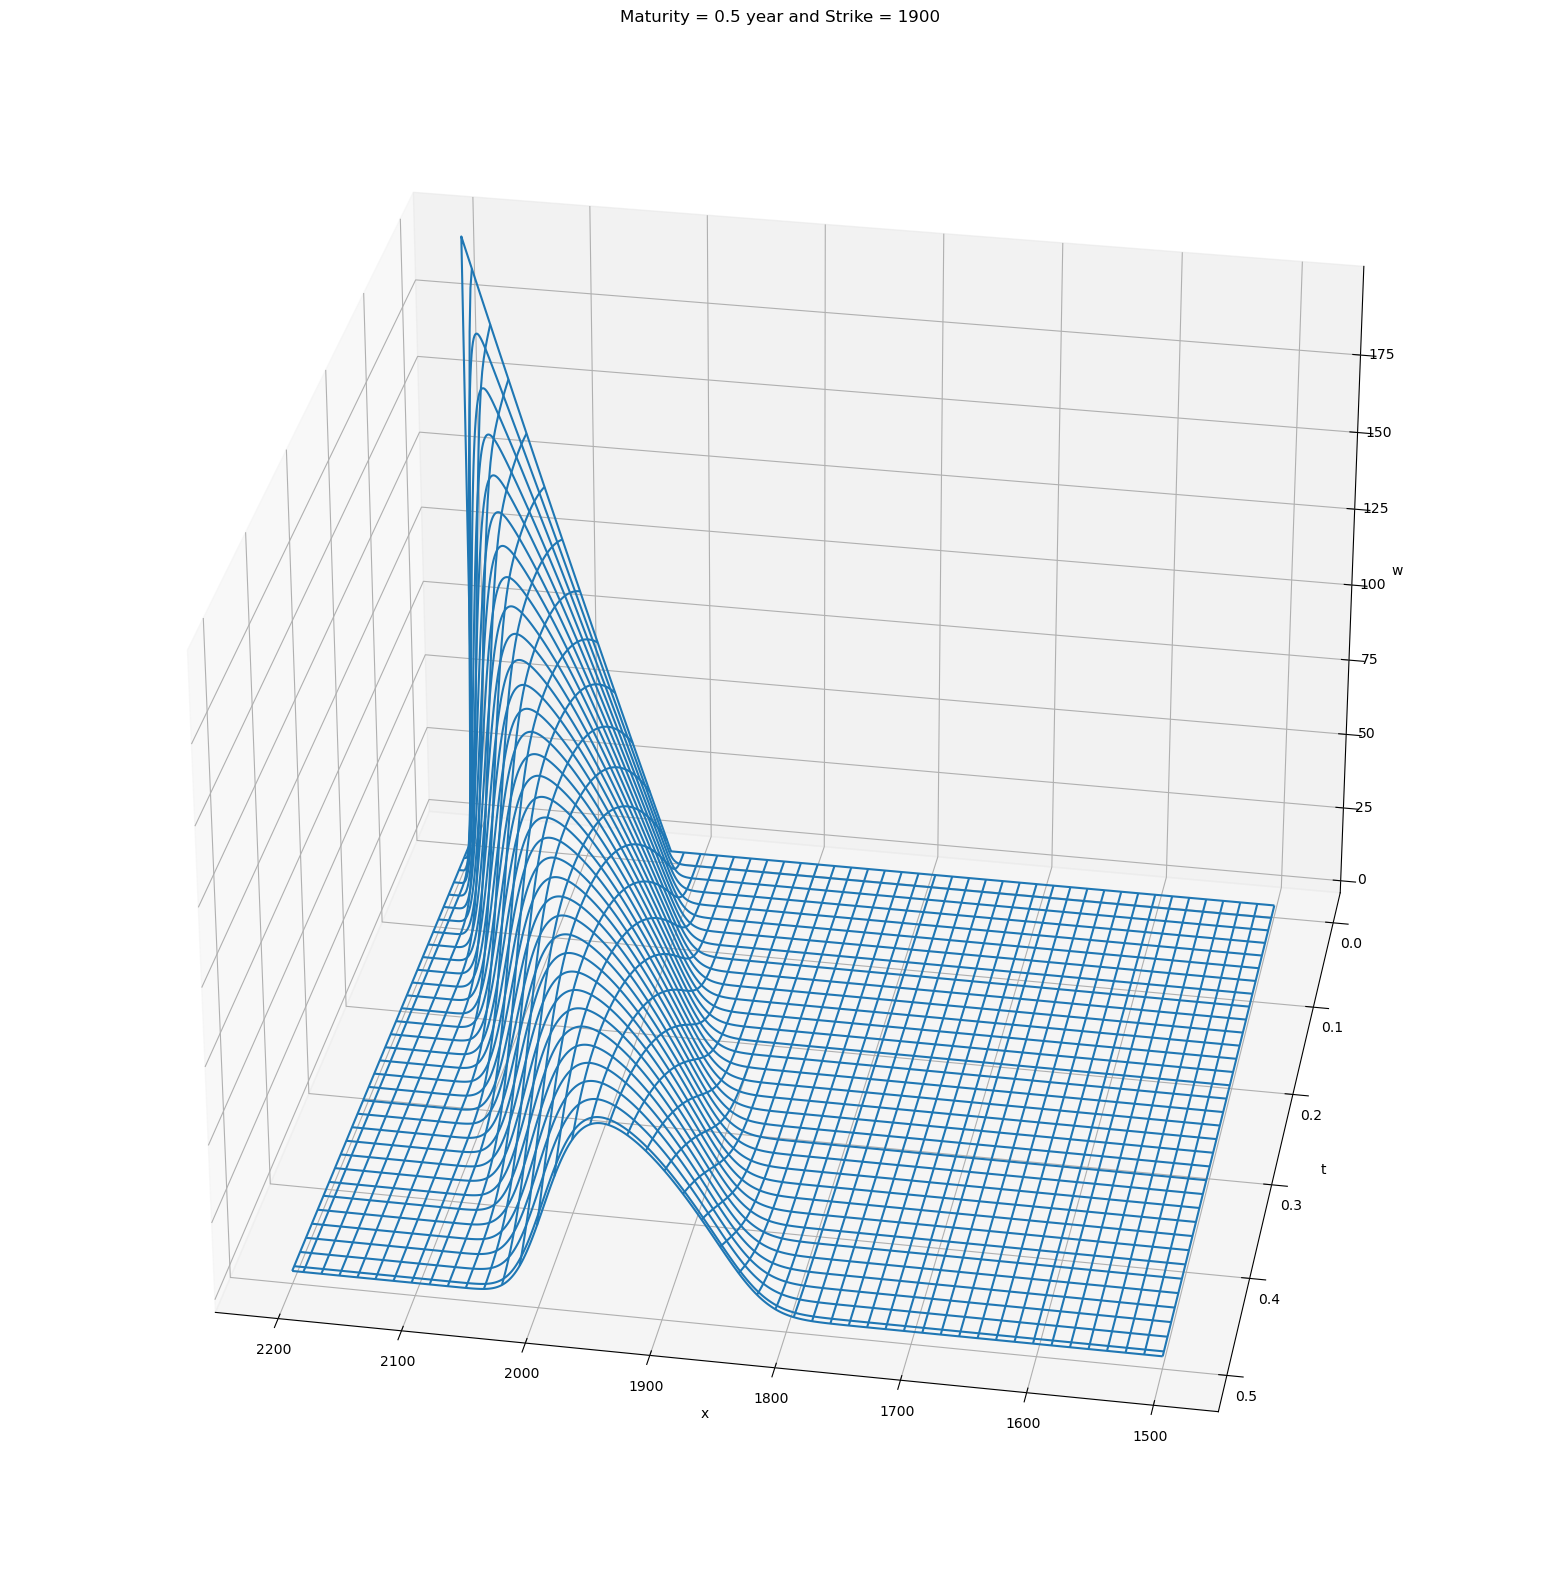

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example values for x and y axes
#x = np.linspace(-5, 5, 100)
#y = np.linspace(-5, 5, 100)
x = np.linspace(xmin, xmax, N+1)
t = np.linspace(0, T, M+1)
X, Y = np.meshgrid(x,t)
print(len(x))
print(len(t))
# Example matrix of values for the vertical axis
Z = np.array(Wmatrix)
print(np.shape(Z))
# Create 3D figure
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with X, Y, and Z values
#ax.plot_surface(X, Y, Z, cmap='viridis')
#ax.scatter(X, Y, Z)#, cmap='viridis')
ax.plot_wireframe(X, Y, Z)
# Add axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('w')
ax.set_title('Maturity = 0.5 year and Strike = 1900')

# Manually adjust the viewing angle
ax.view_init(30,100)

# Show the plot
plt.show()


In [ ]:
UOC

In [37]:
import math
import scipy.special as sc

S = 1900
K = 2000
Bound = 2200
rate = 0.0025
div = 0.015
T = 1/2
sig = 0.25
nu = 0.31
theta = -0.25
Y = 0.4
alpha = 0.4 

N= 300
M = 50
Rebate = 0

xmin = 1500# 10 avant
xmax = Bound

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))

Dx = (np.log(xmax)-np.log(xmin))/N
Dt = T/M

exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu # sans doute pb de formule?

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

def sigma_2(Y,Dx, lambda_p, lambda_n,v):
    #sig = integrate.quad(lambda y: y**2*k(y), -np.inf, -dx)[0]
    #sig += integrate.quad(lambda y: y**2*k(y), dx, np.inf)[0] 
    
    sig = (-(lambda_p*Dx)**(1-Y)*np.exp(-lambda_p*Dx)+(1-Y)*(g1(0)-g1(lambda_p*Dx)))*lambda_p**(Y-2)/v
    sig+= (-(lambda_n*Dx)**(1-Y)*np.exp(-lambda_n*Dx)+(1-Y)*(g1(0)-g1(lambda_n*Dx)))*lambda_n**(Y-2)/v
    
    return sig


Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
print(Bn)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx) # sur de la formule 
print(Bp)
#Bp is for U
sigma2_dx = sigma_2(Y,Dx, lambda_p, lambda_n,nu)
Bp  = sigma2_dx*Dt *(1/(2*Dx**2)-1/(2*Dx))
print(Bp)          
#Bn is for L
Bn  = sigma2_dx*Dt *(1/(2*Dx**2)+1/(2*Dx))
print(Bn)
           
# Precaculated Vectors
for k in range(1, N):
    ei_n[k] = sc.expi(k*Dx*lambda_n)
    ei_p[k] = sc.expi(k*Dx*lambda_p)
    exp_n[k] = np.exp(-k*Dx*lambda_n)
    exp_p[k] = np.exp(-k*Dx*lambda_p)
g1_neg_diff = [0]
g1_pos_diff = [0]
g2_neg_diff = [0]
g2_pos_diff = [0]

for k in range(1,N+1):
    g1_neg_diff.append(g1(k*Dx*lambda_n)-g1((k+1)*Dx*lambda_n))
    g1_pos_diff.append(g1(k*Dx*lambda_p)-g1((k+1)*Dx*lambda_p))
    g2_neg_diff.append(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
    g2_pos_diff.append(g2(k*Dx*lambda_p)-g2((k+1)*Dx*lambda_p))

x = np.empty(N+1)
W = np.empty(N+1)

Wmatrix=[]

for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = Rebate
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
            #print(W[i])
        else:
            W[i] = 0.0
            
#print('first W')
Wmatrix.append(W.tolist())

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/(2*Dx) # donne des meilleures resultats 
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            #print('if')
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n**Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                #B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
            
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*(g1_pos_diff[k])
        
        elif i == N-1:
            #print('elif')
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n**Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                #B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*(g1_neg_diff[k])
        else:
            #print('else')
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                #B[i] += c*((W[i+k]-W[i])-k*(W[i+k+1]-W[i+k]))*(ei_p[k]-ei_p[k+1]) + cp*(W[i+k+1]-W[i+k])*(exp_p[k]-exp_p[k+1])
                
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*(g1_pos_diff[k])
                
            for k in range(1, i):
                #B[i] += c*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(ei_n[k]-ei_n[k+1]) + cn*(W[i-k-1]-W[i-k])*(exp_n[k]-exp_n[k+1])
                #B[i] += lambda_n**Y*((W[i-k]-W[i])-k*(W[i-k-1]-W[i-k]))*(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
                #ligne above just added
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*(g1_neg_diff[k])
                
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) - np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))
        
        # B stand for the Rij
        #print(B[i],W[i])
    #for i in range(1, N):  
        #W[i] = B[i]
    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

#print(W)

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]


0.032116012904286374
0.031952807566648034
0.031952807566648034
0.032116012904286374


In [38]:
UOC

45.34706799986476

In [85]:
x0 = xmin 
xN = xmax
dx = Dx
dt = Dt
v = nu
sigma = sig   
x = np.linspace(x0, xN, N+1)
t = np.linspace(0, T, M+1)
    
lbda_p = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5-theta/(sigma**2)
lbda_n = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5+theta/(sigma**2)
    #print('Y2',Y)
    # Pre-computations of g1 and g2
g1n, g1p, g2n, g2p, g2n_p1, g2p_m1 = precomp_g(lbda_p, lbda_n, dx, N+1)
    #print(g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
    #print('Y3',Y)
    
    # Sigma and omega
sigma2 = sigma_2(Y,dx,g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
omega = omega_(Y,dx, g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
print(omega)
    
    # Compute Bl and Bu
a = sigma2*dt/(2*dx**2) # ah en fait non sigma est une fonction
b = (r-q + omega - 0.5*sigma2)*dt/(2*dx)
Bu = a+b
Bl = a-b

14.919057031246467
32.242170951959466
0.31
32.242170951959466
y 0.4
om -203.1560725359277
om -345.0799220761311
-345.0799220761311


In [86]:
Bu

array([-694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448419,
       -694.72448419, -694.72448419, -694.72448419, -694.72448

In [87]:
Bl

array([656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7665719,
       656.7665719, 656.7665719, 656.7665719, 656.7665719, 656.7

In [82]:
def omega_(Y, dx, g1n, g1p, g2n, g2p, g2n_p1, g2p_m1):
    #om = integrate.quad(lambda y: (1-np.exp(y))*k(y), -np.inf, -dx)[0]
    #om += integrate.quad(lambda y: (1-np.exp(y))*k(y), dx, np.inf)[0]
    om = 0
    om = lbda_p**Y*g2p[1]-(lbda_p-1)**Y*g2p_m1[1]/v
    print(lbda_p)
    print(g2p[1])
    print(v)
    print(g2p_m1[1])
    print('y', Y)
    print('om', om)
    om+= lbda_n**Y*g2n[1]-(lbda_n-1)**Y*g2n_p1[1]/v
    print('om', om)
    return om
   
def sigma_2(Y,dx,g1n, g1p, g2n, g2p, g2n_p1, g2p_m1):
    #sig = integrate.quad(lambda y: y**2*k(y), -np.inf, -dx)[0]
    #sig += integrate.quad(lambda y: y**2*k(y), dx, np.inf)[0] 
    
    sig = (-(lbda_p*dx)**(1-Y)*np.exp(-lbda_p*dx)-(1-Y)*(g1p[0]-g1p[1]))*lbda_p**(Y-2)/v
    sig+= (-(lbda_n*dx)**(1-Y)*np.exp(-lbda_n*dx)-(1-Y)*(g1n[0]-g1n[1]))*lbda_n**(Y-2)/v
    
    return sig

In [83]:
def precomp_g(lbda_p, lbda_n, dx, N):
    
    g1n = np.zeros(N)
    g1p = np.zeros(N)
    g2n = np.zeros(N)
    g2p = np.zeros(N)
    
    g2n_p1 = np.zeros(N)
    g2p_m1 = np.zeros(N)
    
    for i in range(N):
        g1n[i] = g1(i*dx*lbda_n, alpha, dx)
        g1p[i] = g1(i*dx*lbda_p, alpha, dx)
        g2n[i] = g2(i*dx*lbda_n, alpha, dx)
        g2p[i] = g2(i*dx*lbda_p, alpha, dx)
    
        g2n_p1[i] = g2(i*dx*(lbda_n+1), alpha, dx)
        g2p_m1[i] = g2(i*dx*(lbda_p-1), alpha, dx)
    
    return g1n, g1p, g2n, g2p, g2n_p1, g2p_m1
    

In [84]:
def g1(ksi, alpha, dx):
    g1 = integrate.quad(lambda y: np.exp(-y)/(y**alpha), dx, np.inf)[0]#, -np.inf, -dx)[0]
    return g1

def g2(ksi, alpha, dx):
    g2 = integrate.quad(lambda y: np.exp(-y)/(y**(alpha+1)), dx, np.inf)[0]#, -np.inf, -dx)[0]
    return g2